# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')
campvectrain = np.transpose(campvectrain, (0,2,3,1))

In [6]:
np.shape(campvectrain)

(7000, 100, 100, 2)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')
campvectest = np.transpose(campvectest, (0,2,3,1))

In [10]:
np.shape(campvectest)

(2000, 100, 100, 2)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')
campvecval = np.transpose(campvecval, (0,2,3,1))

In [14]:
np.shape(campvecval)

(1000, 100, 100, 2)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(100, 100, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [22]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [23]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

def objective(trial):
    model = Sequential()
    n_conv_layers = trial.suggest_int("n_conv_layers", 1, 5)
    
    input_shape = (100, 100, 2)  # Tus dimensiones de entrada
    current_shape = (20,20,2)
    
    for i in range(n_conv_layers):
        num_filters = trial.suggest_int(f"num_filters_{i+1}", 8, 50)
        filter_size1 = trial.suggest_int(f"filter_size1_{i+1}", 2, 5)
        filter_size2 = trial.suggest_int(f"filter_size2_{i+1}", 2, 5)
        activation = trial.suggest_categorical(f"activation_{i+1}", ['relu', 'tanh', 'sigmoid'])
        kernel_initializer = trial.suggest_categorical(f"kernel_initializer_{i+1}", ['HeNormal', 'glorot_uniform', 'random_normal'])
        kernel_regularizer = trial.suggest_categorical(f"kernel_regularizer_{i+1}", ['l1', 'l2'])
        
        regularizer = None
        if kernel_regularizer == 'l1':
            regularizer = l1(0.001)
        elif kernel_regularizer == 'l2':
            regularizer = l2(0.001)
            
            
        if (current_shape[0] - filter_size1 + 1 > 0) and (current_shape[1] - filter_size2 + 1 > 0):
            if i == 0:
                model.add(Conv2D(num_filters, (filter_size1, filter_size2), activation=activation, input_shape=input_shape, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
            else:
                model.add(Conv2D(num_filters, (filter_size1, filter_size2), activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
            
            current_shape = (current_shape[0] - filter_size1 + 1, current_shape[1] - filter_size2 + 1, num_filters)
            
        # Decide si agregar una capa de MaxPooling después de esta capa convolucional
        add_maxpooling = trial.suggest_categorical(f"add_maxpooling_after_conv_{i+1}", [True, False])
        if add_maxpooling:
            if current_shape[0] >= 2 and current_shape[1] >= 2:  # Asegurarse de que ambas dimensiones son suficientes para MaxPooling
                model.add(MaxPooling2D(pool_size=(2, 2)))
                current_shape = (current_shape[0] // 2, current_shape[1] // 2, current_shape[2])
        
    model.add(GlobalAveragePooling2D())
    n_dense_layers = trial.suggest_int("n_dense_layers", 1, 5)
    
    for i in range(n_dense_layers):
        num_units = trial.suggest_int(f"num_units_{i+1}", 16, 128)
        activation = trial.suggest_categorical(f"dense_activation_{i+1}", ['relu', 'tanh', 'sigmoid'])
        kernel_initializer = trial.suggest_categorical(f"dense_kernel_initializer_{i+1}", ['HeNormal', 'glorot_uniform', 'random_normal'])
        kernel_regularizer = trial.suggest_categorical(f"dense_kernel_regularizer_{i+1}", ['l1', 'l2'])

        regularizer = None
        if kernel_regularizer == 'l1':
            regularizer = l1(0.001)
        elif kernel_regularizer == 'l2':
            regularizer = l2(0.001)

        model.add(Dense(num_units, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer))
    
        # Decide si agregar una capa de BatchNormalization después de esta capa densa
        add_batchnorm = trial.suggest_categorical(f"add_batchnorm_after_dense_{i+1}", [True, False])
        if add_batchnorm:
            model.add(BatchNormalization())    
        # Decide si agregar una capa de Dropout después de esta capa densa
        add_dropout = trial.suggest_categorical(f"add_dropout_after_dense_{i+1}", [True, False])
        if add_dropout:
            dropout_rate = trial.suggest_float(f"dropout_rate_after_dense_{i+1}", 0.1, 0.5)
            model.add(Dropout(dropout_rate))
            
    model.add(Dense(7, activation=custom_activation))
        
    optimizer = Adam(learning_rate=0.001, clipvalue=100.0)
        
    model.compile(optimizer=optimizer, loss= 'mean_squared_error', metrics=metrics)
    
    history = model.fit(
        train_dataset, 
        validation_data=val_dataset, 
        epochs=50,  
        callbacks=[reduce_lr, early_stop]
    )
    
    val_mean_metric = history.history['val_mean_metric'][-1]
    
    return val_mean_metric

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print(f'Número de trials finalizados: {len(study.trials)}')
print(f'Mejor trial:')
trial = study.best_trial

print(f'  Valor: {trial.value}')
print('  Parámetros: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-10-04 15:22:32,031] A new study created in memory with name: no-name-e8dddd08-1e74-4203-b356-8646cafc99c8


Epoch 1/50
70/70 [==============================] - 5s 62ms/step - loss: 7.9186 - a_1: 2.7677 - a_2: 2.7486 - b_1: 2.6847 - b_2: 2.7427 - d_1: 1.7838 - d_2: 1.8819 - n: 1.4972 - mean_metric: 0.5308 - val_loss: 6.7724 - val_a_1: 2.6922 - val_a_2: 2.7309 - val_b_1: 2.5586 - val_b_2: 2.7775 - val_d_1: 1.0543 - val_d_2: 1.0315 - val_n: 1.4628 - val_mean_metric: 0.4734 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 59ms/step - loss: 6.7687 - a_1: 2.7639 - a_2: 2.7502 - b_1: 2.6464 - b_2: 2.7374 - d_1: 0.9169 - d_2: 0.9600 - n: 1.4885 - mean_metric: 0.4702 - val_loss: 6.5284 - val_a_1: 2.6912 - val_a_2: 2.7293 - val_b_1: 2.5836 - val_b_2: 2.7778 - val_d_1: 0.8123 - val_d_2: 0.7822 - val_n: 1.4651 - val_mean_metric: 0.4580 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 60ms/step - loss: 6.6248 - a_1: 2.7653 - a_2: 2.7495 - b_1: 2.6582 - b_2: 2.7363 - d_1: 0.7891 - d_2: 0.8114 - n: 1.4898 - mean_metric: 0.4616 - val_loss: 6.5210 - val_a_1: 2.6931 - val

Epoch 23/50
70/70 [==============================] - 4s 59ms/step - loss: 4.9480 - a_1: 2.4996 - a_2: 2.7239 - b_1: 0.9784 - b_2: 2.7343 - d_1: 0.4244 - d_2: 0.5233 - n: 1.4587 - mean_metric: 0.3740 - val_loss: 4.8577 - val_a_1: 2.4313 - val_a_2: 2.6958 - val_b_1: 1.0244 - val_b_2: 2.7786 - val_d_1: 0.3754 - val_d_2: 0.4473 - val_n: 1.4334 - val_mean_metric: 0.3701 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 60ms/step - loss: 4.8818 - a_1: 2.4212 - a_2: 2.7223 - b_1: 1.0148 - b_2: 2.7338 - d_1: 0.4178 - d_2: 0.5107 - n: 1.4400 - mean_metric: 0.3713 - val_loss: 4.8406 - val_a_1: 2.3341 - val_a_2: 2.6947 - val_b_1: 1.1082 - val_b_2: 2.7792 - val_d_1: 0.3775 - val_d_2: 0.5708 - val_n: 1.4135 - val_mean_metric: 0.3732 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 60ms/step - loss: 4.8422 - a_1: 2.3161 - a_2: 2.7210 - b_1: 1.0954 - b_2: 2.7345 - d_1: 0.4524 - d_2: 0.5634 - n: 1.4130 - mean_metric: 0.3724 - val_loss: 4.7638 - val_a_1: 2.2251 - 

[I 2023-10-04 15:26:02,114] Trial 0 finished with value: 0.32575029134750366 and parameters: {'n_conv_layers': 5, 'num_filters_1': 19, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 24, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 23, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 15, 'filter_size1_4': 5, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 24, 'filter_size1_5': 2, 'filter_size2_5': 4, 'activation_5': 'sigmoid', 'kernel_initial

Epoch 1/50
70/70 [==============================] - 9s 116ms/step - loss: 7.8823 - a_1: 2.7631 - a_2: 2.7674 - b_1: 2.5170 - b_2: 2.7451 - d_1: 0.8935 - d_2: 0.9061 - n: 2.0157 - mean_metric: 0.4815 - val_loss: 9.9146 - val_a_1: 2.6794 - val_a_2: 2.7480 - val_b_1: 2.6526 - val_b_2: 2.7832 - val_d_1: 2.4922 - val_d_2: 2.8180 - val_n: 1.5749 - val_mean_metric: 0.5872 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 8s 114ms/step - loss: 6.8579 - a_1: 2.7618 - a_2: 2.7491 - b_1: 2.2235 - b_2: 2.7405 - d_1: 0.6744 - d_2: 0.6513 - n: 1.5230 - mean_metric: 0.4393 - val_loss: 9.6892 - val_a_1: 2.6708 - val_a_2: 2.7221 - val_b_1: 2.7415 - val_b_2: 2.7917 - val_d_1: 2.4510 - val_d_2: 2.7107 - val_n: 1.4772 - val_mean_metric: 0.5812 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 8s 114ms/step - loss: 6.2627 - a_1: 2.7487 - a_2: 2.7449 - b_1: 1.6064 - b_2: 2.7386 - d_1: 0.5773 - d_2: 0.5749 - n: 1.4717 - mean_metric: 0.4108 - val_loss: 9.1174 - val_a_1: 2.6957 - 

70/70 [==============================] - 8s 114ms/step - loss: 3.3067 - a_1: 1.5516 - a_2: 1.2922 - b_1: 0.7793 - b_2: 2.7341 - d_1: 0.4415 - d_2: 0.3986 - n: 1.0494 - mean_metric: 0.2718 - val_loss: 20.7682 - val_a_1: 3.6603 - val_a_2: 4.6328 - val_b_1: 3.0561 - val_b_2: 2.8753 - val_d_1: 3.2143 - val_d_2: 0.7751 - val_n: 7.4403 - val_mean_metric: 0.8490 - lr: 0.0010
Epoch 44/50
70/70 [==============================] - 8s 115ms/step - loss: 3.2202 - a_1: 1.4837 - a_2: 1.2789 - b_1: 0.7441 - b_2: 2.7344 - d_1: 0.4227 - d_2: 0.4281 - n: 1.0340 - mean_metric: 0.2680 - val_loss: 13.9921 - val_a_1: 1.8281 - val_a_2: 2.1518 - val_b_1: 2.7933 - val_b_2: 3.0148 - val_d_1: 2.5449 - val_d_2: 0.5084 - val_n: 6.9812 - val_mean_metric: 0.6559 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 8s 114ms/step - loss: 3.1748 - a_1: 1.4486 - a_2: 1.2437 - b_1: 0.7330 - b_2: 2.7329 - d_1: 0.4478 - d_2: 0.4041 - n: 1.0057 - mean_metric: 0.2643 - val_loss: 10.9143 - val_a_1: 1.4176 - val_a_

[I 2023-10-04 15:32:43,258] Trial 1 finished with value: 0.6481819152832031 and parameters: {'n_conv_layers': 4, 'num_filters_1': 40, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 13, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 18, 'filter_size1_3': 4, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 43, 'filter_size1_4': 2, 'filter_size2_4': 5, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 1, 'num_units_1': 43, 'dense_activation_1': 'tanh', 'dense_kernel_initialize

Epoch 1/50
70/70 [==============================] - 4s 47ms/step - loss: 10.8276 - a_1: 2.9647 - a_2: 2.9706 - b_1: 1.9054 - b_2: 3.0117 - d_1: 1.1316 - d_2: 1.1337 - n: 2.3396 - mean_metric: 0.5094 - val_loss: 11.6256 - val_a_1: 2.7673 - val_a_2: 2.7417 - val_b_1: 2.7938 - val_b_2: 2.8422 - val_d_1: 2.5176 - val_d_2: 2.5848 - val_n: 1.6360 - val_mean_metric: 0.5919 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 44ms/step - loss: 8.7468 - a_1: 2.8266 - a_2: 2.8081 - b_1: 1.3477 - b_2: 2.8909 - d_1: 0.7996 - d_2: 0.8057 - n: 1.7262 - mean_metric: 0.4353 - val_loss: 10.9851 - val_a_1: 2.6752 - val_a_2: 2.7557 - val_b_1: 2.6592 - val_b_2: 2.8246 - val_d_1: 2.6166 - val_d_2: 2.2888 - val_n: 1.4749 - val_mean_metric: 0.5724 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 44ms/step - loss: 8.0265 - a_1: 2.7252 - a_2: 2.6308 - b_1: 1.2024 - b_2: 2.8397 - d_1: 0.7168 - d_2: 0.7254 - n: 1.5574 - mean_metric: 0.4087 - val_loss: 11.0821 - val_a_1: 2.6710 -

Epoch 44/50
70/70 [==============================] - 3s 44ms/step - loss: 3.4804 - a_1: 1.3219 - a_2: 1.3396 - b_1: 0.7110 - b_2: 2.7345 - d_1: 0.4552 - d_2: 0.4591 - n: 1.2447 - mean_metric: 0.2725 - val_loss: 6.9499 - val_a_1: 1.4877 - val_a_2: 2.5257 - val_b_1: 1.6718 - val_b_2: 2.8033 - val_d_1: 2.0035 - val_d_2: 2.7862 - val_n: 1.1958 - val_mean_metric: 0.4791 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 3s 44ms/step - loss: 3.4451 - a_1: 1.3249 - a_2: 1.3247 - b_1: 0.6976 - b_2: 2.7339 - d_1: 0.4723 - d_2: 0.4798 - n: 1.2283 - mean_metric: 0.2724 - val_loss: 5.3957 - val_a_1: 1.5210 - val_a_2: 1.3639 - val_b_1: 1.7935 - val_b_2: 2.8087 - val_d_1: 1.8555 - val_d_2: 1.8923 - val_n: 1.2927 - val_mean_metric: 0.4147 - lr: 0.0010
Epoch 46/50
70/70 [==============================] - 3s 44ms/step - loss: 3.4388 - a_1: 1.3175 - a_2: 1.3492 - b_1: 0.7039 - b_2: 2.7307 - d_1: 0.4605 - d_2: 0.4617 - n: 1.2335 - mean_metric: 0.2723 - val_loss: 5.5040 - val_a_1: 1.7517 - 

[I 2023-10-04 15:35:17,900] Trial 2 finished with value: 0.40819165110588074 and parameters: {'n_conv_layers': 1, 'num_filters_1': 23, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'n_dense_layers': 5, 'num_units_1': 107, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 60, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 114, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l1', 'add_batchnorm_after_dense_3': False, 'add_dropout_after_dense_3': False, 'num_units_4': 60, 'dense_activation_4': 'sigmo

Epoch 1/50
70/70 [==============================] - 5s 54ms/step - loss: 7.5720 - a_1: 2.8507 - a_2: 2.8648 - b_1: 2.3672 - b_2: 2.8624 - d_1: 1.0188 - d_2: 0.8433 - n: 1.9904 - mean_metric: 0.4877 - val_loss: 7.8200 - val_a_1: 2.6713 - val_a_2: 2.7418 - val_b_1: 2.5094 - val_b_2: 2.7894 - val_d_1: 2.0909 - val_d_2: 1.9035 - val_n: 1.5920 - val_mean_metric: 0.5395 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 52ms/step - loss: 5.6974 - a_1: 2.7246 - a_2: 2.7197 - b_1: 1.4657 - b_2: 2.7589 - d_1: 0.7605 - d_2: 0.6574 - n: 1.5128 - mean_metric: 0.4153 - val_loss: 7.1680 - val_a_1: 2.6803 - val_a_2: 2.7174 - val_b_1: 2.3498 - val_b_2: 2.7831 - val_d_1: 1.7162 - val_d_2: 1.6248 - val_n: 1.4787 - val_mean_metric: 0.5081 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 52ms/step - loss: 5.4197 - a_1: 2.6588 - a_2: 2.7042 - b_1: 1.2508 - b_2: 2.7532 - d_1: 0.6779 - d_2: 0.6212 - n: 1.4805 - mean_metric: 0.4004 - val_loss: 6.6327 - val_a_1: 2.6559 - val

Epoch 23/50
70/70 [==============================] - 4s 52ms/step - loss: 3.6384 - a_1: 1.6209 - a_2: 1.6312 - b_1: 0.9173 - b_2: 2.7459 - d_1: 0.5930 - d_2: 0.6032 - n: 1.3174 - mean_metric: 0.3108 - val_loss: 3.3298 - val_a_1: 1.5285 - val_a_2: 1.5307 - val_b_1: 0.7642 - val_b_2: 2.7939 - val_d_1: 0.3796 - val_d_2: 0.3109 - val_n: 1.2560 - val_mean_metric: 0.2834 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 53ms/step - loss: 3.5967 - a_1: 1.5946 - a_2: 1.6056 - b_1: 0.9308 - b_2: 2.7411 - d_1: 0.5876 - d_2: 0.6088 - n: 1.3044 - mean_metric: 0.3091 - val_loss: 3.3771 - val_a_1: 1.5092 - val_a_2: 1.4713 - val_b_1: 0.9521 - val_b_2: 2.8160 - val_d_1: 0.4365 - val_d_2: 0.4086 - val_n: 1.2799 - val_mean_metric: 0.2937 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 52ms/step - loss: 3.5822 - a_1: 1.5951 - a_2: 1.5849 - b_1: 0.9042 - b_2: 2.7519 - d_1: 0.5803 - d_2: 0.5868 - n: 1.3188 - mean_metric: 0.3074 - val_loss: 3.2951 - val_a_1: 1.4373 - 

[I 2023-10-04 15:38:21,156] Trial 3 finished with value: 0.2533067464828491 and parameters: {'n_conv_layers': 1, 'num_filters_1': 32, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'n_dense_layers': 3, 'num_units_1': 76, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 32, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.23775897160306958, 'num_units_3': 123, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'glorot_uniform', 'dense_kernel_regularizer_3': 'l2', 'add_batchnorm_after_dense_3': True, 'add_dropout_after_dense_3': False}. B

Epoch 1/50
70/70 [==============================] - 5s 59ms/step - loss: 8.1568 - a_1: 2.8240 - a_2: 2.7970 - b_1: 2.6240 - b_2: 2.7622 - d_1: 1.4205 - d_2: 1.3229 - n: 2.0406 - mean_metric: 0.5205 - val_loss: 10.1248 - val_a_1: 2.7203 - val_a_2: 2.8632 - val_b_1: 2.8123 - val_b_2: 3.1443 - val_d_1: 2.5940 - val_d_2: 2.6077 - val_n: 1.4761 - val_mean_metric: 0.6026 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 57ms/step - loss: 6.7208 - a_1: 2.7631 - a_2: 2.7566 - b_1: 2.4242 - b_2: 2.7424 - d_1: 0.8757 - d_2: 0.8171 - n: 1.5275 - mean_metric: 0.4585 - val_loss: 9.3974 - val_a_1: 2.7153 - val_a_2: 2.7908 - val_b_1: 2.6753 - val_b_2: 2.9759 - val_d_1: 2.4807 - val_d_2: 2.5537 - val_n: 1.4664 - val_mean_metric: 0.5841 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 57ms/step - loss: 6.1789 - a_1: 2.7581 - a_2: 2.7528 - b_1: 1.8554 - b_2: 2.7400 - d_1: 0.8133 - d_2: 0.7464 - n: 1.4707 - mean_metric: 0.4331 - val_loss: 8.8227 - val_a_1: 2.7074 - va

Epoch 23/50
70/70 [==============================] - 4s 57ms/step - loss: 4.5984 - a_1: 1.7112 - a_2: 2.7125 - b_1: 0.9204 - b_2: 2.7376 - d_1: 0.5966 - d_2: 0.5802 - n: 1.3179 - mean_metric: 0.3487 - val_loss: 4.4317 - val_a_1: 1.6846 - val_a_2: 2.6681 - val_b_1: 0.8300 - val_b_2: 2.7785 - val_d_1: 0.3948 - val_d_2: 0.5418 - val_n: 1.3382 - val_mean_metric: 0.3387 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 57ms/step - loss: 4.5734 - a_1: 1.6937 - a_2: 2.6920 - b_1: 0.9045 - b_2: 2.7382 - d_1: 0.6186 - d_2: 0.5757 - n: 1.3229 - mean_metric: 0.3477 - val_loss: 4.5755 - val_a_1: 1.7264 - val_a_2: 2.6456 - val_b_1: 1.1119 - val_b_2: 2.7775 - val_d_1: 0.4505 - val_d_2: 0.4301 - val_n: 1.3326 - val_mean_metric: 0.3467 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 57ms/step - loss: 4.5329 - a_1: 1.6877 - a_2: 2.6812 - b_1: 0.8641 - b_2: 2.7376 - d_1: 0.6245 - d_2: 0.5661 - n: 1.3209 - mean_metric: 0.3456 - val_loss: 4.5519 - val_a_1: 1.8391 - 

[I 2023-10-04 15:41:41,451] Trial 4 finished with value: 0.2823847532272339 and parameters: {'n_conv_layers': 3, 'num_filters_1': 41, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 31, 'filter_size1_2': 5, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 45, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 2, 'num_units_1': 36, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.2999546185948465, 'num_units_2': 70, 'd

Epoch 1/50
70/70 [==============================] - 3s 32ms/step - loss: 9.9426 - a_1: 2.7490 - a_2: 2.7383 - b_1: 2.4257 - b_2: 2.7747 - d_1: 1.4563 - d_2: 1.8210 - n: 1.7382 - mean_metric: 0.5175 - val_loss: 11.0111 - val_a_1: 2.6753 - val_a_2: 2.7186 - val_b_1: 2.9385 - val_b_2: 2.7860 - val_d_1: 2.3961 - val_d_2: 2.3574 - val_n: 1.4691 - val_mean_metric: 0.5738 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 30ms/step - loss: 8.1115 - a_1: 2.6424 - a_2: 2.6415 - b_1: 1.6586 - b_2: 2.7522 - d_1: 1.1990 - d_2: 1.2265 - n: 1.4517 - mean_metric: 0.4474 - val_loss: 11.0809 - val_a_1: 2.6712 - val_a_2: 2.7013 - val_b_1: 3.1569 - val_b_2: 2.7807 - val_d_1: 2.3109 - val_d_2: 2.2637 - val_n: 1.4608 - val_mean_metric: 0.5740 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 30ms/step - loss: 7.4838 - a_1: 2.4859 - a_2: 2.4067 - b_1: 1.5337 - b_2: 2.7520 - d_1: 1.1349 - d_2: 1.1149 - n: 1.3981 - mean_metric: 0.4229 - val_loss: 11.0551 - val_a_1: 2.6481 - 

Epoch 23/50
70/70 [==============================] - 2s 30ms/step - loss: 4.1174 - a_1: 1.4419 - a_2: 1.3860 - b_1: 0.8992 - b_2: 2.7320 - d_1: 0.6426 - d_2: 0.6255 - n: 1.2095 - mean_metric: 0.2947 - val_loss: 4.6206 - val_a_1: 1.4806 - val_a_2: 1.6124 - val_b_1: 1.3980 - val_b_2: 2.7838 - val_d_1: 0.8225 - val_d_2: 0.6744 - val_n: 1.2031 - val_mean_metric: 0.3302 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 30ms/step - loss: 4.1048 - a_1: 1.4261 - a_2: 1.4179 - b_1: 0.9041 - b_2: 2.7355 - d_1: 0.6582 - d_2: 0.6483 - n: 1.2148 - mean_metric: 0.2970 - val_loss: 4.7630 - val_a_1: 1.5822 - val_a_2: 1.7122 - val_b_1: 0.9526 - val_b_2: 2.7895 - val_d_1: 1.2052 - val_d_2: 0.9721 - val_n: 1.2027 - val_mean_metric: 0.3448 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 30ms/step - loss: 4.0687 - a_1: 1.4511 - a_2: 1.4175 - b_1: 0.8902 - b_2: 2.7338 - d_1: 0.6274 - d_2: 0.6349 - n: 1.2092 - mean_metric: 0.2955 - val_loss: 4.3024 - val_a_1: 1.4765 - 

[I 2023-10-04 15:43:26,716] Trial 5 finished with value: 0.2902565002441406 and parameters: {'n_conv_layers': 2, 'num_filters_1': 27, 'filter_size1_1': 5, 'filter_size2_1': 2, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 21, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'n_dense_layers': 3, 'num_units_1': 113, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_uniform', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': False, 'num_units_2': 105, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': True, 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.38115498926841485, 'num_units_3': 74, 'dens

Epoch 1/50
70/70 [==============================] - 4s 50ms/step - loss: 8.6928 - a_1: 2.9089 - a_2: 2.8231 - b_1: 2.2603 - b_2: 2.9184 - d_1: 1.4826 - d_2: 1.5536 - n: 2.1266 - mean_metric: 0.5297 - val_loss: 8.5977 - val_a_1: 2.6686 - val_a_2: 2.7324 - val_b_1: 2.5096 - val_b_2: 2.7787 - val_d_1: 2.3831 - val_d_2: 2.4171 - val_n: 1.5415 - val_mean_metric: 0.5636 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 47ms/step - loss: 6.1883 - a_1: 2.6541 - a_2: 2.6220 - b_1: 1.5642 - b_2: 2.7926 - d_1: 1.0303 - d_2: 1.0522 - n: 1.5315 - mean_metric: 0.4367 - val_loss: 8.2136 - val_a_1: 2.6508 - val_a_2: 2.6968 - val_b_1: 2.3942 - val_b_2: 2.7785 - val_d_1: 2.3287 - val_d_2: 2.2862 - val_n: 1.4717 - val_mean_metric: 0.5495 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 48ms/step - loss: 5.2542 - a_1: 2.4820 - a_2: 2.3143 - b_1: 1.2074 - b_2: 2.7717 - d_1: 0.8144 - d_2: 0.8224 - n: 1.4447 - mean_metric: 0.3909 - val_loss: 7.8106 - val_a_1: 2.6072 - val

Epoch 23/50
70/70 [==============================] - 3s 47ms/step - loss: 3.0793 - a_1: 1.2545 - a_2: 1.2276 - b_1: 0.8461 - b_2: 2.7310 - d_1: 0.6642 - d_2: 0.6558 - n: 0.9126 - mean_metric: 0.2734 - val_loss: 2.8505 - val_a_1: 1.1946 - val_a_2: 1.0936 - val_b_1: 0.7200 - val_b_2: 2.7994 - val_d_1: 0.5361 - val_d_2: 0.4799 - val_n: 0.7466 - val_mean_metric: 0.2508 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 48ms/step - loss: 3.0384 - a_1: 1.2253 - a_2: 1.2217 - b_1: 0.8336 - b_2: 2.7346 - d_1: 0.6599 - d_2: 0.6525 - n: 0.8896 - mean_metric: 0.2709 - val_loss: 2.8921 - val_a_1: 1.1485 - val_a_2: 1.2754 - val_b_1: 0.6975 - val_b_2: 2.8059 - val_d_1: 0.4751 - val_d_2: 0.4773 - val_n: 0.7979 - val_mean_metric: 0.2543 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 47ms/step - loss: 3.0458 - a_1: 1.2397 - a_2: 1.2328 - b_1: 0.8371 - b_2: 2.7277 - d_1: 0.6728 - d_2: 0.6566 - n: 0.8772 - mean_metric: 0.2718 - val_loss: 2.7519 - val_a_1: 1.0154 - 

[I 2023-10-04 15:46:13,935] Trial 6 finished with value: 0.23667490482330322 and parameters: {'n_conv_layers': 5, 'num_filters_1': 48, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 48, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 12, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 36, 'filter_size1_4': 5, 'filter_size2_4': 5, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 20, 'filter_size1_5': 3, 'filter_size2_5': 3, 'activation_5': 'sigmoid', 'kernel_initializer_5': 

Epoch 1/50
70/70 [==============================] - 9s 125ms/step - loss: 8.3995 - a_1: 2.8190 - a_2: 2.8536 - b_1: 2.5381 - b_2: 2.9209 - d_1: 1.2210 - d_2: 1.3307 - n: 1.5303 - mean_metric: 0.5014 - val_loss: 8.5327 - val_a_1: 2.6899 - val_a_2: 2.7251 - val_b_1: 2.5836 - val_b_2: 2.7906 - val_d_1: 1.9604 - val_d_2: 2.0393 - val_n: 1.4697 - val_mean_metric: 0.5379 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 9s 122ms/step - loss: 6.7034 - a_1: 2.7744 - a_2: 2.7798 - b_1: 1.6328 - b_2: 2.7742 - d_1: 0.8094 - d_2: 0.8780 - n: 1.5179 - mean_metric: 0.4340 - val_loss: 8.4191 - val_a_1: 2.6985 - val_a_2: 2.7222 - val_b_1: 2.4425 - val_b_2: 2.7767 - val_d_1: 2.1688 - val_d_2: 1.8853 - val_n: 1.4683 - val_mean_metric: 0.5346 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 9s 122ms/step - loss: 6.2174 - a_1: 2.7495 - a_2: 2.7743 - b_1: 1.1437 - b_2: 2.7948 - d_1: 0.7054 - d_2: 0.7335 - n: 1.5116 - mean_metric: 0.4093 - val_loss: 8.0847 - val_a_1: 2.6848 - 

70/70 [==============================] - 9s 122ms/step - loss: 3.4773 - a_1: 1.4067 - a_2: 1.4202 - b_1: 0.9374 - b_2: 2.7442 - d_1: 0.6562 - d_2: 0.6518 - n: 1.2297 - mean_metric: 0.2982 - val_loss: 3.7804 - val_a_1: 1.6016 - val_a_2: 1.3903 - val_b_1: 0.8465 - val_b_2: 2.7826 - val_d_1: 0.5828 - val_d_2: 1.2387 - val_n: 1.1800 - val_mean_metric: 0.3185 - lr: 0.0010
Epoch 44/50
70/70 [==============================] - 9s 122ms/step - loss: 3.5025 - a_1: 1.4437 - a_2: 1.4389 - b_1: 0.9149 - b_2: 2.7389 - d_1: 0.6551 - d_2: 0.6537 - n: 1.2282 - mean_metric: 0.2991 - val_loss: 3.7458 - val_a_1: 1.5195 - val_a_2: 1.4523 - val_b_1: 0.8430 - val_b_2: 2.7839 - val_d_1: 0.5911 - val_d_2: 1.3558 - val_n: 1.2201 - val_mean_metric: 0.3232 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 9s 123ms/step - loss: 3.4645 - a_1: 1.4265 - a_2: 1.4089 - b_1: 0.9182 - b_2: 2.7375 - d_1: 0.6536 - d_2: 0.6545 - n: 1.2246 - mean_metric: 0.2975 - val_loss: 4.4715 - val_a_1: 2.3828 - val_a_2: 

[I 2023-10-04 15:53:22,923] Trial 7 finished with value: 0.3114008903503418 and parameters: {'n_conv_layers': 4, 'num_filters_1': 43, 'filter_size1_1': 2, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 37, 'filter_size1_2': 3, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 49, 'filter_size1_3': 5, 'filter_size2_3': 2, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 19, 'filter_size1_4': 2, 'filter_size2_4': 2, 'activation_4': 'tanh', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 3, 'num_units_1': 95, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1':

Epoch 1/50
70/70 [==============================] - 3s 34ms/step - loss: 8.9820 - a_1: 2.8087 - a_2: 2.7914 - b_1: 2.6082 - b_2: 2.7911 - d_1: 2.1777 - d_2: 2.1119 - n: 1.5418 - mean_metric: 0.5548 - val_loss: 7.8569 - val_a_1: 2.7038 - val_a_2: 2.7363 - val_b_1: 2.4244 - val_b_2: 2.7977 - val_d_1: 1.7784 - val_d_2: 1.6306 - val_n: 1.4865 - val_mean_metric: 0.5148 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 32ms/step - loss: 8.1453 - a_1: 2.7869 - a_2: 2.7925 - b_1: 2.4665 - b_2: 2.7645 - d_1: 1.8260 - d_2: 1.6084 - n: 1.5351 - mean_metric: 0.5203 - val_loss: 7.4305 - val_a_1: 2.6908 - val_a_2: 2.7284 - val_b_1: 2.3288 - val_b_2: 2.7897 - val_d_1: 1.6075 - val_d_2: 1.3820 - val_n: 1.4842 - val_mean_metric: 0.4967 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 31ms/step - loss: 7.7765 - a_1: 2.7667 - a_2: 2.7921 - b_1: 2.4009 - b_2: 2.7635 - d_1: 1.6470 - d_2: 1.4283 - n: 1.5324 - mean_metric: 0.5055 - val_loss: 7.1248 - val_a_1: 2.6812 - val

Epoch 23/50
70/70 [==============================] - 2s 31ms/step - loss: 5.7011 - a_1: 2.6560 - a_2: 2.7275 - b_1: 1.1029 - b_2: 2.7342 - d_1: 0.7643 - d_2: 0.7874 - n: 1.4653 - mean_metric: 0.4035 - val_loss: 5.2187 - val_a_1: 2.5886 - val_a_2: 2.6803 - val_b_1: 0.8375 - val_b_2: 2.7810 - val_d_1: 0.4195 - val_d_2: 0.3896 - val_n: 1.4679 - val_mean_metric: 0.3694 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 32ms/step - loss: 5.6770 - a_1: 2.6421 - a_2: 2.7206 - b_1: 1.0972 - b_2: 2.7342 - d_1: 0.7814 - d_2: 0.7753 - n: 1.4672 - mean_metric: 0.4028 - val_loss: 5.2000 - val_a_1: 2.5836 - val_a_2: 2.6752 - val_b_1: 0.8449 - val_b_2: 2.7811 - val_d_1: 0.4126 - val_d_2: 0.3840 - val_n: 1.4655 - val_mean_metric: 0.3688 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 31ms/step - loss: 5.6959 - a_1: 2.6414 - a_2: 2.7218 - b_1: 1.1386 - b_2: 2.7333 - d_1: 0.7850 - d_2: 0.7985 - n: 1.4716 - mean_metric: 0.4052 - val_loss: 5.2135 - val_a_1: 2.5759 - 

[I 2023-10-04 15:55:13,744] Trial 8 finished with value: 0.3436257243156433 and parameters: {'n_conv_layers': 4, 'num_filters_1': 18, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 34, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 10, 'filter_size1_3': 2, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 43, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'relu', 'kernel_initializer_4': 'random_normal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 2, 'num_units_1': 96, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'He

Epoch 1/50
70/70 [==============================] - 4s 51ms/step - loss: 7.6164 - a_1: 2.7549 - a_2: 2.7566 - b_1: 2.3429 - b_2: 2.7647 - d_1: 1.0637 - d_2: 1.0162 - n: 1.8424 - mean_metric: 0.4793 - val_loss: 10.5298 - val_a_1: 2.9167 - val_a_2: 2.9570 - val_b_1: 2.8426 - val_b_2: 2.7821 - val_d_1: 2.5276 - val_d_2: 2.5259 - val_n: 1.4772 - val_mean_metric: 0.5967 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 48ms/step - loss: 6.3682 - a_1: 2.7257 - a_2: 2.7220 - b_1: 1.7926 - b_2: 2.7430 - d_1: 0.6921 - d_2: 0.6396 - n: 1.4757 - mean_metric: 0.4216 - val_loss: 9.8448 - val_a_1: 2.7401 - val_a_2: 2.9943 - val_b_1: 2.8215 - val_b_2: 2.7917 - val_d_1: 2.4054 - val_d_2: 2.2746 - val_n: 1.4698 - val_mean_metric: 0.5791 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 48ms/step - loss: 5.8837 - a_1: 2.6959 - a_2: 2.6762 - b_1: 1.2161 - b_2: 2.7527 - d_1: 0.6412 - d_2: 0.6036 - n: 1.4650 - mean_metric: 0.3973 - val_loss: 8.9624 - val_a_1: 2.6930 - va

Epoch 23/50
70/70 [==============================] - 3s 48ms/step - loss: 3.5020 - a_1: 1.4466 - a_2: 1.4332 - b_1: 0.8134 - b_2: 2.7371 - d_1: 0.4746 - d_2: 0.4649 - n: 1.1099 - mean_metric: 0.2796 - val_loss: 5.6610 - val_a_1: 2.3371 - val_a_2: 2.1954 - val_b_1: 1.1780 - val_b_2: 2.8430 - val_d_1: 0.6529 - val_d_2: 0.8036 - val_n: 1.5797 - val_mean_metric: 0.3838 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 48ms/step - loss: 3.4492 - a_1: 1.4212 - a_2: 1.4003 - b_1: 0.7825 - b_2: 2.7349 - d_1: 0.4771 - d_2: 0.4663 - n: 1.1074 - mean_metric: 0.2766 - val_loss: 4.7614 - val_a_1: 2.6095 - val_a_2: 1.4485 - val_b_1: 0.9546 - val_b_2: 2.8003 - val_d_1: 0.4283 - val_d_2: 0.3854 - val_n: 1.5668 - val_mean_metric: 0.3376 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 48ms/step - loss: 3.4192 - a_1: 1.3882 - a_2: 1.4186 - b_1: 0.7617 - b_2: 2.7352 - d_1: 0.4859 - d_2: 0.4262 - n: 1.0930 - mean_metric: 0.2740 - val_loss: 6.0619 - val_a_1: 3.3887 - 

[I 2023-10-04 15:58:02,572] Trial 9 finished with value: 0.329764723777771 and parameters: {'n_conv_layers': 4, 'num_filters_1': 31, 'filter_size1_1': 3, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 27, 'filter_size1_2': 3, 'filter_size2_2': 2, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 23, 'filter_size1_3': 3, 'filter_size2_3': 2, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 38, 'filter_size1_4': 5, 'filter_size2_4': 3, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'n_dense_layers': 1, 'num_units_1': 116, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1':

Epoch 1/50
70/70 [==============================] - 3s 32ms/step - loss: 11.5676 - a_1: 3.0719 - a_2: 2.9998 - b_1: 2.9661 - b_2: 2.9567 - d_1: 2.3273 - d_2: 2.4834 - n: 2.1832 - mean_metric: 0.6257 - val_loss: 10.0116 - val_a_1: 2.6833 - val_a_2: 2.7257 - val_b_1: 2.6452 - val_b_2: 2.7808 - val_d_1: 2.5903 - val_d_2: 2.7231 - val_n: 2.2170 - val_mean_metric: 0.6079 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 29ms/step - loss: 9.0830 - a_1: 2.9376 - a_2: 2.8922 - b_1: 2.6770 - b_2: 2.8520 - d_1: 1.7708 - d_2: 1.8319 - n: 1.6866 - mean_metric: 0.5489 - val_loss: 9.6225 - val_a_1: 2.6782 - val_a_2: 2.7268 - val_b_1: 2.6287 - val_b_2: 2.7900 - val_d_1: 2.4968 - val_d_2: 2.6458 - val_n: 1.9681 - val_mean_metric: 0.5936 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 29ms/step - loss: 8.4478 - a_1: 2.8721 - a_2: 2.8440 - b_1: 2.5002 - b_2: 2.8169 - d_1: 1.6731 - d_2: 1.6872 - n: 1.6230 - mean_metric: 0.5280 - val_loss: 9.1436 - val_a_1: 2.6754 - v

Epoch 23/50
70/70 [==============================] - 2s 28ms/step - loss: 6.2348 - a_1: 2.6929 - a_2: 2.6932 - b_1: 1.4072 - b_2: 2.7454 - d_1: 1.1960 - d_2: 1.2024 - n: 1.4866 - mean_metric: 0.4426 - val_loss: 5.5225 - val_a_1: 2.6235 - val_a_2: 2.6493 - val_b_1: 0.9976 - val_b_2: 2.7996 - val_d_1: 0.9525 - val_d_2: 0.7321 - val_n: 1.4691 - val_mean_metric: 0.4045 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 29ms/step - loss: 6.1941 - a_1: 2.6857 - a_2: 2.7004 - b_1: 1.3861 - b_2: 2.7407 - d_1: 1.1779 - d_2: 1.1941 - n: 1.4851 - mean_metric: 0.4408 - val_loss: 5.4991 - val_a_1: 2.6125 - val_a_2: 2.6539 - val_b_1: 0.9842 - val_b_2: 2.7973 - val_d_1: 0.9138 - val_d_2: 0.8358 - val_n: 1.4671 - val_mean_metric: 0.4059 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 28ms/step - loss: 6.1882 - a_1: 2.6785 - a_2: 2.6896 - b_1: 1.4139 - b_2: 2.7382 - d_1: 1.1777 - d_2: 1.2096 - n: 1.4846 - mean_metric: 0.4415 - val_loss: 5.6067 - val_a_1: 2.6149 - 

[I 2023-10-04 15:59:43,863] Trial 10 finished with value: 0.4132007956504822 and parameters: {'n_conv_layers': 5, 'num_filters_1': 9, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 46, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 34, 'filter_size1_3': 2, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 29, 'filter_size1_4': 4, 'filter_size2_4': 5, 'activation_4': 'tanh', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 10, 'filter_size1_5': 4, 'filter_size2_5': 2, 'activation_5': 'sigmoid', 'kernel_initializer_5': 'HeNor

Epoch 1/50
70/70 [==============================] - 4s 45ms/step - loss: 8.5924 - a_1: 2.9143 - a_2: 2.9138 - b_1: 2.5606 - b_2: 2.8615 - d_1: 1.1429 - d_2: 1.2012 - n: 2.3772 - mean_metric: 0.5263 - val_loss: 7.5817 - val_a_1: 2.6781 - val_a_2: 2.7431 - val_b_1: 2.4900 - val_b_2: 2.7883 - val_d_1: 1.4855 - val_d_2: 1.8108 - val_n: 1.9021 - val_mean_metric: 0.5262 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 42ms/step - loss: 6.6992 - a_1: 2.8022 - a_2: 2.7927 - b_1: 1.9441 - b_2: 2.7704 - d_1: 0.9259 - d_2: 0.9124 - n: 1.8128 - mean_metric: 0.4602 - val_loss: 6.7567 - val_a_1: 2.6778 - val_a_2: 2.7330 - val_b_1: 2.4718 - val_b_2: 2.7841 - val_d_1: 0.9381 - val_d_2: 1.0629 - val_n: 1.6177 - val_mean_metric: 0.4728 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 43ms/step - loss: 6.0828 - a_1: 2.7490 - a_2: 2.7569 - b_1: 1.5601 - b_2: 2.7667 - d_1: 0.8534 - d_2: 0.8283 - n: 1.6002 - mean_metric: 0.4324 - val_loss: 7.2919 - val_a_1: 2.7142 - val

Epoch 23/50
70/70 [==============================] - 3s 43ms/step - loss: 3.6328 - a_1: 1.5867 - a_2: 1.5441 - b_1: 1.0066 - b_2: 2.7403 - d_1: 0.7305 - d_2: 0.7174 - n: 1.3345 - mean_metric: 0.3185 - val_loss: 3.5274 - val_a_1: 1.5993 - val_a_2: 1.5913 - val_b_1: 0.8098 - val_b_2: 2.7949 - val_d_1: 0.5657 - val_d_2: 0.8454 - val_n: 1.3120 - val_mean_metric: 0.3152 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 42ms/step - loss: 3.6742 - a_1: 1.6039 - a_2: 1.5876 - b_1: 1.0018 - b_2: 2.7408 - d_1: 0.7087 - d_2: 0.7411 - n: 1.3345 - mean_metric: 0.3205 - val_loss: 3.2807 - val_a_1: 1.4533 - val_a_2: 1.4438 - val_b_1: 0.8236 - val_b_2: 2.7852 - val_d_1: 0.6815 - val_d_2: 0.5727 - val_n: 1.2940 - val_mean_metric: 0.2998 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 42ms/step - loss: 3.5873 - a_1: 1.5588 - a_2: 1.5133 - b_1: 1.0001 - b_2: 2.7402 - d_1: 0.7419 - d_2: 0.7448 - n: 1.3152 - mean_metric: 0.3169 - val_loss: 3.3063 - val_a_1: 1.5125 - 

[I 2023-10-04 16:02:13,553] Trial 11 finished with value: 0.2508392035961151 and parameters: {'n_conv_layers': 1, 'num_filters_1': 49, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 4, 'num_units_1': 65, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.10421267937796636, 'num_units_2': 94, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.49934787545358783, 'num_units_3': 85, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_batchnorm_after_dense_

Epoch 1/50
70/70 [==============================] - 4s 45ms/step - loss: 7.8028 - a_1: 2.8623 - a_2: 2.8007 - b_1: 2.3649 - b_2: 2.8262 - d_1: 0.9733 - d_2: 1.0233 - n: 2.3455 - mean_metric: 0.5009 - val_loss: 7.9967 - val_a_1: 2.7014 - val_a_2: 2.7449 - val_b_1: 2.4651 - val_b_2: 2.7951 - val_d_1: 1.9718 - val_d_2: 1.9121 - val_n: 1.8191 - val_mean_metric: 0.5432 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 42ms/step - loss: 6.2642 - a_1: 2.7657 - a_2: 2.7588 - b_1: 1.6337 - b_2: 2.7669 - d_1: 0.6684 - d_2: 0.7592 - n: 1.8519 - mean_metric: 0.4353 - val_loss: 6.7156 - val_a_1: 2.7118 - val_a_2: 2.7326 - val_b_1: 2.2684 - val_b_2: 2.8001 - val_d_1: 1.2346 - val_d_2: 0.9256 - val_n: 1.6178 - val_mean_metric: 0.4730 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 42ms/step - loss: 5.7779 - a_1: 2.7291 - a_2: 2.7442 - b_1: 1.3359 - b_2: 2.7572 - d_1: 0.6371 - d_2: 0.6883 - n: 1.6166 - mean_metric: 0.4124 - val_loss: 6.4647 - val_a_1: 2.6812 - val

Epoch 23/50
70/70 [==============================] - 3s 42ms/step - loss: 2.8217 - a_1: 1.1402 - a_2: 1.1449 - b_1: 0.7207 - b_2: 2.7284 - d_1: 0.5198 - d_2: 0.5465 - n: 1.1197 - mean_metric: 0.2612 - val_loss: 2.6965 - val_a_1: 1.0968 - val_a_2: 1.0485 - val_b_1: 0.6286 - val_b_2: 2.8054 - val_d_1: 0.3744 - val_d_2: 0.3710 - val_n: 1.0800 - val_mean_metric: 0.2452 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 42ms/step - loss: 2.8047 - a_1: 1.1662 - a_2: 1.1194 - b_1: 0.7228 - b_2: 2.7243 - d_1: 0.5193 - d_2: 0.5406 - n: 1.1142 - mean_metric: 0.2607 - val_loss: 2.7808 - val_a_1: 1.2107 - val_a_2: 1.0691 - val_b_1: 0.6248 - val_b_2: 2.8092 - val_d_1: 0.3925 - val_d_2: 0.3945 - val_n: 1.1109 - val_mean_metric: 0.2521 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 42ms/step - loss: 2.8372 - a_1: 1.1485 - a_2: 1.1718 - b_1: 0.7232 - b_2: 2.7259 - d_1: 0.5550 - d_2: 0.5320 - n: 1.1146 - mean_metric: 0.2628 - val_loss: 2.6807 - val_a_1: 1.0356 - 

[I 2023-10-04 16:04:40,726] Trial 12 finished with value: 0.229660302400589 and parameters: {'n_conv_layers': 2, 'num_filters_1': 48, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 4, 'num_units_1': 54, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.1077192670753825, 'num_units_2': 99, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 

Epoch 1/50
70/70 [==============================] - 4s 45ms/step - loss: 8.5497 - a_1: 2.9046 - a_2: 2.9119 - b_1: 2.5560 - b_2: 2.8761 - d_1: 1.1392 - d_2: 1.1736 - n: 2.3524 - mean_metric: 0.5244 - val_loss: 7.5260 - val_a_1: 2.6871 - val_a_2: 2.8151 - val_b_1: 2.4387 - val_b_2: 2.7831 - val_d_1: 1.5493 - val_d_2: 1.4702 - val_n: 1.8453 - val_mean_metric: 0.5160 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 42ms/step - loss: 6.4894 - a_1: 2.7978 - a_2: 2.7634 - b_1: 1.6463 - b_2: 2.7762 - d_1: 0.9465 - d_2: 0.8736 - n: 1.8442 - mean_metric: 0.4500 - val_loss: 6.1686 - val_a_1: 2.7021 - val_a_2: 2.6966 - val_b_1: 1.8016 - val_b_2: 2.7781 - val_d_1: 0.8473 - val_d_2: 0.9725 - val_n: 1.6500 - val_mean_metric: 0.4451 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 42ms/step - loss: 5.9293 - a_1: 2.7858 - a_2: 2.7322 - b_1: 1.3506 - b_2: 2.7664 - d_1: 0.8517 - d_2: 0.7584 - n: 1.6057 - mean_metric: 0.4237 - val_loss: 5.8333 - val_a_1: 2.7119 - val

Epoch 23/50
70/70 [==============================] - 3s 42ms/step - loss: 2.9299 - a_1: 1.1889 - a_2: 1.1664 - b_1: 0.7878 - b_2: 2.7308 - d_1: 0.5806 - d_2: 0.5278 - n: 1.1716 - mean_metric: 0.2688 - val_loss: 3.1836 - val_a_1: 1.3676 - val_a_2: 1.2230 - val_b_1: 0.7596 - val_b_2: 2.8022 - val_d_1: 0.6385 - val_d_2: 0.4955 - val_n: 1.1585 - val_mean_metric: 0.2796 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 42ms/step - loss: 2.9074 - a_1: 1.1693 - a_2: 1.1585 - b_1: 0.7857 - b_2: 2.7286 - d_1: 0.5844 - d_2: 0.5294 - n: 1.1672 - mean_metric: 0.2678 - val_loss: 2.9886 - val_a_1: 1.1368 - val_a_2: 1.2769 - val_b_1: 0.7211 - val_b_2: 2.7895 - val_d_1: 0.6638 - val_d_2: 0.6310 - val_n: 1.1076 - val_mean_metric: 0.2757 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 42ms/step - loss: 2.9038 - a_1: 1.1781 - a_2: 1.1585 - b_1: 0.7759 - b_2: 2.7308 - d_1: 0.5706 - d_2: 0.5286 - n: 1.1502 - mean_metric: 0.2668 - val_loss: 2.9882 - val_a_1: 1.1246 - 

[I 2023-10-04 16:07:08,557] Trial 13 finished with value: 0.2416490912437439 and parameters: {'n_conv_layers': 2, 'num_filters_1': 50, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 4, 'num_units_1': 57, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.11773486298998205, 'num_units_2': 126, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': True, 'add_dropout_after_dense_2': False, 'num_units_

Epoch 1/50
70/70 [==============================] - 4s 45ms/step - loss: 11.9438 - a_1: 3.1409 - a_2: 3.1208 - b_1: 2.6990 - b_2: 3.1030 - d_1: 2.0438 - d_2: 1.9821 - n: 2.4918 - mean_metric: 0.6124 - val_loss: 9.6702 - val_a_1: 2.7020 - val_a_2: 2.7497 - val_b_1: 2.6372 - val_b_2: 2.8144 - val_d_1: 2.6163 - val_d_2: 2.6585 - val_n: 1.4851 - val_mean_metric: 0.5844 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 43ms/step - loss: 9.5007 - a_1: 2.8985 - a_2: 2.9133 - b_1: 2.2614 - b_2: 2.9242 - d_1: 1.8155 - d_2: 1.7603 - n: 1.9665 - mean_metric: 0.5453 - val_loss: 9.9245 - val_a_1: 2.7140 - val_a_2: 2.7531 - val_b_1: 2.7214 - val_b_2: 2.7887 - val_d_1: 2.6409 - val_d_2: 2.6749 - val_n: 1.4697 - val_mean_metric: 0.5877 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 43ms/step - loss: 8.2473 - a_1: 2.7495 - a_2: 2.7893 - b_1: 1.9312 - b_2: 2.8278 - d_1: 1.5984 - d_2: 1.5770 - n: 1.7734 - mean_metric: 0.5027 - val_loss: 9.7259 - val_a_1: 2.6915 - va

Epoch 23/50
70/70 [==============================] - 3s 43ms/step - loss: 4.4145 - a_1: 1.6932 - a_2: 1.6447 - b_1: 1.2225 - b_2: 2.7380 - d_1: 1.0014 - d_2: 1.0113 - n: 1.2949 - mean_metric: 0.3497 - val_loss: 4.4689 - val_a_1: 1.3794 - val_a_2: 1.7565 - val_b_1: 1.1963 - val_b_2: 2.7789 - val_d_1: 1.2309 - val_d_2: 1.3628 - val_n: 1.2456 - val_mean_metric: 0.3624 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 43ms/step - loss: 4.3185 - a_1: 1.6261 - a_2: 1.6203 - b_1: 1.2052 - b_2: 2.7348 - d_1: 1.0122 - d_2: 1.0117 - n: 1.2838 - mean_metric: 0.3460 - val_loss: 3.5932 - val_a_1: 1.3223 - val_a_2: 1.4402 - val_b_1: 0.8646 - val_b_2: 2.7794 - val_d_1: 0.7883 - val_d_2: 0.6716 - val_n: 1.2150 - val_mean_metric: 0.3007 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 43ms/step - loss: 4.2860 - a_1: 1.6082 - a_2: 1.6190 - b_1: 1.2011 - b_2: 2.7352 - d_1: 0.9927 - d_2: 0.9951 - n: 1.2852 - mean_metric: 0.3441 - val_loss: 3.7554 - val_a_1: 1.5785 - 

[I 2023-10-04 16:09:38,979] Trial 14 finished with value: 0.30013564229011536 and parameters: {'n_conv_layers': 2, 'num_filters_1': 36, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 41, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 4, 'num_units_1': 45, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.4859158538889881, 'num_units_2': 96, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 

Epoch 1/50
70/70 [==============================] - 4s 51ms/step - loss: 7.5083 - a_1: 2.8112 - a_2: 2.7881 - b_1: 2.2566 - b_2: 2.7919 - d_1: 1.3850 - d_2: 1.4127 - n: 1.9609 - mean_metric: 0.5078 - val_loss: 8.6157 - val_a_1: 2.6809 - val_a_2: 2.7222 - val_b_1: 2.5701 - val_b_2: 2.7787 - val_d_1: 2.5013 - val_d_2: 2.5103 - val_n: 1.5286 - val_mean_metric: 0.5722 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 49ms/step - loss: 5.8014 - a_1: 2.7558 - a_2: 2.7152 - b_1: 1.4824 - b_2: 2.7485 - d_1: 0.9379 - d_2: 0.8808 - n: 1.4909 - mean_metric: 0.4289 - val_loss: 8.2558 - val_a_1: 2.6686 - val_a_2: 2.7147 - val_b_1: 2.4371 - val_b_2: 2.7753 - val_d_1: 2.4167 - val_d_2: 2.4355 - val_n: 1.4740 - val_mean_metric: 0.5599 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 49ms/step - loss: 5.3755 - a_1: 2.6584 - a_2: 2.6544 - b_1: 1.1727 - b_2: 2.7559 - d_1: 0.8399 - d_2: 0.7829 - n: 1.4609 - mean_metric: 0.4063 - val_loss: 7.9141 - val_a_1: 2.6493 - val

Epoch 23/50
70/70 [==============================] - 3s 49ms/step - loss: 3.1995 - a_1: 1.4032 - a_2: 1.3526 - b_1: 0.9271 - b_2: 2.7379 - d_1: 0.7300 - d_2: 0.6631 - n: 1.1515 - mean_metric: 0.2956 - val_loss: 3.0224 - val_a_1: 1.5159 - val_a_2: 1.2878 - val_b_1: 0.7328 - val_b_2: 2.7990 - val_d_1: 0.5516 - val_d_2: 0.3759 - val_n: 1.1114 - val_mean_metric: 0.2772 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 48ms/step - loss: 3.2230 - a_1: 1.4294 - a_2: 1.3659 - b_1: 0.9081 - b_2: 2.7366 - d_1: 0.7190 - d_2: 0.6777 - n: 1.1628 - mean_metric: 0.2967 - val_loss: 3.2394 - val_a_1: 1.6667 - val_a_2: 1.2403 - val_b_1: 0.7966 - val_b_2: 2.8155 - val_d_1: 0.5652 - val_d_2: 0.4376 - val_n: 1.1684 - val_mean_metric: 0.2877 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 48ms/step - loss: 3.1777 - a_1: 1.3968 - a_2: 1.3446 - b_1: 0.8948 - b_2: 2.7354 - d_1: 0.7140 - d_2: 0.6702 - n: 1.1531 - mean_metric: 0.2937 - val_loss: 2.8996 - val_a_1: 1.2775 - 

[I 2023-10-04 16:12:29,586] Trial 15 finished with value: 0.2524636685848236 and parameters: {'n_conv_layers': 3, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 44, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 35, 'filter_size1_3': 4, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 2, 'num_units_1': 24, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.32745744092757134, 'num_units_2': 103, 'd

Epoch 1/50
70/70 [==============================] - 4s 41ms/step - loss: 8.0050 - a_1: 2.8817 - a_2: 2.8686 - b_1: 2.4859 - b_2: 2.8481 - d_1: 0.9493 - d_2: 0.9261 - n: 2.0574 - mean_metric: 0.4948 - val_loss: 7.5650 - val_a_1: 2.6908 - val_a_2: 2.7635 - val_b_1: 2.4521 - val_b_2: 2.7853 - val_d_1: 1.5104 - val_d_2: 1.8292 - val_n: 1.6051 - val_mean_metric: 0.5176 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 39ms/step - loss: 6.1390 - a_1: 2.7788 - a_2: 2.7661 - b_1: 1.6464 - b_2: 2.7722 - d_1: 0.6681 - d_2: 0.6425 - n: 1.5329 - mean_metric: 0.4223 - val_loss: 6.9088 - val_a_1: 2.6992 - val_a_2: 2.7907 - val_b_1: 2.3867 - val_b_2: 2.7851 - val_d_1: 0.9795 - val_d_2: 1.0940 - val_n: 1.4905 - val_mean_metric: 0.4708 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 39ms/step - loss: 5.7696 - a_1: 2.7618 - a_2: 2.7197 - b_1: 1.3043 - b_2: 2.7522 - d_1: 0.6186 - d_2: 0.5857 - n: 1.4944 - mean_metric: 0.4034 - val_loss: 7.3795 - val_a_1: 2.7020 - val

Epoch 23/50
70/70 [==============================] - 3s 38ms/step - loss: 2.9684 - a_1: 1.1783 - a_2: 1.1636 - b_1: 0.7367 - b_2: 2.7217 - d_1: 0.5400 - d_2: 0.5509 - n: 1.1068 - mean_metric: 0.2637 - val_loss: 3.0940 - val_a_1: 1.1054 - val_a_2: 1.5695 - val_b_1: 0.5639 - val_b_2: 2.8068 - val_d_1: 0.5559 - val_d_2: 0.3417 - val_n: 1.1012 - val_mean_metric: 0.2663 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 38ms/step - loss: 2.9678 - a_1: 1.1737 - a_2: 1.1964 - b_1: 0.7301 - b_2: 2.7270 - d_1: 0.5324 - d_2: 0.5582 - n: 1.1045 - mean_metric: 0.2645 - val_loss: 2.7789 - val_a_1: 1.0337 - val_a_2: 1.0687 - val_b_1: 0.5479 - val_b_2: 2.8099 - val_d_1: 0.3261 - val_d_2: 0.5517 - val_n: 1.0513 - val_mean_metric: 0.2447 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 38ms/step - loss: 2.9308 - a_1: 1.1469 - a_2: 1.1701 - b_1: 0.7282 - b_2: 2.7239 - d_1: 0.5290 - d_2: 0.5527 - n: 1.0882 - mean_metric: 0.2617 - val_loss: 2.7560 - val_a_1: 1.0130 - 

[I 2023-10-04 16:14:45,479] Trial 16 finished with value: 0.24548839032649994 and parameters: {'n_conv_layers': 2, 'num_filters_1': 36, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 49, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 4, 'num_units_1': 56, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.2148647638853749, 'num_units_2': 82, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 89,

Epoch 1/50
70/70 [==============================] - 4s 53ms/step - loss: 11.6044 - a_1: 3.0173 - a_2: 2.9538 - b_1: 2.4144 - b_2: 3.0609 - d_1: 1.5763 - d_2: 1.5105 - n: 2.2329 - mean_metric: 0.5524 - val_loss: 10.2918 - val_a_1: 2.6686 - val_a_2: 2.8355 - val_b_1: 2.4289 - val_b_2: 2.7982 - val_d_1: 1.7887 - val_d_2: 2.0048 - val_n: 1.8827 - val_mean_metric: 0.5430 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 51ms/step - loss: 8.3426 - a_1: 2.7456 - a_2: 2.7148 - b_1: 1.5508 - b_2: 2.7926 - d_1: 1.0051 - d_2: 1.0067 - n: 1.5563 - mean_metric: 0.4407 - val_loss: 9.0745 - val_a_1: 2.6458 - val_a_2: 2.7404 - val_b_1: 2.1942 - val_b_2: 2.7863 - val_d_1: 1.5402 - val_d_2: 1.5938 - val_n: 1.5267 - val_mean_metric: 0.4974 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 51ms/step - loss: 7.7297 - a_1: 2.6526 - a_2: 2.6306 - b_1: 1.3087 - b_2: 2.7708 - d_1: 0.8592 - d_2: 0.8561 - n: 1.4796 - mean_metric: 0.4140 - val_loss: 7.9610 - val_a_1: 2.6019 - v

Epoch 23/50
70/70 [==============================] - 4s 51ms/step - loss: 4.4928 - a_1: 1.5162 - a_2: 1.4762 - b_1: 0.8778 - b_2: 2.7442 - d_1: 0.5974 - d_2: 0.5878 - n: 1.1961 - mean_metric: 0.2966 - val_loss: 4.5386 - val_a_1: 1.5607 - val_a_2: 1.4908 - val_b_1: 0.7332 - val_b_2: 2.7994 - val_d_1: 0.4014 - val_d_2: 0.8784 - val_n: 1.1780 - val_mean_metric: 0.2994 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 50ms/step - loss: 4.4968 - a_1: 1.5414 - a_2: 1.4702 - b_1: 0.9123 - b_2: 2.7447 - d_1: 0.6146 - d_2: 0.6225 - n: 1.1935 - mean_metric: 0.3001 - val_loss: 4.5019 - val_a_1: 1.5686 - val_a_2: 1.4640 - val_b_1: 0.8545 - val_b_2: 2.7914 - val_d_1: 0.5536 - val_d_2: 0.5730 - val_n: 1.1863 - val_mean_metric: 0.2977 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 50ms/step - loss: 4.4973 - a_1: 1.4913 - a_2: 1.5864 - b_1: 0.8772 - b_2: 2.7415 - d_1: 0.6184 - d_2: 0.6120 - n: 1.2250 - mean_metric: 0.3018 - val_loss: 4.4660 - val_a_1: 1.4048 - 

[I 2023-10-04 16:17:43,420] Trial 17 finished with value: 0.28582367300987244 and parameters: {'n_conv_layers': 3, 'num_filters_1': 45, 'filter_size1_1': 2, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 9, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 2, 'num_units_1': 83, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.3947164198057037, 'num_units_2': 114, 'dense_activation_

Epoch 1/50
70/70 [==============================] - 3s 37ms/step - loss: 8.1707 - a_1: 2.7699 - a_2: 2.7682 - b_1: 2.3916 - b_2: 2.7584 - d_1: 1.4033 - d_2: 1.4778 - n: 2.0765 - mean_metric: 0.5156 - val_loss: 9.8112 - val_a_1: 2.7370 - val_a_2: 2.7502 - val_b_1: 2.8035 - val_b_2: 2.7880 - val_d_1: 2.6782 - val_d_2: 2.7244 - val_n: 1.4758 - val_mean_metric: 0.5943 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 33ms/step - loss: 6.8790 - a_1: 2.7642 - a_2: 2.7405 - b_1: 1.8184 - b_2: 2.7454 - d_1: 1.2080 - d_2: 1.1392 - n: 1.5519 - mean_metric: 0.4606 - val_loss: 9.7767 - val_a_1: 2.7085 - val_a_2: 2.7518 - val_b_1: 2.7906 - val_b_2: 2.7837 - val_d_1: 2.6919 - val_d_2: 2.7314 - val_n: 1.4691 - val_mean_metric: 0.5932 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 33ms/step - loss: 6.7124 - a_1: 2.7578 - a_2: 2.7354 - b_1: 1.6685 - b_2: 2.7405 - d_1: 1.2178 - d_2: 1.2196 - n: 1.4689 - mean_metric: 0.4553 - val_loss: 9.7351 - val_a_1: 2.6873 - val

Epoch 23/50
70/70 [==============================] - 2s 33ms/step - loss: 4.5929 - a_1: 2.3815 - a_2: 1.9413 - b_1: 1.1160 - b_2: 2.7360 - d_1: 0.7509 - d_2: 0.7325 - n: 1.4123 - mean_metric: 0.3649 - val_loss: 4.9381 - val_a_1: 2.3280 - val_a_2: 2.0909 - val_b_1: 1.1480 - val_b_2: 2.7894 - val_d_1: 1.1587 - val_d_2: 0.9455 - val_n: 1.4003 - val_mean_metric: 0.3925 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 33ms/step - loss: 4.5067 - a_1: 2.3052 - a_2: 1.9465 - b_1: 1.0860 - b_2: 2.7370 - d_1: 0.7271 - d_2: 0.7235 - n: 1.4149 - mean_metric: 0.3607 - val_loss: 4.1505 - val_a_1: 2.2037 - val_a_2: 1.7683 - val_b_1: 0.9271 - val_b_2: 2.7785 - val_d_1: 0.7367 - val_d_2: 0.4807 - val_n: 1.3902 - val_mean_metric: 0.3405 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 34ms/step - loss: 4.5375 - a_1: 2.2708 - a_2: 1.9626 - b_1: 1.1269 - b_2: 2.7352 - d_1: 0.7552 - d_2: 0.7413 - n: 1.4204 - mean_metric: 0.3631 - val_loss: 4.2124 - val_a_1: 2.0906 - 

[I 2023-10-04 16:19:42,498] Trial 18 finished with value: 0.2807794213294983 and parameters: {'n_conv_layers': 5, 'num_filters_1': 37, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 8, 'filter_size1_2': 2, 'filter_size2_2': 3, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 16, 'filter_size1_3': 5, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 30, 'filter_size1_4': 3, 'filter_size2_4': 5, 'activation_4': 'relu', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 50, 'filter_size1_5': 3, 'filter_size2_5': 3, 'activation_5': 'tanh', 'kernel_initializer_5': 'HeNo

Epoch 1/50
70/70 [==============================] - 5s 54ms/step - loss: 7.7686 - a_1: 2.7719 - a_2: 2.7852 - b_1: 1.7844 - b_2: 2.8041 - d_1: 1.1745 - d_2: 1.1614 - n: 2.0682 - mean_metric: 0.4795 - val_loss: 10.5700 - val_a_1: 2.7558 - val_a_2: 2.7855 - val_b_1: 2.9127 - val_b_2: 2.8036 - val_d_1: 2.6868 - val_d_2: 2.7441 - val_n: 1.9344 - val_mean_metric: 0.6163 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 52ms/step - loss: 5.8966 - a_1: 2.6392 - a_2: 2.5411 - b_1: 1.2250 - b_2: 2.7576 - d_1: 0.7095 - d_2: 0.7014 - n: 1.4713 - mean_metric: 0.3971 - val_loss: 9.9375 - val_a_1: 2.7226 - val_a_2: 2.7549 - val_b_1: 2.8035 - val_b_2: 2.7892 - val_d_1: 2.6806 - val_d_2: 2.7227 - val_n: 1.5362 - val_mean_metric: 0.5960 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 52ms/step - loss: 5.2877 - a_1: 2.5122 - a_2: 2.1651 - b_1: 1.0856 - b_2: 2.7510 - d_1: 0.6476 - d_2: 0.6342 - n: 1.3308 - mean_metric: 0.3668 - val_loss: 9.6416 - val_a_1: 2.6951 - va

Epoch 23/50
70/70 [==============================] - 4s 52ms/step - loss: 3.0024 - a_1: 1.2424 - a_2: 1.1860 - b_1: 0.7433 - b_2: 2.7379 - d_1: 0.5184 - d_2: 0.5226 - n: 0.9057 - mean_metric: 0.2591 - val_loss: 3.3165 - val_a_1: 1.2703 - val_a_2: 1.0971 - val_b_1: 1.1004 - val_b_2: 2.7944 - val_d_1: 0.8840 - val_d_2: 0.6857 - val_n: 1.1265 - val_mean_metric: 0.2965 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 52ms/step - loss: 2.8711 - a_1: 1.1388 - a_2: 1.1495 - b_1: 0.7102 - b_2: 2.7348 - d_1: 0.5185 - d_2: 0.4887 - n: 0.8581 - mean_metric: 0.2506 - val_loss: 3.8661 - val_a_1: 1.1172 - val_a_2: 1.3094 - val_b_1: 1.2082 - val_b_2: 2.8194 - val_d_1: 0.7435 - val_d_2: 1.6438 - val_n: 1.3830 - val_mean_metric: 0.3383 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 52ms/step - loss: 2.8460 - a_1: 1.0906 - a_2: 1.1336 - b_1: 0.7226 - b_2: 2.7344 - d_1: 0.5178 - d_2: 0.5261 - n: 0.8228 - mean_metric: 0.2489 - val_loss: 3.5094 - val_a_1: 1.5439 - 

[I 2023-10-04 16:22:44,740] Trial 19 finished with value: 0.2683377265930176 and parameters: {'n_conv_layers': 2, 'num_filters_1': 50, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 45, 'filter_size1_2': 2, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 3, 'num_units_1': 128, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.40430953601719744, 'num_units_2': 115, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 9

Epoch 1/50
70/70 [==============================] - 3s 31ms/step - loss: 8.5477 - a_1: 2.8896 - a_2: 2.9192 - b_1: 2.1319 - b_2: 2.9077 - d_1: 1.4178 - d_2: 1.4542 - n: 2.2305 - mean_metric: 0.5256 - val_loss: 8.7149 - val_a_1: 2.6703 - val_a_2: 2.7603 - val_b_1: 2.5826 - val_b_2: 2.7872 - val_d_1: 2.2691 - val_d_2: 2.3327 - val_n: 1.8563 - val_mean_metric: 0.5711 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 28ms/step - loss: 6.3237 - a_1: 2.7529 - a_2: 2.7496 - b_1: 1.5169 - b_2: 2.8081 - d_1: 1.0150 - d_2: 0.9993 - n: 1.6113 - mean_metric: 0.4436 - val_loss: 7.7392 - val_a_1: 2.6847 - val_a_2: 2.7381 - val_b_1: 2.5831 - val_b_2: 2.7811 - val_d_1: 1.7005 - val_d_2: 1.9938 - val_n: 1.5338 - val_mean_metric: 0.5300 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 28ms/step - loss: 5.7797 - a_1: 2.6990 - a_2: 2.7133 - b_1: 1.2895 - b_2: 2.7719 - d_1: 0.8288 - d_2: 0.8086 - n: 1.5172 - mean_metric: 0.4164 - val_loss: 6.9630 - val_a_1: 2.6775 - val

Epoch 23/50
70/70 [==============================] - 2s 29ms/step - loss: 3.3069 - a_1: 1.4377 - a_2: 1.3811 - b_1: 0.9057 - b_2: 2.7288 - d_1: 0.6502 - d_2: 0.6752 - n: 1.1809 - mean_metric: 0.2954 - val_loss: 3.3009 - val_a_1: 1.4274 - val_a_2: 1.2817 - val_b_1: 1.0165 - val_b_2: 2.8207 - val_d_1: 0.6643 - val_d_2: 0.5286 - val_n: 1.1535 - val_mean_metric: 0.2944 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 29ms/step - loss: 3.2372 - a_1: 1.3880 - a_2: 1.3460 - b_1: 0.8769 - b_2: 2.7311 - d_1: 0.6535 - d_2: 0.6502 - n: 1.1732 - mean_metric: 0.2907 - val_loss: 3.1179 - val_a_1: 1.3532 - val_a_2: 1.1981 - val_b_1: 0.8840 - val_b_2: 2.8158 - val_d_1: 0.7536 - val_d_2: 0.3952 - val_n: 1.1311 - val_mean_metric: 0.2825 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 28ms/step - loss: 3.1833 - a_1: 1.3719 - a_2: 1.3101 - b_1: 0.8686 - b_2: 2.7266 - d_1: 0.6440 - d_2: 0.6309 - n: 1.1601 - mean_metric: 0.2873 - val_loss: 3.3654 - val_a_1: 1.6615 - 

[I 2023-10-04 16:24:25,809] Trial 20 finished with value: 0.22635526955127716 and parameters: {'n_conv_layers': 3, 'num_filters_1': 9, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 30, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 36, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.1991698724574879, 'num_units_2': 55, 'dense_act

Epoch 1/50
70/70 [==============================] - 3s 33ms/step - loss: 7.9159 - a_1: 2.8012 - a_2: 2.8217 - b_1: 1.9639 - b_2: 2.8775 - d_1: 1.2197 - d_2: 1.3317 - n: 2.2313 - mean_metric: 0.5025 - val_loss: 8.5495 - val_a_1: 2.6847 - val_a_2: 2.7276 - val_b_1: 2.4401 - val_b_2: 2.8165 - val_d_1: 2.2159 - val_d_2: 2.3380 - val_n: 1.8950 - val_mean_metric: 0.5664 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 30ms/step - loss: 5.9682 - a_1: 2.6740 - a_2: 2.6730 - b_1: 1.4038 - b_2: 2.7794 - d_1: 0.9311 - d_2: 0.9483 - n: 1.5779 - mean_metric: 0.4281 - val_loss: 7.8938 - val_a_1: 2.6835 - val_a_2: 2.7449 - val_b_1: 2.5090 - val_b_2: 2.7914 - val_d_1: 1.8728 - val_d_2: 1.9254 - val_n: 1.6147 - val_mean_metric: 0.5341 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 30ms/step - loss: 5.4142 - a_1: 2.5007 - a_2: 2.5240 - b_1: 1.2340 - b_2: 2.7637 - d_1: 0.8792 - d_2: 0.8610 - n: 1.4747 - mean_metric: 0.4035 - val_loss: 8.1022 - val_a_1: 2.6918 - val

Epoch 23/50
70/70 [==============================] - 2s 30ms/step - loss: 3.3672 - a_1: 1.4521 - a_2: 1.4617 - b_1: 0.9073 - b_2: 2.7352 - d_1: 0.6656 - d_2: 0.6490 - n: 1.1768 - mean_metric: 0.2984 - val_loss: 3.1895 - val_a_1: 1.4315 - val_a_2: 1.3444 - val_b_1: 0.7350 - val_b_2: 2.8183 - val_d_1: 0.6856 - val_d_2: 0.4937 - val_n: 1.1358 - val_mean_metric: 0.2862 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 30ms/step - loss: 3.2992 - a_1: 1.4264 - a_2: 1.4176 - b_1: 0.9177 - b_2: 2.7324 - d_1: 0.6628 - d_2: 0.6303 - n: 1.1518 - mean_metric: 0.2947 - val_loss: 4.8511 - val_a_1: 2.0676 - val_a_2: 2.4998 - val_b_1: 1.1104 - val_b_2: 2.8239 - val_d_1: 0.6226 - val_d_2: 0.7744 - val_n: 1.1318 - val_mean_metric: 0.3651 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 30ms/step - loss: 3.3155 - a_1: 1.4171 - a_2: 1.4293 - b_1: 0.9050 - b_2: 2.7365 - d_1: 0.6492 - d_2: 0.6527 - n: 1.1718 - mean_metric: 0.2955 - val_loss: 3.7714 - val_a_1: 1.5544 - 

[I 2023-10-04 16:26:11,082] Trial 21 finished with value: 0.26353368163108826 and parameters: {'n_conv_layers': 3, 'num_filters_1': 12, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 30, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 30, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.16623681640801413, 'num_units_2': 61, 'dense_a

Epoch 1/50
70/70 [==============================] - 3s 32ms/step - loss: 8.2854 - a_1: 2.9326 - a_2: 2.8716 - b_1: 2.0981 - b_2: 2.9225 - d_1: 1.1998 - d_2: 1.3100 - n: 2.2498 - mean_metric: 0.5135 - val_loss: 8.2624 - val_a_1: 2.6974 - val_a_2: 2.7358 - val_b_1: 2.5326 - val_b_2: 2.8272 - val_d_1: 2.1416 - val_d_2: 2.2634 - val_n: 1.7862 - val_mean_metric: 0.5621 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 29ms/step - loss: 6.0472 - a_1: 2.6361 - a_2: 2.7775 - b_1: 1.4796 - b_2: 2.7779 - d_1: 0.8194 - d_2: 0.9372 - n: 1.6714 - mean_metric: 0.4319 - val_loss: 7.3008 - val_a_1: 2.6586 - val_a_2: 2.7239 - val_b_1: 2.2638 - val_b_2: 2.7859 - val_d_1: 1.8024 - val_d_2: 2.0425 - val_n: 1.5089 - val_mean_metric: 0.5224 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 29ms/step - loss: 5.3919 - a_1: 2.4014 - a_2: 2.7110 - b_1: 1.3108 - b_2: 2.7790 - d_1: 0.7327 - d_2: 0.8922 - n: 1.4369 - mean_metric: 0.4043 - val_loss: 6.7842 - val_a_1: 2.5636 - val

Epoch 23/50
70/70 [==============================] - 2s 30ms/step - loss: 3.1863 - a_1: 1.3924 - a_2: 1.4278 - b_1: 0.8622 - b_2: 2.7363 - d_1: 0.6369 - d_2: 0.6698 - n: 1.1737 - mean_metric: 0.2934 - val_loss: 3.0213 - val_a_1: 1.2727 - val_a_2: 1.3112 - val_b_1: 0.7101 - val_b_2: 2.7994 - val_d_1: 0.4586 - val_d_2: 0.7601 - val_n: 1.1198 - val_mean_metric: 0.2792 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 30ms/step - loss: 3.1642 - a_1: 1.3559 - a_2: 1.4282 - b_1: 0.8609 - b_2: 2.7348 - d_1: 0.6262 - d_2: 0.6474 - n: 1.1783 - mean_metric: 0.2913 - val_loss: 3.4422 - val_a_1: 1.5718 - val_a_2: 1.5230 - val_b_1: 0.7794 - val_b_2: 2.8023 - val_d_1: 0.8454 - val_d_2: 0.5209 - val_n: 1.1428 - val_mean_metric: 0.3041 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 30ms/step - loss: 3.1904 - a_1: 1.3688 - a_2: 1.4524 - b_1: 0.8729 - b_2: 2.7374 - d_1: 0.6344 - d_2: 0.6574 - n: 1.1695 - mean_metric: 0.2932 - val_loss: 3.3661 - val_a_1: 1.4592 - 

[I 2023-10-04 16:27:55,216] Trial 22 finished with value: 0.24028074741363525 and parameters: {'n_conv_layers': 3, 'num_filters_1': 14, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 42, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 39, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 2, 'num_units_1': 43, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.24163619649391194, 'num_units_2': 47, 'dense_a

Epoch 1/50
70/70 [==============================] - 4s 42ms/step - loss: 8.8653 - a_1: 2.8537 - a_2: 2.8245 - b_1: 1.8682 - b_2: 2.8842 - d_1: 1.3250 - d_2: 1.3280 - n: 1.9653 - mean_metric: 0.4959 - val_loss: 10.2762 - val_a_1: 2.7523 - val_a_2: 2.8172 - val_b_1: 2.6733 - val_b_2: 2.7861 - val_d_1: 2.5993 - val_d_2: 2.3060 - val_n: 1.5506 - val_mean_metric: 0.5787 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 39ms/step - loss: 7.1629 - a_1: 2.6966 - a_2: 2.6598 - b_1: 1.3374 - b_2: 2.8069 - d_1: 0.9438 - d_2: 0.9880 - n: 1.5669 - mean_metric: 0.4285 - val_loss: 10.6294 - val_a_1: 2.8838 - val_a_2: 2.7101 - val_b_1: 3.0283 - val_b_2: 2.8005 - val_d_1: 2.2309 - val_d_2: 2.4117 - val_n: 1.4785 - val_mean_metric: 0.5806 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 38ms/step - loss: 6.6344 - a_1: 2.4730 - a_2: 2.4698 - b_1: 1.2356 - b_2: 2.8068 - d_1: 0.8759 - d_2: 0.9167 - n: 1.5086 - mean_metric: 0.4051 - val_loss: 10.1278 - val_a_1: 3.2182 - 

Epoch 23/50
70/70 [==============================] - 3s 39ms/step - loss: 3.8385 - a_1: 1.2922 - a_2: 1.3319 - b_1: 0.8482 - b_2: 2.7265 - d_1: 0.6179 - d_2: 0.6302 - n: 1.1471 - mean_metric: 0.2834 - val_loss: 3.6457 - val_a_1: 1.1333 - val_a_2: 1.2643 - val_b_1: 0.8003 - val_b_2: 2.8180 - val_d_1: 0.3778 - val_d_2: 0.5211 - val_n: 1.0962 - val_mean_metric: 0.2653 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 39ms/step - loss: 3.7638 - a_1: 1.2856 - a_2: 1.2677 - b_1: 0.8486 - b_2: 2.7281 - d_1: 0.5986 - d_2: 0.5975 - n: 1.1416 - mean_metric: 0.2792 - val_loss: 4.2511 - val_a_1: 1.1960 - val_a_2: 1.4191 - val_b_1: 0.7321 - val_b_2: 2.8050 - val_d_1: 0.6623 - val_d_2: 1.5038 - val_n: 1.1289 - val_mean_metric: 0.3127 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 39ms/step - loss: 3.8034 - a_1: 1.2962 - a_2: 1.3373 - b_1: 0.8307 - b_2: 2.7271 - d_1: 0.6342 - d_2: 0.6299 - n: 1.1485 - mean_metric: 0.2837 - val_loss: 3.6352 - val_a_1: 1.1982 - 

[I 2023-10-04 16:30:11,497] Trial 23 finished with value: 0.2662993371486664 and parameters: {'n_conv_layers': 3, 'num_filters_1': 27, 'filter_size1_1': 4, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 47, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 24, 'filter_size1_3': 3, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 4, 'num_units_1': 64, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.14949917917375677, 'num_units_2': 83, 'dense_ac

Epoch 1/50
70/70 [==============================] - 5s 56ms/step - loss: 9.0293 - a_1: 2.9014 - a_2: 2.8989 - b_1: 2.1528 - b_2: 2.8756 - d_1: 1.3285 - d_2: 1.3496 - n: 2.2492 - mean_metric: 0.5191 - val_loss: 10.0792 - val_a_1: 2.9288 - val_a_2: 2.7841 - val_b_1: 2.3907 - val_b_2: 2.8491 - val_d_1: 2.2744 - val_d_2: 2.6273 - val_n: 2.0420 - val_mean_metric: 0.5924 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 54ms/step - loss: 6.8203 - a_1: 2.7419 - a_2: 2.7161 - b_1: 1.4838 - b_2: 2.7872 - d_1: 0.9604 - d_2: 0.9281 - n: 1.6624 - mean_metric: 0.4378 - val_loss: 9.3067 - val_a_1: 2.9719 - val_a_2: 2.7498 - val_b_1: 2.4340 - val_b_2: 2.9731 - val_d_1: 1.7672 - val_d_2: 2.2140 - val_n: 1.6273 - val_mean_metric: 0.5539 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 53ms/step - loss: 6.2690 - a_1: 2.6934 - a_2: 2.5360 - b_1: 1.3235 - b_2: 2.7777 - d_1: 0.8296 - d_2: 0.8579 - n: 1.4886 - mean_metric: 0.4123 - val_loss: 7.4045 - val_a_1: 2.7845 - va

Epoch 23/50
70/70 [==============================] - 4s 53ms/step - loss: 3.3930 - a_1: 1.2186 - a_2: 1.2584 - b_1: 0.8256 - b_2: 2.7329 - d_1: 0.6235 - d_2: 0.6005 - n: 1.0560 - mean_metric: 0.2742 - val_loss: 4.5694 - val_a_1: 1.2333 - val_a_2: 1.1597 - val_b_1: 1.4496 - val_b_2: 2.8193 - val_d_1: 1.5318 - val_d_2: 1.4156 - val_n: 1.0813 - val_mean_metric: 0.3536 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 53ms/step - loss: 3.3157 - a_1: 1.1789 - a_2: 1.2009 - b_1: 0.8224 - b_2: 2.7327 - d_1: 0.6157 - d_2: 0.6179 - n: 0.9766 - mean_metric: 0.2686 - val_loss: 4.0925 - val_a_1: 1.2731 - val_a_2: 1.9699 - val_b_1: 0.8618 - val_b_2: 2.8275 - val_d_1: 0.4422 - val_d_2: 0.5970 - val_n: 1.0673 - val_mean_metric: 0.2992 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 53ms/step - loss: 3.2513 - a_1: 1.1446 - a_2: 1.1810 - b_1: 0.8065 - b_2: 2.7322 - d_1: 0.6145 - d_2: 0.6149 - n: 0.9175 - mean_metric: 0.2641 - val_loss: 4.8009 - val_a_1: 1.2433 - 

[I 2023-10-04 16:33:19,638] Trial 24 finished with value: 0.23493051528930664 and parameters: {'n_conv_layers': 4, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 29, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 30, 'filter_size1_4': 5, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 3, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNorm

Epoch 1/50
70/70 [==============================] - 3s 33ms/step - loss: 8.0705 - a_1: 2.8511 - a_2: 2.8296 - b_1: 2.2083 - b_2: 2.8703 - d_1: 1.0936 - d_2: 1.2207 - n: 2.2555 - mean_metric: 0.5052 - val_loss: 11.8867 - val_a_1: 2.8742 - val_a_2: 2.7959 - val_b_1: 2.5203 - val_b_2: 2.7844 - val_d_1: 2.4679 - val_d_2: 2.4213 - val_n: 4.3870 - val_mean_metric: 0.6703 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 30ms/step - loss: 6.2554 - a_1: 2.7277 - a_2: 2.7130 - b_1: 1.4588 - b_2: 2.7640 - d_1: 0.8871 - d_2: 0.8744 - n: 1.7231 - mean_metric: 0.4334 - val_loss: 9.5197 - val_a_1: 2.8376 - val_a_2: 2.7447 - val_b_1: 2.4963 - val_b_2: 2.7831 - val_d_1: 2.1989 - val_d_2: 1.9273 - val_n: 2.9556 - val_mean_metric: 0.5940 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 30ms/step - loss: 5.7078 - a_1: 2.6716 - a_2: 2.6116 - b_1: 1.2030 - b_2: 2.7627 - d_1: 0.8123 - d_2: 0.8089 - n: 1.5270 - mean_metric: 0.4087 - val_loss: 7.6645 - val_a_1: 2.7220 - va

Epoch 23/50
70/70 [==============================] - 2s 30ms/step - loss: 3.2372 - a_1: 1.3510 - a_2: 1.3580 - b_1: 0.8675 - b_2: 2.7352 - d_1: 0.5770 - d_2: 0.5366 - n: 1.1569 - mean_metric: 0.2830 - val_loss: 3.6096 - val_a_1: 1.4353 - val_a_2: 1.7076 - val_b_1: 0.8403 - val_b_2: 2.8316 - val_d_1: 0.5497 - val_d_2: 0.5755 - val_n: 1.2717 - val_mean_metric: 0.3049 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 30ms/step - loss: 3.1830 - a_1: 1.3248 - a_2: 1.3134 - b_1: 0.8559 - b_2: 2.7407 - d_1: 0.5610 - d_2: 0.5505 - n: 1.1280 - mean_metric: 0.2794 - val_loss: 3.4564 - val_a_1: 1.3862 - val_a_2: 1.5176 - val_b_1: 1.0948 - val_b_2: 2.8294 - val_d_1: 0.6171 - val_d_2: 0.3989 - val_n: 1.1389 - val_mean_metric: 0.2974 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 30ms/step - loss: 3.1261 - a_1: 1.2765 - a_2: 1.3099 - b_1: 0.8160 - b_2: 2.7319 - d_1: 0.5656 - d_2: 0.5232 - n: 1.1098 - mean_metric: 0.2747 - val_loss: 3.6650 - val_a_1: 1.8689 - 

[I 2023-10-04 16:35:05,051] Trial 25 finished with value: 0.29016944766044617 and parameters: {'n_conv_layers': 4, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 36, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 29, 'filter_size1_3': 4, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 8, 'filter_size1_4': 3, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 3, 'num_units_1': 48, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 

Epoch 1/50
70/70 [==============================] - 4s 52ms/step - loss: 8.7309 - a_1: 2.8178 - a_2: 2.8147 - b_1: 2.1943 - b_2: 2.8465 - d_1: 1.2876 - d_2: 1.3171 - n: 2.2970 - mean_metric: 0.5133 - val_loss: 9.3695 - val_a_1: 2.6789 - val_a_2: 2.7914 - val_b_1: 2.5584 - val_b_2: 2.8299 - val_d_1: 2.0344 - val_d_2: 1.3456 - val_n: 2.5652 - val_mean_metric: 0.5560 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 49ms/step - loss: 7.1326 - a_1: 2.7464 - a_2: 2.7750 - b_1: 1.5905 - b_2: 2.7803 - d_1: 0.9816 - d_2: 1.0503 - n: 1.7328 - mean_metric: 0.4503 - val_loss: 7.3777 - val_a_1: 2.6576 - val_a_2: 2.7595 - val_b_1: 2.0105 - val_b_2: 2.8065 - val_d_1: 1.3530 - val_d_2: 1.1393 - val_n: 1.6547 - val_mean_metric: 0.4758 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 48ms/step - loss: 6.6591 - a_1: 2.7292 - a_2: 2.7316 - b_1: 1.4095 - b_2: 2.7557 - d_1: 0.8676 - d_2: 0.9359 - n: 1.5747 - mean_metric: 0.4288 - val_loss: 6.8615 - val_a_1: 2.6446 - val

Epoch 23/50
70/70 [==============================] - 3s 49ms/step - loss: 3.9889 - a_1: 1.5433 - a_2: 1.4859 - b_1: 0.9783 - b_2: 2.7326 - d_1: 0.6427 - d_2: 0.6581 - n: 1.2576 - mean_metric: 0.3066 - val_loss: 4.4030 - val_a_1: 1.8997 - val_a_2: 1.4872 - val_b_1: 1.3749 - val_b_2: 2.8101 - val_d_1: 0.4834 - val_d_2: 0.5090 - val_n: 1.2343 - val_mean_metric: 0.3245 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 49ms/step - loss: 3.9467 - a_1: 1.5216 - a_2: 1.4637 - b_1: 0.9538 - b_2: 2.7322 - d_1: 0.6474 - d_2: 0.6341 - n: 1.2575 - mean_metric: 0.3037 - val_loss: 4.7817 - val_a_1: 1.6657 - val_a_2: 1.5225 - val_b_1: 1.6499 - val_b_2: 2.8051 - val_d_1: 1.4250 - val_d_2: 0.4966 - val_n: 1.2722 - val_mean_metric: 0.3587 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 49ms/step - loss: 3.8940 - a_1: 1.4949 - a_2: 1.4542 - b_1: 0.9443 - b_2: 2.7337 - d_1: 0.6279 - d_2: 0.6473 - n: 1.2458 - mean_metric: 0.3016 - val_loss: 4.3869 - val_a_1: 2.0194 - 

[I 2023-10-04 16:37:56,845] Trial 26 finished with value: 0.31140807271003723 and parameters: {'n_conv_layers': 2, 'num_filters_1': 39, 'filter_size1_1': 4, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 38, 'filter_size1_2': 4, 'filter_size2_2': 2, 'activation_2': 'tanh', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 4, 'num_units_1': 34, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.10816357528256862, 'num_units_2': 108, 'dense_activation_2': 'tanh', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l2', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': False, 'num_units_3': 29, 'd

Epoch 1/50
70/70 [==============================] - 4s 41ms/step - loss: 8.3445 - a_1: 2.8670 - a_2: 2.8514 - b_1: 2.0779 - b_2: 2.8628 - d_1: 1.5381 - d_2: 1.3187 - n: 2.2883 - mean_metric: 0.5210 - val_loss: 9.3708 - val_a_1: 2.8518 - val_a_2: 2.7295 - val_b_1: 2.3306 - val_b_2: 2.7810 - val_d_1: 2.0870 - val_d_2: 2.7093 - val_n: 2.5131 - val_mean_metric: 0.5959 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 38ms/step - loss: 6.2100 - a_1: 2.7139 - a_2: 2.7245 - b_1: 1.3641 - b_2: 2.7858 - d_1: 1.0355 - d_2: 1.0197 - n: 1.7015 - mean_metric: 0.4399 - val_loss: 8.2065 - val_a_1: 2.9649 - val_a_2: 2.7771 - val_b_1: 2.5255 - val_b_2: 2.7933 - val_d_1: 1.8673 - val_d_2: 1.7889 - val_n: 1.6367 - val_mean_metric: 0.5413 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 38ms/step - loss: 5.5749 - a_1: 2.5930 - a_2: 2.5619 - b_1: 1.2162 - b_2: 2.7810 - d_1: 0.9266 - d_2: 0.9084 - n: 1.4841 - mean_metric: 0.4111 - val_loss: 7.1356 - val_a_1: 2.7187 - val

Epoch 23/50
70/70 [==============================] - 3s 38ms/step - loss: 3.1803 - a_1: 1.3274 - a_2: 1.2692 - b_1: 0.8908 - b_2: 2.7348 - d_1: 0.6608 - d_2: 0.6524 - n: 1.1314 - mean_metric: 0.2858 - val_loss: 3.0356 - val_a_1: 1.0736 - val_a_2: 1.1737 - val_b_1: 0.6787 - val_b_2: 2.8001 - val_d_1: 0.5704 - val_d_2: 0.9022 - val_n: 1.1193 - val_mean_metric: 0.2754 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 38ms/step - loss: 3.2315 - a_1: 1.3213 - a_2: 1.3113 - b_1: 0.9154 - b_2: 2.7301 - d_1: 0.6981 - d_2: 0.6944 - n: 1.1014 - mean_metric: 0.2893 - val_loss: 3.2221 - val_a_1: 1.3613 - val_a_2: 1.3893 - val_b_1: 0.7908 - val_b_2: 2.8042 - val_d_1: 0.5116 - val_d_2: 0.5862 - val_n: 1.0710 - val_mean_metric: 0.2819 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 38ms/step - loss: 3.1508 - a_1: 1.2867 - a_2: 1.2909 - b_1: 0.8953 - b_2: 2.7302 - d_1: 0.6663 - d_2: 0.6662 - n: 1.0690 - mean_metric: 0.2837 - val_loss: 3.1582 - val_a_1: 1.3816 - 

[I 2023-10-04 16:40:11,991] Trial 27 finished with value: 0.2530815899372101 and parameters: {'n_conv_layers': 4, 'num_filters_1': 33, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 32, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 38, 'filter_size1_3': 3, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 50, 'filter_size1_4': 4, 'filter_size2_4': 4, 'activation_4': 'relu', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 3, 'num_units_1': 24, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'He

Epoch 1/50
70/70 [==============================] - 5s 54ms/step - loss: 9.6850 - a_1: 2.9502 - a_2: 2.9931 - b_1: 2.6440 - b_2: 2.9210 - d_1: 1.5420 - d_2: 1.4068 - n: 1.9175 - mean_metric: 0.5397 - val_loss: 9.0936 - val_a_1: 2.6730 - val_a_2: 2.7343 - val_b_1: 2.7326 - val_b_2: 2.7945 - val_d_1: 1.9056 - val_d_2: 2.0340 - val_n: 1.8263 - val_mean_metric: 0.5525 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 51ms/step - loss: 7.4806 - a_1: 2.8158 - a_2: 2.8340 - b_1: 1.8702 - b_2: 2.7974 - d_1: 1.0827 - d_2: 1.0969 - n: 1.6368 - mean_metric: 0.4660 - val_loss: 8.2279 - val_a_1: 2.6769 - val_a_2: 2.7296 - val_b_1: 2.4754 - val_b_2: 2.7799 - val_d_1: 1.5839 - val_d_2: 1.9183 - val_n: 1.6201 - val_mean_metric: 0.5223 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 55ms/step - loss: 6.9777 - a_1: 2.7630 - a_2: 2.8332 - b_1: 1.5402 - b_2: 2.7903 - d_1: 0.9829 - d_2: 0.9984 - n: 1.5904 - mean_metric: 0.4450 - val_loss: 7.5749 - val_a_1: 2.6692 - val

Epoch 23/50
70/70 [==============================] - 4s 51ms/step - loss: 4.0836 - a_1: 1.4893 - a_2: 1.6782 - b_1: 1.0290 - b_2: 2.7340 - d_1: 0.8401 - d_2: 0.8338 - n: 1.2554 - mean_metric: 0.3251 - val_loss: 4.5708 - val_a_1: 1.3667 - val_a_2: 1.5326 - val_b_1: 2.3324 - val_b_2: 2.7790 - val_d_1: 0.7328 - val_d_2: 0.5750 - val_n: 1.2308 - val_mean_metric: 0.3492 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 51ms/step - loss: 3.9509 - a_1: 1.4697 - a_2: 1.5754 - b_1: 0.9974 - b_2: 2.7321 - d_1: 0.8112 - d_2: 0.7964 - n: 1.2540 - mean_metric: 0.3177 - val_loss: 8.5452 - val_a_1: 1.8667 - val_a_2: 2.0000 - val_b_1: 4.1395 - val_b_2: 2.7778 - val_d_1: 1.0273 - val_d_2: 2.3133 - val_n: 1.2386 - val_mean_metric: 0.5083 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 51ms/step - loss: 3.9032 - a_1: 1.4485 - a_2: 1.5575 - b_1: 1.0004 - b_2: 2.7366 - d_1: 0.8034 - d_2: 0.7861 - n: 1.2443 - mean_metric: 0.3157 - val_loss: 7.5281 - val_a_1: 1.6809 - 

[I 2023-10-04 16:43:11,997] Trial 28 finished with value: 0.5067875981330872 and parameters: {'n_conv_layers': 3, 'num_filters_1': 43, 'filter_size1_1': 4, 'filter_size2_1': 2, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 43, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 28, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'n_dense_layers': 4, 'num_units_1': 49, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.2455060496904528, 'num_units_2': 74, 'dense_activa

Epoch 1/50
70/70 [==============================] - 7s 95ms/step - loss: 7.9068 - a_1: 2.8206 - a_2: 2.7811 - b_1: 2.1426 - b_2: 2.8284 - d_1: 0.9045 - d_2: 0.9400 - n: 2.2916 - mean_metric: 0.4848 - val_loss: 9.3889 - val_a_1: 2.6711 - val_a_2: 2.7447 - val_b_1: 2.5878 - val_b_2: 2.7780 - val_d_1: 2.3856 - val_d_2: 2.4764 - val_n: 1.9374 - val_mean_metric: 0.5819 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 6s 93ms/step - loss: 6.3924 - a_1: 2.7205 - a_2: 2.7553 - b_1: 1.3922 - b_2: 2.7583 - d_1: 0.6862 - d_2: 0.7274 - n: 1.8178 - mean_metric: 0.4239 - val_loss: 9.0021 - val_a_1: 2.6853 - val_a_2: 2.7576 - val_b_1: 2.6589 - val_b_2: 2.7769 - val_d_1: 2.2713 - val_d_2: 2.4097 - val_n: 1.6168 - val_mean_metric: 0.5685 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 6s 93ms/step - loss: 5.9588 - a_1: 2.6941 - a_2: 2.7525 - b_1: 1.1840 - b_2: 2.7563 - d_1: 0.6479 - d_2: 0.6888 - n: 1.5955 - mean_metric: 0.4061 - val_loss: 8.0256 - val_a_1: 2.6850 - val

Epoch 23/50
70/70 [==============================] - 6s 93ms/step - loss: 3.0871 - a_1: 1.1953 - a_2: 1.2429 - b_1: 0.8119 - b_2: 2.7355 - d_1: 0.5735 - d_2: 0.5907 - n: 1.0714 - mean_metric: 0.2711 - val_loss: 4.0402 - val_a_1: 1.2108 - val_a_2: 1.3642 - val_b_1: 2.0571 - val_b_2: 2.7930 - val_d_1: 0.4293 - val_d_2: 0.9708 - val_n: 1.2886 - val_mean_metric: 0.3348 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 6s 92ms/step - loss: 3.1153 - a_1: 1.1956 - a_2: 1.2964 - b_1: 0.8171 - b_2: 2.7391 - d_1: 0.5999 - d_2: 0.5877 - n: 0.9944 - mean_metric: 0.2713 - val_loss: 3.3843 - val_a_1: 1.6618 - val_a_2: 1.2149 - val_b_1: 0.6887 - val_b_2: 2.8069 - val_d_1: 0.5795 - val_d_2: 0.7661 - val_n: 0.9853 - val_mean_metric: 0.2881 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 6s 92ms/step - loss: 2.9568 - a_1: 1.1436 - a_2: 1.1755 - b_1: 0.7850 - b_2: 2.7356 - d_1: 0.5901 - d_2: 0.5629 - n: 0.8854 - mean_metric: 0.2598 - val_loss: 2.9392 - val_a_1: 1.0340 - 

[I 2023-10-04 16:48:36,817] Trial 29 finished with value: 0.2514754831790924 and parameters: {'n_conv_layers': 3, 'num_filters_1': 18, 'filter_size1_1': 5, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 19, 'filter_size1_2': 3, 'filter_size2_2': 5, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 43, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'n_dense_layers': 3, 'num_units_1': 73, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.13946144996605436, 'num_units_2': 53, 'de

Epoch 1/50
70/70 [==============================] - 5s 58ms/step - loss: 7.2895 - a_1: 2.7694 - a_2: 2.7520 - b_1: 1.7908 - b_2: 2.7601 - d_1: 1.3383 - d_2: 1.2765 - n: 1.8810 - mean_metric: 0.4802 - val_loss: 9.1220 - val_a_1: 2.7205 - val_a_2: 2.7645 - val_b_1: 2.6873 - val_b_2: 2.7794 - val_d_1: 2.4704 - val_d_2: 2.5221 - val_n: 1.4729 - val_mean_metric: 0.5764 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 55ms/step - loss: 5.9688 - a_1: 2.7341 - a_2: 2.6605 - b_1: 1.2757 - b_2: 2.7562 - d_1: 0.8871 - d_2: 0.8539 - n: 1.4840 - mean_metric: 0.4171 - val_loss: 8.3761 - val_a_1: 2.7063 - val_a_2: 2.7359 - val_b_1: 2.4732 - val_b_2: 2.7761 - val_d_1: 2.2048 - val_d_2: 2.2761 - val_n: 1.4655 - val_mean_metric: 0.5506 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 55ms/step - loss: 5.7411 - a_1: 2.6065 - a_2: 2.5209 - b_1: 1.2402 - b_2: 2.7530 - d_1: 0.8922 - d_2: 0.8514 - n: 1.4656 - mean_metric: 0.4065 - val_loss: 7.5671 - val_a_1: 2.6867 - val

Epoch 23/50
70/70 [==============================] - 4s 54ms/step - loss: 3.3078 - a_1: 1.3376 - a_2: 1.3243 - b_1: 0.8664 - b_2: 2.7390 - d_1: 0.6893 - d_2: 0.6601 - n: 1.1708 - mean_metric: 0.2897 - val_loss: 3.1472 - val_a_1: 1.2170 - val_a_2: 1.1914 - val_b_1: 0.7337 - val_b_2: 2.7886 - val_d_1: 0.4816 - val_d_2: 0.8165 - val_n: 1.1063 - val_mean_metric: 0.2759 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 54ms/step - loss: 3.3249 - a_1: 1.3807 - a_2: 1.3114 - b_1: 0.8619 - b_2: 2.7368 - d_1: 0.6659 - d_2: 0.6540 - n: 1.1793 - mean_metric: 0.2899 - val_loss: 3.7307 - val_a_1: 1.5681 - val_a_2: 1.3913 - val_b_1: 0.7451 - val_b_2: 2.7889 - val_d_1: 1.1948 - val_d_2: 1.0020 - val_n: 1.1466 - val_mean_metric: 0.3256 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 55ms/step - loss: 3.3697 - a_1: 1.3845 - a_2: 1.3738 - b_1: 0.8859 - b_2: 2.7355 - d_1: 0.6916 - d_2: 0.6546 - n: 1.1797 - mean_metric: 0.2936 - val_loss: 3.2028 - val_a_1: 1.2658 - 

[I 2023-10-04 16:51:49,234] Trial 30 finished with value: 0.26339736580848694 and parameters: {'n_conv_layers': 2, 'num_filters_1': 46, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 40, 'filter_size1_2': 4, 'filter_size2_2': 3, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'n_dense_layers': 5, 'num_units_1': 38, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'HeNormal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.19143051662363922, 'num_units_2': 40, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': True, 'add_dropout_after_dense_2': False, 'num_units_3': 78,

Epoch 1/50
70/70 [==============================] - 4s 51ms/step - loss: 7.1774 - a_1: 2.7383 - a_2: 2.7496 - b_1: 1.7812 - b_2: 2.8238 - d_1: 1.1397 - d_2: 1.0807 - n: 2.0123 - mean_metric: 0.4720 - val_loss: 8.5912 - val_a_1: 2.6644 - val_a_2: 2.7080 - val_b_1: 2.4754 - val_b_2: 2.7764 - val_d_1: 2.4474 - val_d_2: 2.4303 - val_n: 1.5069 - val_mean_metric: 0.5629 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 48ms/step - loss: 5.0330 - a_1: 2.2619 - a_2: 2.4276 - b_1: 1.1404 - b_2: 2.7599 - d_1: 0.7346 - d_2: 0.7199 - n: 1.4168 - mean_metric: 0.3778 - val_loss: 8.1868 - val_a_1: 2.5727 - val_a_2: 2.6430 - val_b_1: 2.3710 - val_b_2: 2.7794 - val_d_1: 2.3077 - val_d_2: 2.4780 - val_n: 1.4471 - val_mean_metric: 0.5492 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 48ms/step - loss: 4.2445 - a_1: 1.7983 - a_2: 1.9572 - b_1: 1.0250 - b_2: 2.7671 - d_1: 0.7203 - d_2: 0.6659 - n: 1.2539 - mean_metric: 0.3358 - val_loss: 7.5784 - val_a_1: 2.4689 - val

Epoch 23/50
70/70 [==============================] - 3s 48ms/step - loss: 2.5958 - a_1: 1.0112 - a_2: 0.9841 - b_1: 0.6931 - b_2: 2.7300 - d_1: 0.4923 - d_2: 0.4817 - n: 0.6500 - mean_metric: 0.2322 - val_loss: 2.5907 - val_a_1: 0.9579 - val_a_2: 0.9732 - val_b_1: 0.5344 - val_b_2: 2.8110 - val_d_1: 0.4209 - val_d_2: 0.3961 - val_n: 0.5656 - val_mean_metric: 0.2206 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 48ms/step - loss: 2.6062 - a_1: 1.0068 - a_2: 1.0278 - b_1: 0.6674 - b_2: 2.7263 - d_1: 0.5103 - d_2: 0.4971 - n: 0.6203 - mean_metric: 0.2327 - val_loss: 2.6228 - val_a_1: 1.0374 - val_a_2: 1.0126 - val_b_1: 0.5413 - val_b_2: 2.8077 - val_d_1: 0.3996 - val_d_2: 0.4050 - val_n: 0.5489 - val_mean_metric: 0.2237 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 48ms/step - loss: 2.6082 - a_1: 1.0394 - a_2: 1.0108 - b_1: 0.6838 - b_2: 2.7266 - d_1: 0.4850 - d_2: 0.4673 - n: 0.6441 - mean_metric: 0.2327 - val_loss: 2.5701 - val_a_1: 0.9633 - 

[I 2023-10-04 16:54:37,866] Trial 31 finished with value: 0.2126874476671219 and parameters: {'n_conv_layers': 5, 'num_filters_1': 47, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 47, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 17, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 30, 'filter_size1_4': 5, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 25, 'filter_size1_5': 5, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_initializer_5': 'g

Epoch 1/50
70/70 [==============================] - 4s 49ms/step - loss: 6.9769 - a_1: 2.7540 - a_2: 2.7567 - b_1: 2.4152 - b_2: 2.7618 - d_1: 1.3629 - d_2: 1.3853 - n: 1.5312 - mean_metric: 0.4934 - val_loss: 6.3475 - val_a_1: 2.6472 - val_a_2: 2.6898 - val_b_1: 2.2337 - val_b_2: 2.8055 - val_d_1: 1.1647 - val_d_2: 1.1212 - val_n: 1.4724 - val_mean_metric: 0.4677 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 47ms/step - loss: 6.2716 - a_1: 2.6956 - a_2: 2.6977 - b_1: 2.1082 - b_2: 2.7647 - d_1: 1.1115 - d_2: 1.1085 - n: 1.5018 - mean_metric: 0.4612 - val_loss: 5.7044 - val_a_1: 2.5877 - val_a_2: 2.6269 - val_b_1: 1.8606 - val_b_2: 2.8069 - val_d_1: 0.9693 - val_d_2: 0.9363 - val_n: 1.4743 - val_mean_metric: 0.4388 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 47ms/step - loss: 5.5002 - a_1: 2.5971 - a_2: 2.6164 - b_1: 1.5604 - b_2: 2.7559 - d_1: 0.9080 - d_2: 0.8951 - n: 1.4833 - mean_metric: 0.4226 - val_loss: 5.2795 - val_a_1: 2.4501 - val

Epoch 23/50
70/70 [==============================] - 3s 47ms/step - loss: 2.9459 - a_1: 1.4327 - a_2: 1.3941 - b_1: 0.7649 - b_2: 2.7384 - d_1: 0.4775 - d_2: 0.4660 - n: 1.1043 - mean_metric: 0.2762 - val_loss: 2.9011 - val_a_1: 1.4298 - val_a_2: 1.3880 - val_b_1: 0.6976 - val_b_2: 2.7846 - val_d_1: 0.3861 - val_d_2: 0.3666 - val_n: 1.1052 - val_mean_metric: 0.2702 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 47ms/step - loss: 2.8976 - a_1: 1.3820 - a_2: 1.3837 - b_1: 0.7474 - b_2: 2.7400 - d_1: 0.4578 - d_2: 0.4645 - n: 1.1076 - mean_metric: 0.2731 - val_loss: 2.8087 - val_a_1: 1.3391 - val_a_2: 1.3333 - val_b_1: 0.6773 - val_b_2: 2.7829 - val_d_1: 0.3816 - val_d_2: 0.2804 - val_n: 1.0778 - val_mean_metric: 0.2607 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 47ms/step - loss: 2.9175 - a_1: 1.4102 - a_2: 1.3867 - b_1: 0.7505 - b_2: 2.7385 - d_1: 0.4398 - d_2: 0.4423 - n: 1.1075 - mean_metric: 0.2729 - val_loss: 3.0018 - val_a_1: 1.4180 - 

[I 2023-10-04 16:57:22,934] Trial 32 finished with value: 0.24131892621517181 and parameters: {'n_conv_layers': 5, 'num_filters_1': 44, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 46, 'filter_size1_2': 3, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 19, 'filter_size1_3': 2, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 23, 'filter_size1_4': 5, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 38, 'filter_size1_5': 5, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_initializer_

Epoch 1/50
70/70 [==============================] - 4s 49ms/step - loss: 8.0479 - a_1: 2.8237 - a_2: 2.8613 - b_1: 2.0806 - b_2: 2.8263 - d_1: 1.1714 - d_2: 1.1261 - n: 2.1446 - mean_metric: 0.4954 - val_loss: 12.1157 - val_a_1: 2.8372 - val_a_2: 2.7817 - val_b_1: 4.1789 - val_b_2: 2.8144 - val_d_1: 2.3072 - val_d_2: 2.8087 - val_n: 1.4822 - val_mean_metric: 0.6358 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 46ms/step - loss: 6.3457 - a_1: 2.7095 - a_2: 2.7347 - b_1: 1.3328 - b_2: 2.8022 - d_1: 0.8316 - d_2: 0.7963 - n: 1.6356 - mean_metric: 0.4234 - val_loss: 12.2826 - val_a_1: 2.7341 - val_a_2: 2.7806 - val_b_1: 4.3549 - val_b_2: 2.8282 - val_d_1: 2.5182 - val_d_2: 2.7053 - val_n: 1.5054 - val_mean_metric: 0.6431 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 47ms/step - loss: 5.8276 - a_1: 2.5656 - a_2: 2.6225 - b_1: 1.1709 - b_2: 2.7889 - d_1: 0.7485 - d_2: 0.7524 - n: 1.5343 - mean_metric: 0.4017 - val_loss: 11.1096 - val_a_1: 2.6477 - 

Epoch 23/50
70/70 [==============================] - 3s 46ms/step - loss: 3.2931 - a_1: 1.3211 - a_2: 1.3633 - b_1: 0.8431 - b_2: 2.7410 - d_1: 0.5038 - d_2: 0.5121 - n: 1.1452 - mean_metric: 0.2779 - val_loss: 6.2430 - val_a_1: 1.6519 - val_a_2: 3.8005 - val_b_1: 1.4163 - val_b_2: 2.8171 - val_d_1: 0.5480 - val_d_2: 0.5981 - val_n: 1.1181 - val_mean_metric: 0.3955 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 46ms/step - loss: 3.2046 - a_1: 1.2719 - a_2: 1.3278 - b_1: 0.7906 - b_2: 2.7425 - d_1: 0.5013 - d_2: 0.5093 - n: 1.1210 - mean_metric: 0.2725 - val_loss: 3.8495 - val_a_1: 1.3595 - val_a_2: 1.2271 - val_b_1: 1.9827 - val_b_2: 2.7809 - val_d_1: 0.8174 - val_d_2: 0.4391 - val_n: 1.0666 - val_mean_metric: 0.3203 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 46ms/step - loss: 3.2058 - a_1: 1.2660 - a_2: 1.3285 - b_1: 0.8033 - b_2: 2.7419 - d_1: 0.5189 - d_2: 0.4816 - n: 1.1123 - mean_metric: 0.2721 - val_loss: 4.7003 - val_a_1: 1.6881 - 

[I 2023-10-04 17:00:06,559] Trial 33 finished with value: 0.327499657869339 and parameters: {'n_conv_layers': 5, 'num_filters_1': 40, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 2, 'filter_size2_2': 4, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 32, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 29, 'filter_size1_4': 5, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 32, 'filter_size1_5': 5, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_initializer

Epoch 1/50
70/70 [==============================] - 9s 119ms/step - loss: 8.5896 - a_1: 2.8260 - a_2: 2.8463 - b_1: 2.0990 - b_2: 2.9047 - d_1: 1.2058 - d_2: 1.1979 - n: 2.0588 - mean_metric: 0.4989 - val_loss: 9.9113 - val_a_1: 2.6754 - val_a_2: 2.7253 - val_b_1: 2.7050 - val_b_2: 2.7764 - val_d_1: 2.6087 - val_d_2: 2.6454 - val_n: 1.5567 - val_mean_metric: 0.5856 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 8s 116ms/step - loss: 6.6520 - a_1: 2.6764 - a_2: 2.7561 - b_1: 1.4153 - b_2: 2.7745 - d_1: 0.8169 - d_2: 0.8425 - n: 1.5345 - mean_metric: 0.4225 - val_loss: 9.8545 - val_a_1: 2.6742 - val_a_2: 2.7369 - val_b_1: 2.8885 - val_b_2: 2.7840 - val_d_1: 2.5184 - val_d_2: 2.5684 - val_n: 1.4746 - val_mean_metric: 0.5840 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 8s 116ms/step - loss: 6.0298 - a_1: 2.5033 - a_2: 2.6421 - b_1: 1.1338 - b_2: 2.7668 - d_1: 0.7098 - d_2: 0.7212 - n: 1.4610 - mean_metric: 0.3936 - val_loss: 9.6895 - val_a_1: 2.6766 - 

70/70 [==============================] - 8s 116ms/step - loss: 2.6581 - a_1: 0.9774 - a_2: 0.9311 - b_1: 0.7061 - b_2: 2.7288 - d_1: 0.5276 - d_2: 0.4813 - n: 0.5277 - mean_metric: 0.2268 - val_loss: 3.4332 - val_a_1: 1.2006 - val_a_2: 1.2371 - val_b_1: 1.1413 - val_b_2: 2.8163 - val_d_1: 0.4675 - val_d_2: 1.4987 - val_n: 0.5092 - val_mean_metric: 0.2936 - lr: 0.0010
Epoch 44/50
70/70 [==============================] - 8s 116ms/step - loss: 2.6773 - a_1: 0.9949 - a_2: 0.9459 - b_1: 0.6843 - b_2: 2.7307 - d_1: 0.5108 - d_2: 0.5048 - n: 0.5359 - mean_metric: 0.2278 - val_loss: 4.2890 - val_a_1: 1.2838 - val_a_2: 1.2335 - val_b_1: 2.2212 - val_b_2: 2.8166 - val_d_1: 1.1254 - val_d_2: 0.4078 - val_n: 1.0795 - val_mean_metric: 0.3366 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 8s 116ms/step - loss: 2.6376 - a_1: 0.9758 - a_2: 0.9449 - b_1: 0.6861 - b_2: 2.7234 - d_1: 0.4997 - d_2: 0.4828 - n: 0.5330 - mean_metric: 0.2258 - val_loss: 7.7838 - val_a_1: 2.6676 - val_a_2: 

[I 2023-10-04 17:06:54,108] Trial 34 finished with value: 0.28385666012763977 and parameters: {'n_conv_layers': 4, 'num_filters_1': 47, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 45, 'filter_size1_2': 4, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 27, 'filter_size1_3': 2, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 23, 'filter_size1_4': 4, 'filter_size2_4': 2, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 2, 'num_units_1': 51, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_n

Epoch 1/50
70/70 [==============================] - 3s 38ms/step - loss: 9.3644 - a_1: 2.8417 - a_2: 2.8615 - b_1: 2.0443 - b_2: 2.9021 - d_1: 1.3255 - d_2: 1.2802 - n: 2.1470 - mean_metric: 0.5076 - val_loss: 10.7499 - val_a_1: 2.7091 - val_a_2: 2.8523 - val_b_1: 2.6264 - val_b_2: 2.8514 - val_d_1: 2.7436 - val_d_2: 2.5203 - val_n: 1.6424 - val_mean_metric: 0.5937 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 32ms/step - loss: 7.2095 - a_1: 2.6179 - a_2: 2.6951 - b_1: 1.4935 - b_2: 2.7943 - d_1: 0.8962 - d_2: 0.8697 - n: 1.5499 - mean_metric: 0.4259 - val_loss: 10.4496 - val_a_1: 2.7482 - val_a_2: 2.8262 - val_b_1: 2.6497 - val_b_2: 2.8645 - val_d_1: 2.6152 - val_d_2: 2.3578 - val_n: 1.4742 - val_mean_metric: 0.5801 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 33ms/step - loss: 6.5728 - a_1: 2.4585 - a_2: 2.5543 - b_1: 1.2674 - b_2: 2.7662 - d_1: 0.7898 - d_2: 0.8023 - n: 1.4545 - mean_metric: 0.3988 - val_loss: 10.1372 - val_a_1: 2.7879 - 

Epoch 23/50
70/70 [==============================] - 2s 32ms/step - loss: 3.8169 - a_1: 1.3195 - a_2: 1.4024 - b_1: 0.9066 - b_2: 2.7322 - d_1: 0.5698 - d_2: 0.5662 - n: 1.2108 - mean_metric: 0.2871 - val_loss: 5.8159 - val_a_1: 1.5378 - val_a_2: 2.8347 - val_b_1: 1.8399 - val_b_2: 2.8106 - val_d_1: 0.5869 - val_d_2: 0.4065 - val_n: 1.2329 - val_mean_metric: 0.3723 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 31ms/step - loss: 3.7668 - a_1: 1.3209 - a_2: 1.3686 - b_1: 0.9036 - b_2: 2.7318 - d_1: 0.5829 - d_2: 0.5655 - n: 1.2039 - mean_metric: 0.2862 - val_loss: 5.3182 - val_a_1: 2.0661 - val_a_2: 1.9421 - val_b_1: 0.9536 - val_b_2: 2.8135 - val_d_1: 1.3942 - val_d_2: 1.2891 - val_n: 1.1879 - val_mean_metric: 0.3854 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 32ms/step - loss: 3.6829 - a_1: 1.2886 - a_2: 1.3439 - b_1: 0.8779 - b_2: 2.7308 - d_1: 0.5454 - d_2: 0.5682 - n: 1.1948 - mean_metric: 0.2819 - val_loss: 4.4182 - val_a_1: 1.6439 - 

[I 2023-10-04 17:08:46,429] Trial 35 finished with value: 0.3063299357891083 and parameters: {'n_conv_layers': 1, 'num_filters_1': 23, 'filter_size1_1': 5, 'filter_size2_1': 4, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'n_dense_layers': 3, 'num_units_1': 40, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l2', 'add_batchnorm_after_dense_1': True, 'add_dropout_after_dense_1': True, 'dropout_rate_after_dense_1': 0.1651260526337105, 'num_units_2': 128, 'dense_activation_2': 'relu', 'dense_kernel_initializer_2': 'random_normal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': True, 'add_dropout_after_dense_2': False, 'num_units_3': 100, 'dense_activation_3': 'relu', 'dense_kernel_initializer_3': 'HeNormal', 'dense_kernel_regularizer_3': 'l1', 'add_batchnorm_after_dense_3': True, 'add_dropout_after_dense_3': False}. Best is 

Epoch 1/50
70/70 [==============================] - 8s 103ms/step - loss: 8.5587 - a_1: 2.7675 - a_2: 2.7490 - b_1: 2.4673 - b_2: 2.7500 - d_1: 1.3000 - d_2: 1.3323 - n: 1.9595 - mean_metric: 0.5053 - val_loss: 10.0175 - val_a_1: 2.6972 - val_a_2: 2.7686 - val_b_1: 2.6749 - val_b_2: 2.7752 - val_d_1: 2.5637 - val_d_2: 2.5320 - val_n: 1.4989 - val_mean_metric: 0.5794 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 7s 101ms/step - loss: 7.6741 - a_1: 2.7570 - a_2: 2.7555 - b_1: 2.1862 - b_2: 2.7484 - d_1: 1.2222 - d_2: 1.2396 - n: 1.4945 - mean_metric: 0.4750 - val_loss: 9.6089 - val_a_1: 2.6994 - val_a_2: 2.7255 - val_b_1: 2.5687 - val_b_2: 2.7863 - val_d_1: 2.4755 - val_d_2: 2.4792 - val_n: 1.4807 - val_mean_metric: 0.5696 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 7s 100ms/step - loss: 7.3744 - a_1: 2.7399 - a_2: 2.7480 - b_1: 1.9120 - b_2: 2.7482 - d_1: 1.2104 - d_2: 1.2385 - n: 1.4808 - mean_metric: 0.4641 - val_loss: 9.6445 - val_a_1: 2.6700 -

70/70 [==============================] - 7s 101ms/step - loss: 3.3751 - a_1: 1.1825 - a_2: 1.2190 - b_1: 0.7613 - b_2: 2.7328 - d_1: 0.5195 - d_2: 0.5241 - n: 0.8643 - mean_metric: 0.2573 - val_loss: 5.5189 - val_a_1: 1.3202 - val_a_2: 3.1319 - val_b_1: 0.8218 - val_b_2: 2.7971 - val_d_1: 1.3730 - val_d_2: 0.6960 - val_n: 1.2383 - val_mean_metric: 0.3766 - lr: 0.0010
Epoch 44/50
70/70 [==============================] - 7s 101ms/step - loss: 3.2916 - a_1: 1.1586 - a_2: 1.1692 - b_1: 0.7516 - b_2: 2.7333 - d_1: 0.4873 - d_2: 0.5143 - n: 0.8030 - mean_metric: 0.2512 - val_loss: 6.2033 - val_a_1: 1.1966 - val_a_2: 1.8313 - val_b_1: 0.9559 - val_b_2: 2.9496 - val_d_1: 0.6840 - val_d_2: 0.4925 - val_n: 3.8262 - val_mean_metric: 0.3950 - lr: 0.0010
Epoch 45/50
70/70 [==============================] - 7s 101ms/step - loss: 3.2842 - a_1: 1.1562 - a_2: 1.1615 - b_1: 0.7434 - b_2: 2.7337 - d_1: 0.5015 - d_2: 0.5332 - n: 0.7876 - mean_metric: 0.2512 - val_loss: 4.7095 - val_a_1: 1.8983 - val_a_2: 

[I 2023-10-04 17:14:41,722] Trial 36 finished with value: 0.37638115882873535 and parameters: {'n_conv_layers': 4, 'num_filters_1': 41, 'filter_size1_1': 3, 'filter_size2_1': 3, 'activation_1': 'relu', 'kernel_initializer_1': 'HeNormal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'num_filters_2': 27, 'filter_size1_2': 3, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'random_normal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 14, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 36, 'filter_size1_4': 5, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 2, 'num_units_1': 81, 'dense_activation_1': 'sigmoid', 'dense_kernel_initializer_1': 'glorot_

Epoch 1/50
70/70 [==============================] - 4s 53ms/step - loss: 9.0239 - a_1: 2.9214 - a_2: 2.8946 - b_1: 2.8215 - b_2: 2.8851 - d_1: 1.5575 - d_2: 1.5594 - n: 1.7799 - mean_metric: 0.5411 - val_loss: 8.4757 - val_a_1: 2.6799 - val_a_2: 2.7390 - val_b_1: 2.6487 - val_b_2: 2.7749 - val_d_1: 1.9782 - val_d_2: 2.2751 - val_n: 1.4685 - val_mean_metric: 0.5480 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 50ms/step - loss: 7.6053 - a_1: 2.8090 - a_2: 2.8069 - b_1: 2.7106 - b_2: 2.7872 - d_1: 1.1506 - d_2: 1.1347 - n: 1.5835 - mean_metric: 0.4941 - val_loss: 8.2505 - val_a_1: 2.6714 - val_a_2: 2.7314 - val_b_1: 2.6506 - val_b_2: 2.7807 - val_d_1: 1.6333 - val_d_2: 2.3818 - val_n: 1.4701 - val_mean_metric: 0.5398 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 50ms/step - loss: 7.2666 - a_1: 2.8082 - a_2: 2.7943 - b_1: 2.5713 - b_2: 2.7808 - d_1: 1.0716 - d_2: 1.0598 - n: 1.5473 - mean_metric: 0.4825 - val_loss: 7.2553 - val_a_1: 2.6729 - val

Epoch 23/50
70/70 [==============================] - 4s 50ms/step - loss: 5.3063 - a_1: 2.6459 - a_2: 2.6949 - b_1: 1.0362 - b_2: 2.7330 - d_1: 0.6941 - d_2: 0.7239 - n: 1.4697 - mean_metric: 0.3956 - val_loss: 5.8938 - val_a_1: 2.6037 - val_a_2: 2.6572 - val_b_1: 2.0882 - val_b_2: 2.7866 - val_d_1: 0.7875 - val_d_2: 0.7099 - val_n: 1.4545 - val_mean_metric: 0.4330 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 50ms/step - loss: 5.3129 - a_1: 2.6255 - a_2: 2.6901 - b_1: 1.0629 - b_2: 2.7336 - d_1: 0.7253 - d_2: 0.7452 - n: 1.4634 - mean_metric: 0.3972 - val_loss: 6.3047 - val_a_1: 2.6427 - val_a_2: 2.6848 - val_b_1: 2.4469 - val_b_2: 2.7878 - val_d_1: 0.7401 - val_d_2: 1.0364 - val_n: 1.4626 - val_mean_metric: 0.4567 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 50ms/step - loss: 5.2832 - a_1: 2.5949 - a_2: 2.6923 - b_1: 1.0737 - b_2: 2.7356 - d_1: 0.7214 - d_2: 0.7344 - n: 1.4604 - mean_metric: 0.3960 - val_loss: 6.2514 - val_a_1: 2.6638 - 

[I 2023-10-04 17:17:39,190] Trial 37 finished with value: 0.42440053820610046 and parameters: {'n_conv_layers': 5, 'num_filters_1': 42, 'filter_size1_1': 5, 'filter_size2_1': 3, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 47, 'filter_size1_2': 5, 'filter_size2_2': 3, 'activation_2': 'sigmoid', 'kernel_initializer_2': 'glorot_uniform', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': True, 'num_filters_3': 19, 'filter_size1_3': 2, 'filter_size2_3': 3, 'activation_3': 'tanh', 'kernel_initializer_3': 'random_normal', 'kernel_regularizer_3': 'l1', 'add_maxpooling_after_conv_3': False, 'num_filters_4': 32, 'filter_size1_4': 3, 'filter_size2_4': 3, 'activation_4': 'tanh', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'num_filters_5': 8, 'filter_size1_5': 4, 'filter_size2_5': 4, 'activation_5': 'relu', 'kernel_initial

Epoch 1/50
70/70 [==============================] - 4s 39ms/step - loss: 6.9925 - a_1: 2.7190 - a_2: 2.7846 - b_1: 1.8691 - b_2: 2.7777 - d_1: 0.9344 - d_2: 0.9737 - n: 2.1171 - mean_metric: 0.4672 - val_loss: 10.6794 - val_a_1: 2.6731 - val_a_2: 2.7569 - val_b_1: 2.7681 - val_b_2: 2.8292 - val_d_1: 3.0738 - val_d_2: 2.7402 - val_n: 2.1792 - val_mean_metric: 0.6296 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 36ms/step - loss: 5.3066 - a_1: 2.4841 - a_2: 2.6719 - b_1: 0.9929 - b_2: 2.7550 - d_1: 0.6310 - d_2: 0.6274 - n: 1.5909 - mean_metric: 0.3875 - val_loss: 9.8536 - val_a_1: 2.6454 - val_a_2: 2.7590 - val_b_1: 2.6061 - val_b_2: 2.8533 - val_d_1: 2.8879 - val_d_2: 2.6875 - val_n: 1.8092 - val_mean_metric: 0.6041 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 36ms/step - loss: 4.2552 - a_1: 1.8154 - a_2: 2.1690 - b_1: 0.9425 - b_2: 2.7564 - d_1: 0.6236 - d_2: 0.6069 - n: 1.2964 - mean_metric: 0.3365 - val_loss: 8.9300 - val_a_1: 2.6090 - va

Epoch 23/50
70/70 [==============================] - 2s 36ms/step - loss: 2.4360 - a_1: 0.8845 - a_2: 0.8931 - b_1: 0.6189 - b_2: 2.7351 - d_1: 0.4661 - d_2: 0.4425 - n: 0.5019 - mean_metric: 0.2157 - val_loss: 3.3063 - val_a_1: 0.8953 - val_a_2: 1.5401 - val_b_1: 0.6018 - val_b_2: 2.8487 - val_d_1: 1.3768 - val_d_2: 0.9975 - val_n: 0.8439 - val_mean_metric: 0.3012 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 36ms/step - loss: 2.4422 - a_1: 0.8828 - a_2: 0.9018 - b_1: 0.6280 - b_2: 2.7340 - d_1: 0.4553 - d_2: 0.4405 - n: 0.4932 - mean_metric: 0.2155 - val_loss: 3.3248 - val_a_1: 0.9252 - val_a_2: 1.4322 - val_b_1: 0.8239 - val_b_2: 2.7993 - val_d_1: 1.4439 - val_d_2: 1.0931 - val_n: 0.7132 - val_mean_metric: 0.3055 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 36ms/step - loss: 2.4178 - a_1: 0.8828 - a_2: 0.8633 - b_1: 0.6040 - b_2: 2.7344 - d_1: 0.4660 - d_2: 0.4405 - n: 0.4891 - mean_metric: 0.2137 - val_loss: 2.9286 - val_a_1: 1.3052 - 

[I 2023-10-04 17:19:45,679] Trial 38 finished with value: 0.23464606702327728 and parameters: {'n_conv_layers': 4, 'num_filters_1': 8, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 43, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'relu', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 37, 'filter_size1_3': 3, 'filter_size2_3': 4, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 24, 'filter_size1_4': 4, 'filter_size2_4': 4, 'activation_4': 'tanh', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l2', 'add_maxpooling_after_conv_4': True, 'n_dense_layers': 3, 'num_units_1': 28, 'dense_activation_1': 'relu', 'dense_kernel_initializer_1': 'random_normal

Epoch 1/50
70/70 [==============================] - 3s 31ms/step - loss: 10.6084 - a_1: 3.0212 - a_2: 2.9576 - b_1: 2.9261 - b_2: 2.9400 - d_1: 1.7968 - d_2: 1.7478 - n: 2.3552 - mean_metric: 0.5848 - val_loss: 7.8995 - val_a_1: 2.6850 - val_a_2: 2.7408 - val_b_1: 2.5920 - val_b_2: 2.7827 - val_d_1: 1.3492 - val_d_2: 1.3527 - val_n: 1.9444 - val_mean_metric: 0.5111 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 29ms/step - loss: 8.0588 - a_1: 2.8341 - a_2: 2.8205 - b_1: 2.6879 - b_2: 2.8160 - d_1: 1.2633 - d_2: 1.1985 - n: 1.6946 - mean_metric: 0.5049 - val_loss: 7.6303 - val_a_1: 2.6945 - val_a_2: 2.7472 - val_b_1: 2.4976 - val_b_2: 2.7815 - val_d_1: 1.5303 - val_d_2: 1.4831 - val_n: 1.5322 - val_mean_metric: 0.5051 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 28ms/step - loss: 7.5406 - a_1: 2.7945 - a_2: 2.8018 - b_1: 2.4545 - b_2: 2.8089 - d_1: 1.1911 - d_2: 1.1388 - n: 1.5485 - mean_metric: 0.4859 - val_loss: 6.9061 - val_a_1: 2.6688 - va

Epoch 23/50
70/70 [==============================] - 2s 28ms/step - loss: 5.6473 - a_1: 2.5852 - a_2: 2.7374 - b_1: 1.1735 - b_2: 2.7366 - d_1: 0.7210 - d_2: 0.7225 - n: 1.4922 - mean_metric: 0.4012 - val_loss: 5.4287 - val_a_1: 2.5331 - val_a_2: 2.7009 - val_b_1: 1.0876 - val_b_2: 2.7904 - val_d_1: 0.5305 - val_d_2: 0.4805 - val_n: 1.4732 - val_mean_metric: 0.3837 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 28ms/step - loss: 5.6277 - a_1: 2.5868 - a_2: 2.7388 - b_1: 1.1583 - b_2: 2.7393 - d_1: 0.7022 - d_2: 0.7282 - n: 1.4861 - mean_metric: 0.4002 - val_loss: 5.4525 - val_a_1: 2.5356 - val_a_2: 2.6980 - val_b_1: 1.1519 - val_b_2: 2.8010 - val_d_1: 0.5056 - val_d_2: 0.5114 - val_n: 1.4728 - val_mean_metric: 0.3863 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 28ms/step - loss: 5.6044 - a_1: 2.5742 - a_2: 2.7353 - b_1: 1.1453 - b_2: 2.7368 - d_1: 0.6969 - d_2: 0.7315 - n: 1.4901 - mean_metric: 0.3993 - val_loss: 5.3905 - val_a_1: 2.5315 - 

[I 2023-10-04 17:21:25,785] Trial 39 finished with value: 0.32492703199386597 and parameters: {'n_conv_layers': 1, 'num_filters_1': 10, 'filter_size1_1': 4, 'filter_size2_1': 5, 'activation_1': 'relu', 'kernel_initializer_1': 'random_normal', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': False, 'n_dense_layers': 4, 'num_units_1': 17, 'dense_activation_1': 'tanh', 'dense_kernel_initializer_1': 'random_normal', 'dense_kernel_regularizer_1': 'l1', 'add_batchnorm_after_dense_1': False, 'add_dropout_after_dense_1': False, 'num_units_2': 100, 'dense_activation_2': 'sigmoid', 'dense_kernel_initializer_2': 'HeNormal', 'dense_kernel_regularizer_2': 'l1', 'add_batchnorm_after_dense_2': False, 'add_dropout_after_dense_2': True, 'dropout_rate_after_dense_2': 0.33079047052414157, 'num_units_3': 33, 'dense_activation_3': 'tanh', 'dense_kernel_initializer_3': 'random_normal', 'dense_kernel_regularizer_3': 'l2', 'add_batchnorm_after_dense_3': True, 'add_dropout_after_dense_3': False, 'n

Epoch 1/50
70/70 [==============================] - 5s 61ms/step - loss: 7.0929 - a_1: 2.7635 - a_2: 2.7582 - b_1: 2.3031 - b_2: 2.7439 - d_1: 1.0001 - d_2: 1.1584 - n: 1.9530 - mean_metric: 0.4839 - val_loss: 10.3598 - val_a_1: 2.9130 - val_a_2: 3.0896 - val_b_1: 2.8790 - val_b_2: 2.8796 - val_d_1: 2.5451 - val_d_2: 2.6482 - val_n: 1.5056 - val_mean_metric: 0.6107 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 59ms/step - loss: 5.4607 - a_1: 2.7395 - a_2: 2.7474 - b_1: 1.0754 - b_2: 2.7380 - d_1: 0.6287 - d_2: 0.6474 - n: 1.4933 - mean_metric: 0.3979 - val_loss: 9.4511 - val_a_1: 2.8150 - val_a_2: 2.9133 - val_b_1: 2.6163 - val_b_2: 2.8481 - val_d_1: 2.4523 - val_d_2: 2.5966 - val_n: 1.5797 - val_mean_metric: 0.5895 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 59ms/step - loss: 5.2150 - a_1: 2.7145 - a_2: 2.7246 - b_1: 0.8500 - b_2: 2.7377 - d_1: 0.4906 - d_2: 0.5386 - n: 1.4712 - mean_metric: 0.3800 - val_loss: 8.6269 - val_a_1: 2.7386 - va

Epoch 23/50
70/70 [==============================] - 4s 59ms/step - loss: 2.6600 - a_1: 1.1614 - a_2: 1.1192 - b_1: 0.6597 - b_2: 2.7343 - d_1: 0.4484 - d_2: 0.4306 - n: 0.7183 - mean_metric: 0.2397 - val_loss: 2.6783 - val_a_1: 1.1855 - val_a_2: 1.1138 - val_b_1: 0.6217 - val_b_2: 2.7835 - val_d_1: 0.2999 - val_d_2: 0.4314 - val_n: 0.6753 - val_mean_metric: 0.2355 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 59ms/step - loss: 2.6127 - a_1: 1.1189 - a_2: 1.1004 - b_1: 0.6640 - b_2: 2.7346 - d_1: 0.4218 - d_2: 0.4110 - n: 0.6968 - mean_metric: 0.2357 - val_loss: 2.5756 - val_a_1: 1.1272 - val_a_2: 0.9954 - val_b_1: 0.6034 - val_b_2: 2.7824 - val_d_1: 0.4201 - val_d_2: 0.2804 - val_n: 0.6393 - val_mean_metric: 0.2268 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 59ms/step - loss: 2.6847 - a_1: 1.1782 - a_2: 1.1297 - b_1: 0.6539 - b_2: 2.7337 - d_1: 0.4544 - d_2: 0.4238 - n: 0.7144 - mean_metric: 0.2403 - val_loss: 2.6095 - val_a_1: 1.0899 - 

[I 2023-10-04 17:24:53,686] Trial 40 finished with value: 0.2171882539987564 and parameters: {'n_conv_layers': 5, 'num_filters_1': 14, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 48, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 39, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 23, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 41, 'filter_size1_5': 5, 'filter_size2_5': 5, 'activation_5': 'tanh', 'kernel_initializer_5'

Epoch 1/50
70/70 [==============================] - 5s 63ms/step - loss: 7.1743 - a_1: 2.7638 - a_2: 2.7605 - b_1: 2.2951 - b_2: 2.7410 - d_1: 1.1257 - d_2: 1.2565 - n: 1.8827 - mean_metric: 0.4886 - val_loss: 9.7915 - val_a_1: 2.7704 - val_a_2: 2.7910 - val_b_1: 2.7425 - val_b_2: 2.8153 - val_d_1: 2.5836 - val_d_2: 2.7144 - val_n: 1.7770 - val_mean_metric: 0.6020 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 60ms/step - loss: 5.3670 - a_1: 2.7271 - a_2: 2.6959 - b_1: 1.0424 - b_2: 2.7377 - d_1: 0.5981 - d_2: 0.6066 - n: 1.4696 - mean_metric: 0.3915 - val_loss: 9.0821 - val_a_1: 2.7337 - val_a_2: 2.7450 - val_b_1: 2.5916 - val_b_2: 2.7959 - val_d_1: 2.4354 - val_d_2: 2.5546 - val_n: 1.7602 - val_mean_metric: 0.5829 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 60ms/step - loss: 4.9378 - a_1: 2.5033 - a_2: 2.5489 - b_1: 0.9106 - b_2: 2.7409 - d_1: 0.6038 - d_2: 0.5386 - n: 1.4378 - mean_metric: 0.3720 - val_loss: 8.4942 - val_a_1: 2.6497 - val

Epoch 23/50
70/70 [==============================] - 4s 60ms/step - loss: 2.7246 - a_1: 1.1883 - a_2: 1.1540 - b_1: 0.6829 - b_2: 2.7370 - d_1: 0.4402 - d_2: 0.4107 - n: 0.8516 - mean_metric: 0.2461 - val_loss: 2.7316 - val_a_1: 1.1782 - val_a_2: 1.2503 - val_b_1: 0.6844 - val_b_2: 2.7903 - val_d_1: 0.3112 - val_d_2: 0.4045 - val_n: 0.8097 - val_mean_metric: 0.2460 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 60ms/step - loss: 2.8461 - a_1: 1.2611 - a_2: 1.2241 - b_1: 0.6977 - b_2: 2.7367 - d_1: 0.4568 - d_2: 0.4447 - n: 0.8436 - mean_metric: 0.2528 - val_loss: 3.0186 - val_a_1: 1.3990 - val_a_2: 1.2259 - val_b_1: 0.7576 - val_b_2: 2.7837 - val_d_1: 0.7055 - val_d_2: 0.7651 - val_n: 0.7892 - val_mean_metric: 0.2790 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 60ms/step - loss: 2.6313 - a_1: 1.1195 - a_2: 1.0864 - b_1: 0.6617 - b_2: 2.7352 - d_1: 0.4287 - d_2: 0.4046 - n: 0.7270 - mean_metric: 0.2363 - val_loss: 2.9857 - val_a_1: 1.3974 - 

[I 2023-10-04 17:28:24,917] Trial 41 finished with value: 0.20936407148838043 and parameters: {'n_conv_layers': 5, 'num_filters_1': 15, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 48, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 39, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 22, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 42, 'filter_size1_5': 5, 'filter_size2_5': 5, 'activation_5': 'tanh', 'kernel_initializer_5

Epoch 1/50
70/70 [==============================] - 4s 53ms/step - loss: 7.2992 - a_1: 2.7683 - a_2: 2.7581 - b_1: 2.4662 - b_2: 2.7390 - d_1: 1.2313 - d_2: 1.1401 - n: 1.9202 - mean_metric: 0.4953 - val_loss: 10.0827 - val_a_1: 2.7245 - val_a_2: 2.7899 - val_b_1: 3.1943 - val_b_2: 2.8615 - val_d_1: 2.5746 - val_d_2: 2.6519 - val_n: 1.5831 - val_mean_metric: 0.6082 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 50ms/step - loss: 5.5744 - a_1: 2.6966 - a_2: 2.7521 - b_1: 1.2737 - b_2: 2.7412 - d_1: 0.6866 - d_2: 0.7084 - n: 1.4770 - mean_metric: 0.4066 - val_loss: 9.3739 - val_a_1: 2.6760 - val_a_2: 2.7727 - val_b_1: 2.8829 - val_b_2: 2.8411 - val_d_1: 2.4957 - val_d_2: 2.5454 - val_n: 1.6232 - val_mean_metric: 0.5902 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 51ms/step - loss: 5.2280 - a_1: 2.6179 - a_2: 2.7349 - b_1: 0.9849 - b_2: 2.7360 - d_1: 0.5604 - d_2: 0.5513 - n: 1.4590 - mean_metric: 0.3840 - val_loss: 8.6566 - val_a_1: 2.6517 - va

Epoch 23/50
70/70 [==============================] - 4s 50ms/step - loss: 2.6342 - a_1: 1.0845 - a_2: 1.0823 - b_1: 0.6837 - b_2: 2.7350 - d_1: 0.4554 - d_2: 0.4346 - n: 0.6936 - mean_metric: 0.2364 - val_loss: 3.1814 - val_a_1: 1.3322 - val_a_2: 1.1587 - val_b_1: 0.7375 - val_b_2: 2.7915 - val_d_1: 0.7403 - val_d_2: 0.4316 - val_n: 1.5516 - val_mean_metric: 0.2895 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 50ms/step - loss: 2.5014 - a_1: 0.9879 - a_2: 0.9853 - b_1: 0.6629 - b_2: 2.7342 - d_1: 0.4482 - d_2: 0.4369 - n: 0.6180 - mean_metric: 0.2267 - val_loss: 3.0014 - val_a_1: 1.4661 - val_a_2: 1.0896 - val_b_1: 0.7621 - val_b_2: 2.7861 - val_d_1: 0.9168 - val_d_2: 0.6330 - val_n: 0.9215 - val_mean_metric: 0.2839 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 50ms/step - loss: 2.4836 - a_1: 0.9813 - a_2: 0.9716 - b_1: 0.6365 - b_2: 2.7339 - d_1: 0.4373 - d_2: 0.4197 - n: 0.6133 - mean_metric: 0.2240 - val_loss: 2.5736 - val_a_1: 1.0525 - 

[I 2023-10-04 17:31:22,238] Trial 42 finished with value: 0.2389509081840515 and parameters: {'n_conv_layers': 5, 'num_filters_1': 15, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 48, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 43, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 16, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 44, 'filter_size1_5': 5, 'filter_size2_5': 5, 'activation_5': 'tanh', 'kernel_initializer_5'

Epoch 1/50
70/70 [==============================] - 4s 51ms/step - loss: 8.2884 - a_1: 2.8533 - a_2: 2.7745 - b_1: 2.6648 - b_2: 2.7631 - d_1: 1.9918 - d_2: 1.9547 - n: 1.6576 - mean_metric: 0.5490 - val_loss: 7.1388 - val_a_1: 2.7122 - val_a_2: 2.7451 - val_b_1: 2.4186 - val_b_2: 2.8072 - val_d_1: 1.5395 - val_d_2: 1.5264 - val_n: 1.4784 - val_mean_metric: 0.5038 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 3s 48ms/step - loss: 6.8843 - a_1: 2.7581 - a_2: 2.7533 - b_1: 2.2978 - b_2: 2.7454 - d_1: 1.4533 - d_2: 1.4230 - n: 1.4834 - mean_metric: 0.4917 - val_loss: 6.4299 - val_a_1: 2.6993 - val_a_2: 2.7200 - val_b_1: 1.9462 - val_b_2: 2.7982 - val_d_1: 1.3959 - val_d_2: 1.2808 - val_n: 1.4620 - val_mean_metric: 0.4733 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 3s 49ms/step - loss: 6.3974 - a_1: 2.7538 - a_2: 2.7330 - b_1: 1.8967 - b_2: 2.7426 - d_1: 1.3347 - d_2: 1.2792 - n: 1.4802 - mean_metric: 0.4688 - val_loss: 6.1573 - val_a_1: 2.6877 - val

Epoch 23/50
70/70 [==============================] - 3s 49ms/step - loss: 3.2248 - a_1: 1.4865 - a_2: 1.5574 - b_1: 0.7855 - b_2: 2.7368 - d_1: 0.4787 - d_2: 0.4835 - n: 1.1765 - mean_metric: 0.2870 - val_loss: 3.1692 - val_a_1: 1.4613 - val_a_2: 1.4266 - val_b_1: 0.7497 - val_b_2: 2.8004 - val_d_1: 0.5188 - val_d_2: 0.4049 - val_n: 1.1366 - val_mean_metric: 0.2814 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 3s 49ms/step - loss: 3.0829 - a_1: 1.4435 - a_2: 1.4418 - b_1: 0.7678 - b_2: 2.7364 - d_1: 0.4428 - d_2: 0.4430 - n: 1.1520 - mean_metric: 0.2779 - val_loss: 3.1016 - val_a_1: 1.3683 - val_a_2: 1.4059 - val_b_1: 0.7929 - val_b_2: 2.8033 - val_d_1: 0.5303 - val_d_2: 0.5036 - val_n: 1.1318 - val_mean_metric: 0.2826 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 3s 49ms/step - loss: 3.1082 - a_1: 1.4543 - a_2: 1.4462 - b_1: 0.7734 - b_2: 2.7377 - d_1: 0.4421 - d_2: 0.4882 - n: 1.1596 - mean_metric: 0.2803 - val_loss: 3.2530 - val_a_1: 1.4628 - 

[I 2023-10-04 17:34:14,136] Trial 43 finished with value: 0.2523324191570282 and parameters: {'n_conv_layers': 5, 'num_filters_1': 16, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 48, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 41, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 25, 'filter_size1_4': 3, 'filter_size2_4': 2, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 37, 'filter_size1_5': 5, 'filter_size2_5': 5, 'activation_5': 'tanh', 'kernel_initializer_5'

Epoch 1/50
70/70 [==============================] - 4s 54ms/step - loss: 7.5069 - a_1: 2.7628 - a_2: 2.7505 - b_1: 2.4301 - b_2: 2.7418 - d_1: 1.3099 - d_2: 1.2940 - n: 1.9541 - mean_metric: 0.5025 - val_loss: 11.1376 - val_a_1: 2.7421 - val_a_2: 2.7242 - val_b_1: 2.8696 - val_b_2: 3.1207 - val_d_1: 2.7161 - val_d_2: 3.2367 - val_n: 1.4757 - val_mean_metric: 0.6250 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 52ms/step - loss: 6.0000 - a_1: 2.7445 - a_2: 2.7399 - b_1: 1.5686 - b_2: 2.7357 - d_1: 0.8877 - d_2: 0.8484 - n: 1.4750 - mean_metric: 0.4285 - val_loss: 10.0915 - val_a_1: 2.7343 - val_a_2: 2.7320 - val_b_1: 2.7755 - val_b_2: 2.9389 - val_d_1: 2.5953 - val_d_2: 2.8771 - val_n: 1.4642 - val_mean_metric: 0.5996 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 52ms/step - loss: 5.4566 - a_1: 2.7314 - a_2: 2.7138 - b_1: 1.0651 - b_2: 2.7357 - d_1: 0.5977 - d_2: 0.5848 - n: 1.4422 - mean_metric: 0.3913 - val_loss: 9.1454 - val_a_1: 2.7191 - v

Epoch 23/50
70/70 [==============================] - 4s 52ms/step - loss: 3.0629 - a_1: 1.2736 - a_2: 1.3011 - b_1: 0.7389 - b_2: 2.7344 - d_1: 0.3914 - d_2: 0.4195 - n: 1.2016 - mean_metric: 0.2658 - val_loss: 3.2305 - val_a_1: 1.3619 - val_a_2: 1.4621 - val_b_1: 0.7081 - val_b_2: 2.7786 - val_d_1: 0.2862 - val_d_2: 0.3399 - val_n: 1.1849 - val_mean_metric: 0.2689 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 52ms/step - loss: 3.0351 - a_1: 1.2382 - a_2: 1.2807 - b_1: 0.7221 - b_2: 2.7345 - d_1: 0.4173 - d_2: 0.4003 - n: 1.2007 - mean_metric: 0.2636 - val_loss: 4.0646 - val_a_1: 1.9902 - val_a_2: 2.0119 - val_b_1: 0.7972 - val_b_2: 2.7791 - val_d_1: 0.4621 - val_d_2: 0.3545 - val_n: 1.1803 - val_mean_metric: 0.3170 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 52ms/step - loss: 3.0709 - a_1: 1.2736 - a_2: 1.3168 - b_1: 0.7163 - b_2: 2.7336 - d_1: 0.4242 - d_2: 0.3891 - n: 1.2060 - mean_metric: 0.2658 - val_loss: 3.3307 - val_a_1: 1.5685 - 

[I 2023-10-04 17:37:16,509] Trial 44 finished with value: 0.2849428057670593 and parameters: {'n_conv_layers': 5, 'num_filters_1': 12, 'filter_size1_1': 2, 'filter_size2_1': 5, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 50, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 50, 'filter_size1_3': 5, 'filter_size2_3': 5, 'activation_3': 'tanh', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 19, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 28, 'filter_size1_5': 4, 'filter_size2_5': 4, 'activation_5': 'tanh', 'kernel_initializer_5'

Epoch 1/50
70/70 [==============================] - 5s 61ms/step - loss: 8.5233 - a_1: 2.7637 - a_2: 2.7667 - b_1: 2.7393 - b_2: 2.7336 - d_1: 2.1790 - d_2: 2.2903 - n: 1.7540 - mean_metric: 0.5677 - val_loss: 7.3889 - val_a_1: 2.6913 - val_a_2: 2.7483 - val_b_1: 2.5901 - val_b_2: 2.7773 - val_d_1: 1.7576 - val_d_2: 1.7931 - val_n: 1.4859 - val_mean_metric: 0.5243 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 4s 59ms/step - loss: 7.0734 - a_1: 2.7633 - a_2: 2.7567 - b_1: 2.6172 - b_2: 2.7341 - d_1: 1.3763 - d_2: 1.4850 - n: 1.4951 - mean_metric: 0.5020 - val_loss: 6.5855 - val_a_1: 2.6875 - val_a_2: 2.7349 - val_b_1: 2.5449 - val_b_2: 2.7807 - val_d_1: 1.0210 - val_d_2: 1.0544 - val_n: 1.4795 - val_mean_metric: 0.4733 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 4s 59ms/step - loss: 6.5827 - a_1: 2.7620 - a_2: 2.7492 - b_1: 2.6261 - b_2: 2.7340 - d_1: 0.9285 - d_2: 0.9302 - n: 1.4910 - mean_metric: 0.4688 - val_loss: 6.3869 - val_a_1: 2.6878 - val

Epoch 23/50
70/70 [==============================] - 4s 59ms/step - loss: 4.9110 - a_1: 2.5966 - a_2: 2.7287 - b_1: 0.8228 - b_2: 2.7335 - d_1: 0.3698 - d_2: 0.3781 - n: 1.4509 - mean_metric: 0.3654 - val_loss: 4.8145 - val_a_1: 2.4962 - val_a_2: 2.6946 - val_b_1: 0.8425 - val_b_2: 2.7836 - val_d_1: 0.3946 - val_d_2: 0.2840 - val_n: 1.4451 - val_mean_metric: 0.3620 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 4s 62ms/step - loss: 4.8195 - a_1: 2.4986 - a_2: 2.7214 - b_1: 0.8236 - b_2: 2.7336 - d_1: 0.3872 - d_2: 0.3760 - n: 1.4454 - mean_metric: 0.3622 - val_loss: 4.7408 - val_a_1: 2.3621 - val_a_2: 2.6860 - val_b_1: 0.8115 - val_b_2: 2.7854 - val_d_1: 0.5326 - val_d_2: 0.4349 - val_n: 1.4354 - val_mean_metric: 0.3656 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 4s 59ms/step - loss: 4.7063 - a_1: 2.3420 - a_2: 2.7169 - b_1: 0.8598 - b_2: 2.7327 - d_1: 0.4574 - d_2: 0.3904 - n: 1.4258 - mean_metric: 0.3601 - val_loss: 4.5341 - val_a_1: 2.1958 - 

[I 2023-10-04 17:40:45,452] Trial 45 finished with value: 0.27542150020599365 and parameters: {'n_conv_layers': 5, 'num_filters_1': 21, 'filter_size1_1': 3, 'filter_size2_1': 2, 'activation_1': 'tanh', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l1', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 44, 'filter_size1_2': 5, 'filter_size2_2': 5, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l2', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 47, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'sigmoid', 'kernel_initializer_3': 'glorot_uniform', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 11, 'filter_size1_4': 4, 'filter_size2_4': 3, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'glorot_uniform', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 44, 'filter_size1_5': 5, 'filter_size2_5': 5, 'activation_5': 'tanh', 'kernel_init

Epoch 1/50
70/70 [==============================] - 3s 34ms/step - loss: 7.1959 - a_1: 2.7606 - a_2: 2.7553 - b_1: 2.4444 - b_2: 2.7483 - d_1: 0.9238 - d_2: 0.9073 - n: 1.9138 - mean_metric: 0.4764 - val_loss: 9.5565 - val_a_1: 2.6876 - val_a_2: 2.9198 - val_b_1: 2.7441 - val_b_2: 2.7786 - val_d_1: 2.5193 - val_d_2: 2.5376 - val_n: 1.6871 - val_mean_metric: 0.5915 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 2s 31ms/step - loss: 5.7473 - a_1: 2.7376 - a_2: 2.7403 - b_1: 1.3668 - b_2: 2.7409 - d_1: 0.5917 - d_2: 0.5864 - n: 1.4636 - mean_metric: 0.4030 - val_loss: 8.9663 - val_a_1: 2.6886 - val_a_2: 2.7962 - val_b_1: 2.4966 - val_b_2: 2.7797 - val_d_1: 2.4447 - val_d_2: 2.4854 - val_n: 1.6765 - val_mean_metric: 0.5747 - lr: 0.0010
Epoch 3/50
70/70 [==============================] - 2s 31ms/step - loss: 5.3584 - a_1: 2.6971 - a_2: 2.7173 - b_1: 0.9062 - b_2: 2.7358 - d_1: 0.4552 - d_2: 0.5067 - n: 1.4287 - mean_metric: 0.3773 - val_loss: 8.4816 - val_a_1: 2.6839 - val

Epoch 23/50
70/70 [==============================] - 2s 31ms/step - loss: 3.0811 - a_1: 1.2526 - a_2: 1.3274 - b_1: 0.7379 - b_2: 2.7357 - d_1: 0.3969 - d_2: 0.3741 - n: 1.1499 - mean_metric: 0.2630 - val_loss: 3.8298 - val_a_1: 1.7649 - val_a_2: 1.3533 - val_b_1: 1.2384 - val_b_2: 2.7997 - val_d_1: 0.6346 - val_d_2: 0.2755 - val_n: 1.3477 - val_mean_metric: 0.3117 - lr: 0.0010
Epoch 24/50
70/70 [==============================] - 2s 31ms/step - loss: 3.1605 - a_1: 1.3088 - a_2: 1.3668 - b_1: 0.7472 - b_2: 2.7364 - d_1: 0.4114 - d_2: 0.3996 - n: 1.1557 - mean_metric: 0.2679 - val_loss: 4.1415 - val_a_1: 1.2923 - val_a_2: 1.3915 - val_b_1: 2.1636 - val_b_2: 2.8393 - val_d_1: 0.5254 - val_d_2: 0.5377 - val_n: 1.1319 - val_mean_metric: 0.3272 - lr: 0.0010
Epoch 25/50
70/70 [==============================] - 2s 31ms/step - loss: 3.0703 - a_1: 1.2394 - a_2: 1.3285 - b_1: 0.7092 - b_2: 2.7349 - d_1: 0.4180 - d_2: 0.3777 - n: 1.1462 - mean_metric: 0.2623 - val_loss: 3.3185 - val_a_1: 1.4109 - 

[I 2023-10-04 17:42:37,281] Trial 46 finished with value: 0.37704476714134216 and parameters: {'n_conv_layers': 5, 'num_filters_1': 12, 'filter_size1_1': 3, 'filter_size2_1': 5, 'activation_1': 'sigmoid', 'kernel_initializer_1': 'glorot_uniform', 'kernel_regularizer_1': 'l2', 'add_maxpooling_after_conv_1': True, 'num_filters_2': 18, 'filter_size1_2': 5, 'filter_size2_2': 4, 'activation_2': 'tanh', 'kernel_initializer_2': 'HeNormal', 'kernel_regularizer_2': 'l1', 'add_maxpooling_after_conv_2': False, 'num_filters_3': 25, 'filter_size1_3': 4, 'filter_size2_3': 5, 'activation_3': 'relu', 'kernel_initializer_3': 'HeNormal', 'kernel_regularizer_3': 'l2', 'add_maxpooling_after_conv_3': True, 'num_filters_4': 20, 'filter_size1_4': 3, 'filter_size2_4': 2, 'activation_4': 'sigmoid', 'kernel_initializer_4': 'HeNormal', 'kernel_regularizer_4': 'l1', 'add_maxpooling_after_conv_4': False, 'num_filters_5': 20, 'filter_size1_5': 5, 'filter_size2_5': 5, 'activation_5': 'relu', 'kernel_initializer_5': 

Epoch 1/50


In [24]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.initializers import HeNormal


model = Sequential()

# Primera capa convolucional con padding
model.add(Conv2D(50, (5, 5), activation='tanh', padding='same', input_shape=(None, None, 2), kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda capa convolucional con padding
model.add(Conv2D(24, (5, 5), activation='tanh', padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercera capa convolucional con padding
model.add(Conv2D(11, (5, 5), activation='tanh', padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Cuarta capa convolucional con padding
model.add(Conv2D(50, (5, 5), activation='tanh', padding='same', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Pooling global
model.add(GlobalAveragePooling2D())

# Capas completamente conectadas
model.add(Dense(200, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(100, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(50, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation=custom_activation))

# Mostrar el resumen del modelo
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 18, 16, 15)        465       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 8, 15)         0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 48)          14448     
                                                                 
 conv2d_16 (Conv2D)          (None, 2, 1, 39)          37479     
                                                                 
 flatten_1 (Flatten)         (None, 78)                0         
                                                                 
 dense_2 (Dense)             (None, 31)                2449      
                                                      

In [54]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2
# Iniciar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(12, (5, 3), activation='tanh', input_shape = (None,None,2), kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadir MaxPooling de tamaño 2x2

# Segunda capa convolucional
model.add(Conv2D(50, (4, 4), activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Añadir MaxPooling de tamaño 2x2

# Aplanar para capas densas
model.add(GlobalAveragePooling2D())

# Primera capa densa
model.add(Dense(30, activation='relu', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Añadir BatchNormalization
model.add(Dropout(0.16623681640801413))  # Añadir Dropout

# Segunda capa densa
model.add(Dense(61, activation='relu', kernel_initializer='random_normal', kernel_regularizer=l1(0.001)))
model.add(BatchNormalization())  # Añadir BatchNormalization

# Tercera capa densa
model.add(Dense(63, activation='tanh', kernel_initializer='HeNormal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())  # Añadir BatchNormalization

model.add(Dense(7, activation=custom_activation))

# Resumen del modelo para verificar la arquitectura
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, None, None, 12)    372       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, None, None, 12)   0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, None, None, 50)    9650      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, None, None, 50)   0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_5   (None, 50)               0         
 (GlobalAveragePooling2D)                                        
                                                     

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2

# Inicializar el modelo
model = Sequential()

# Primera capa convolucional
model.add(Conv2D(58, (4, 1), activation='relu', input_shape=(None, None, 2), kernel_initializer='random_normal', kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanar
model.add(GlobalAveragePooling2D())

# Primera capa densa
model.add(Dense(28, activation='relu', kernel_initializer='HeNormal', kernel_regularizer=l1(0.001)))

# Segunda capa densa
model.add(Dense(41, activation='relu', kernel_initializer='HeNormal', kernel_regularizer=l1(0.001)))

# Tercera capa densa
model.add(Dense(120, activation='relu', kernel_initializer='HeNormal', kernel_regularizer=l1(0.001)))

# Dropout
model.add(Dropout(0.3))

# Capa de salida (Asumiendo que custom_activation es 'relu' o alguna otra función de activación que ya tienes)
model.add(Dense(7, activation=custom_activation))

# Resumen del modelo para verificar la arquitectura
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, None, None, 58)    522       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 58)   0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 58)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 28)                1652      
                                                                 
 dense_5 (Dense)             (None, 41)                1189      
                                                                 
 dense_6 (Dense)             (None, 120)              

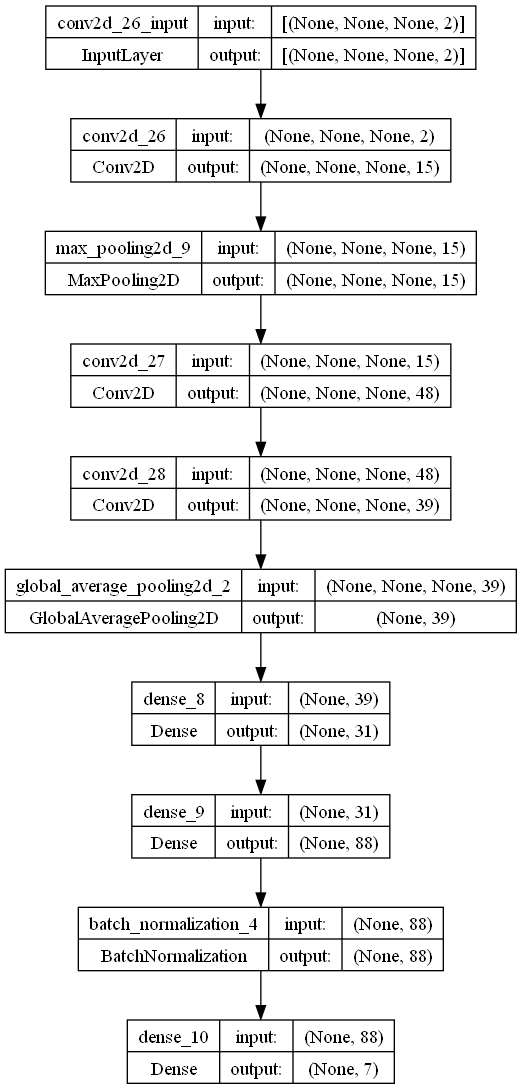

In [45]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [55]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [56]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [57]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [58]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

def adaptive_learning_rate(epoch):
    initial_lr = 0.001
    final_lr = 0.00001  # Updated final learning rate
    start_decay_epoch = 200
    end_decay_epoch = 1000
    
    if epoch < start_decay_epoch:
        return initial_lr
    elif epoch >= start_decay_epoch and epoch <= end_decay_epoch:
        lr_range = initial_lr - final_lr
        decay_epochs = end_decay_epoch - start_decay_epoch
        decay_per_epoch = lr_range / decay_epochs
        return initial_lr - (epoch - start_decay_epoch) * decay_per_epoch
    else:
        return final_lr

In [59]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(adaptive_learning_rate)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 3s 33ms/step - loss: 8.1368 - a_1: 2.8361 - a_2: 2.8688 - b_1: 2.1964 - b_2: 2.9021 - d_1: 1.2474 - d_2: 1.2843 - n: 2.1966 - mean_metric: 0.5119 - val_loss: 8.3193 - val_a_1: 2.7123 - val_a_2: 2.7549 - val_b_1: 2.6126 - val_b_2: 2.7871 - val_d_1: 2.0581 - val_d_2: 2.3731 - val_n: 1.5238 - val_mean_metric: 0.5568 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 2s 31ms/step - loss: 6.1082 - a_1: 2.7191 - a_2: 2.7696 - b_1: 1.4583 - b_2: 2.7849 - d_1: 0.8599 - d_2: 0.9500 - n: 1.6086 - mean_metric: 0.4335 - val_loss: 7.9924 - val_a_1: 2.6805 - val_a_2: 2.7302 - val_b_1: 2.9287 - val_b_2: 2.7890 - val_d_1: 1.6527 - val_d_2: 1.9151 - val_n: 1.4832 - val_mean_metric: 0.5355 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 2s 30ms/step - loss: 5.6417 - a_1: 2.6450 - a_2: 2.6928 - b_1: 1.2433 - b_2: 2.7668 - d_1: 0.7976 - d_2: 0.8498 - n: 1.5029 - mean_metric: 0.4120 - val_loss: 8.3351 - val_a_1: 2.6619

70/70 [==============================] - 2s 30ms/step - loss: 2.9560 - a_1: 1.1822 - a_2: 1.2359 - b_1: 0.8221 - b_2: 2.7226 - d_1: 0.6265 - d_2: 0.6146 - n: 1.0445 - mean_metric: 0.2720 - val_loss: 3.2914 - val_a_1: 1.6220 - val_a_2: 1.5398 - val_b_1: 0.7052 - val_b_2: 2.8203 - val_d_1: 0.3963 - val_d_2: 0.3411 - val_n: 1.0188 - val_mean_metric: 0.2797 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 2s 31ms/step - loss: 2.8751 - a_1: 1.1423 - a_2: 1.1790 - b_1: 0.8198 - b_2: 2.7217 - d_1: 0.5915 - d_2: 0.6166 - n: 1.0008 - mean_metric: 0.2661 - val_loss: 3.0051 - val_a_1: 1.2529 - val_a_2: 1.0799 - val_b_1: 0.7771 - val_b_2: 2.8128 - val_d_1: 0.3880 - val_d_2: 0.5990 - val_n: 1.3571 - val_mean_metric: 0.2737 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 2s 31ms/step - loss: 2.8589 - a_1: 1.1531 - a_2: 1.1730 - b_1: 0.8052 - b_2: 2.7243 - d_1: 0.6236 - d_2: 0.6093 - n: 0.9533 - mean_metric: 0.2652 - val_loss: 2.9697 - val_a_1: 0.9387 - val_a_2:

70/70 [==============================] - 2s 30ms/step - loss: 2.4847 - a_1: 0.9831 - a_2: 0.9910 - b_1: 0.7271 - b_2: 2.7092 - d_1: 0.5605 - d_2: 0.5474 - n: 0.5831 - mean_metric: 0.2341 - val_loss: 2.7390 - val_a_1: 1.2602 - val_a_2: 1.2990 - val_b_1: 0.6235 - val_b_2: 2.8021 - val_d_1: 0.3093 - val_d_2: 0.3718 - val_n: 0.4932 - val_mean_metric: 0.2371 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.4854 - a_1: 0.9645 - a_2: 0.9915 - b_1: 0.7183 - b_2: 2.7104 - d_1: 0.5411 - d_2: 0.5666 - n: 0.5844 - mean_metric: 0.2333 - val_loss: 2.3867 - val_a_1: 0.8563 - val_a_2: 1.0396 - val_b_1: 0.5280 - val_b_2: 2.8056 - val_d_1: 0.4441 - val_d_2: 0.3427 - val_n: 0.3914 - val_mean_metric: 0.2122 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.4738 - a_1: 0.9551 - a_2: 0.9830 - b_1: 0.7260 - b_2: 2.7100 - d_1: 0.5516 - d_2: 0.5586 - n: 0.5742 - mean_metric: 0.2328 - val_loss: 2.3175 - val_a_1: 0.7901 - val_a_2:

70/70 [==============================] - 2s 30ms/step - loss: 2.3189 - a_1: 0.8835 - a_2: 0.9264 - b_1: 0.6348 - b_2: 2.7110 - d_1: 0.4843 - d_2: 0.4741 - n: 0.4821 - mean_metric: 0.2175 - val_loss: 2.7876 - val_a_1: 1.2664 - val_a_2: 1.3037 - val_b_1: 0.6073 - val_b_2: 2.8036 - val_d_1: 0.8139 - val_d_2: 0.3590 - val_n: 0.4130 - val_mean_metric: 0.2506 - lr: 0.0010
Epoch 128/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.3689 - a_1: 0.9086 - a_2: 0.9744 - b_1: 0.6350 - b_2: 2.7115 - d_1: 0.4969 - d_2: 0.4844 - n: 0.5086 - mean_metric: 0.2215 - val_loss: 2.4882 - val_a_1: 0.8536 - val_a_2: 1.0591 - val_b_1: 0.6002 - val_b_2: 2.7994 - val_d_1: 0.5081 - val_d_2: 0.7269 - val_n: 0.3692 - val_mean_metric: 0.2290 - lr: 0.0010
Epoch 129/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.2724 - a_1: 0.8617 - a_2: 0.9027 - b_1: 0.6185 - b_2: 2.7058 - d_1: 0.4486 - d_2: 0.4607 - n: 0.4605 - mean_metric: 0.2130 - val_loss: 2.2520 - val_a_1: 0.7233 - val_a_

70/70 [==============================] - 2s 30ms/step - loss: 2.1979 - a_1: 0.8009 - a_2: 0.8723 - b_1: 0.5851 - b_2: 2.7094 - d_1: 0.4195 - d_2: 0.4096 - n: 0.4152 - mean_metric: 0.2048 - val_loss: 2.2206 - val_a_1: 0.7697 - val_a_2: 0.8927 - val_b_1: 0.5463 - val_b_2: 2.7969 - val_d_1: 0.4167 - val_d_2: 0.3650 - val_n: 0.3056 - val_mean_metric: 0.2018 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.1817 - a_1: 0.7806 - a_2: 0.8596 - b_1: 0.6007 - b_2: 2.7075 - d_1: 0.4241 - d_2: 0.3963 - n: 0.4192 - mean_metric: 0.2041 - val_loss: 2.3359 - val_a_1: 0.7210 - val_a_2: 1.0183 - val_b_1: 0.4989 - val_b_2: 2.7960 - val_d_1: 0.6210 - val_d_2: 0.5421 - val_n: 0.4402 - val_mean_metric: 0.2199 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 2s 31ms/step - loss: 2.1969 - a_1: 0.8173 - a_2: 0.8668 - b_1: 0.5829 - b_2: 2.7066 - d_1: 0.4405 - d_2: 0.4053 - n: 0.4134 - mean_metric: 0.2055 - val_loss: 2.4414 - val_a_1: 0.9243 - val_a_

70/70 [==============================] - 2s 30ms/step - loss: 2.1280 - a_1: 0.7752 - a_2: 0.8173 - b_1: 0.5409 - b_2: 2.7002 - d_1: 0.3862 - d_2: 0.3819 - n: 0.3715 - mean_metric: 0.1970 - val_loss: 2.5140 - val_a_1: 1.0914 - val_a_2: 1.0729 - val_b_1: 0.4867 - val_b_2: 2.8001 - val_d_1: 0.5170 - val_d_2: 0.4760 - val_n: 0.3571 - val_mean_metric: 0.2253 - lr: 9.8762e-04
Epoch 212/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.1352 - a_1: 0.7866 - a_2: 0.8266 - b_1: 0.5470 - b_2: 2.7050 - d_1: 0.3744 - d_2: 0.4034 - n: 0.3814 - mean_metric: 0.1986 - val_loss: 2.8171 - val_a_1: 1.2117 - val_a_2: 1.1084 - val_b_1: 0.5847 - val_b_2: 2.8139 - val_d_1: 0.7927 - val_d_2: 0.7538 - val_n: 0.3657 - val_mean_metric: 0.2526 - lr: 9.8639e-04
Epoch 213/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.1344 - a_1: 0.7736 - a_2: 0.8251 - b_1: 0.5478 - b_2: 2.6985 - d_1: 0.3782 - d_2: 0.3862 - n: 0.3793 - mean_metric: 0.1975 - val_loss: 2.3254 - val_a_1: 0.7618 

70/70 [==============================] - 2s 31ms/step - loss: 2.0739 - a_1: 0.7362 - a_2: 0.7680 - b_1: 0.5380 - b_2: 2.6905 - d_1: 0.3791 - d_2: 0.3840 - n: 0.3554 - mean_metric: 0.1930 - val_loss: 2.1143 - val_a_1: 0.6614 - val_a_2: 0.6991 - val_b_1: 0.5142 - val_b_2: 2.7932 - val_d_1: 0.3106 - val_d_2: 0.3548 - val_n: 0.3760 - val_mean_metric: 0.1891 - lr: 9.3565e-04
Epoch 254/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.0974 - a_1: 0.7343 - a_2: 0.8061 - b_1: 0.5326 - b_2: 2.6969 - d_1: 0.3606 - d_2: 0.3789 - n: 0.3544 - mean_metric: 0.1934 - val_loss: 3.4314 - val_a_1: 1.6765 - val_a_2: 1.3187 - val_b_1: 0.5688 - val_b_2: 2.8142 - val_d_1: 0.9599 - val_d_2: 1.4036 - val_n: 0.6419 - val_mean_metric: 0.3107 - lr: 9.3441e-04
Epoch 255/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.3277 - a_1: 0.9274 - a_2: 0.9621 - b_1: 0.5903 - b_2: 2.7067 - d_1: 0.4060 - d_2: 0.4179 - n: 0.5325 - mean_metric: 0.2156 - val_loss: 2.7581 - val_a_1: 1.0801 

70/70 [==============================] - 2s 31ms/step - loss: 2.0212 - a_1: 0.7082 - a_2: 0.7426 - b_1: 0.5164 - b_2: 2.6837 - d_1: 0.3382 - d_2: 0.3647 - n: 0.3178 - mean_metric: 0.1870 - val_loss: 2.3915 - val_a_1: 0.7214 - val_a_2: 0.7626 - val_b_1: 0.5399 - val_b_2: 2.8087 - val_d_1: 0.9104 - val_d_2: 0.8575 - val_n: 0.2321 - val_mean_metric: 0.2262 - lr: 8.8368e-04
Epoch 296/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.0235 - a_1: 0.7035 - a_2: 0.7476 - b_1: 0.4972 - b_2: 2.6895 - d_1: 0.3654 - d_2: 0.3650 - n: 0.3241 - mean_metric: 0.1877 - val_loss: 2.3887 - val_a_1: 0.9472 - val_a_2: 0.8560 - val_b_1: 0.5192 - val_b_2: 2.8096 - val_d_1: 0.6171 - val_d_2: 0.8059 - val_n: 0.2558 - val_mean_metric: 0.2255 - lr: 8.8244e-04
Epoch 297/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.0494 - a_1: 0.7090 - a_2: 0.7582 - b_1: 0.5276 - b_2: 2.6869 - d_1: 0.3732 - d_2: 0.3718 - n: 0.3346 - mean_metric: 0.1900 - val_loss: 2.2419 - val_a_1: 0.9046 

70/70 [==============================] - 2s 30ms/step - loss: 2.0245 - a_1: 0.6929 - a_2: 0.7506 - b_1: 0.5167 - b_2: 2.6810 - d_1: 0.3678 - d_2: 0.3636 - n: 0.3283 - mean_metric: 0.1879 - val_loss: 2.3941 - val_a_1: 1.2168 - val_a_2: 1.0860 - val_b_1: 0.5445 - val_b_2: 2.8069 - val_d_1: 0.5332 - val_d_2: 0.4123 - val_n: 0.3136 - val_mean_metric: 0.2289 - lr: 8.3170e-04
Epoch 338/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.0222 - a_1: 0.7237 - a_2: 0.7481 - b_1: 0.5157 - b_2: 2.6805 - d_1: 0.3244 - d_2: 0.3621 - n: 0.3310 - mean_metric: 0.1874 - val_loss: 2.4567 - val_a_1: 0.9389 - val_a_2: 0.8145 - val_b_1: 0.5534 - val_b_2: 2.8109 - val_d_1: 0.8307 - val_d_2: 0.6392 - val_n: 0.2951 - val_mean_metric: 0.2279 - lr: 8.3046e-04
Epoch 339/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.9917 - a_1: 0.6792 - a_2: 0.7157 - b_1: 0.5223 - b_2: 2.6774 - d_1: 0.3308 - d_2: 0.3409 - n: 0.3090 - mean_metric: 0.1838 - val_loss: 2.1752 - val_a_1: 0.8674 

70/70 [==============================] - 2s 30ms/step - loss: 2.0239 - a_1: 0.7345 - a_2: 0.7403 - b_1: 0.5141 - b_2: 2.6729 - d_1: 0.3328 - d_2: 0.3725 - n: 0.3310 - mean_metric: 0.1879 - val_loss: 2.4025 - val_a_1: 1.2683 - val_a_2: 0.8177 - val_b_1: 0.6944 - val_b_2: 2.8231 - val_d_1: 0.4814 - val_d_2: 0.4713 - val_n: 0.2178 - val_mean_metric: 0.2243 - lr: 7.7972e-04
Epoch 380/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.0025 - a_1: 0.6798 - a_2: 0.7281 - b_1: 0.5134 - b_2: 2.6724 - d_1: 0.3387 - d_2: 0.3746 - n: 0.3160 - mean_metric: 0.1854 - val_loss: 2.4616 - val_a_1: 1.1196 - val_a_2: 0.7905 - val_b_1: 0.5610 - val_b_2: 2.8231 - val_d_1: 0.6540 - val_d_2: 0.8020 - val_n: 0.2639 - val_mean_metric: 0.2322 - lr: 7.7849e-04
Epoch 381/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.0267 - a_1: 0.7270 - a_2: 0.7487 - b_1: 0.5097 - b_2: 2.6722 - d_1: 0.3514 - d_2: 0.3772 - n: 0.3190 - mean_metric: 0.1881 - val_loss: 2.6796 - val_a_1: 1.4845 

70/70 [==============================] - 2s 30ms/step - loss: 1.9930 - a_1: 0.7044 - a_2: 0.7267 - b_1: 0.5046 - b_2: 2.6624 - d_1: 0.3325 - d_2: 0.3683 - n: 0.3176 - mean_metric: 0.1852 - val_loss: 2.3358 - val_a_1: 1.0786 - val_a_2: 0.9872 - val_b_1: 0.6211 - val_b_2: 2.8072 - val_d_1: 0.6067 - val_d_2: 0.3214 - val_n: 0.3439 - val_mean_metric: 0.2240 - lr: 7.2775e-04
Epoch 422/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.9759 - a_1: 0.6763 - a_2: 0.7184 - b_1: 0.4958 - b_2: 2.6644 - d_1: 0.3289 - d_2: 0.3537 - n: 0.3053 - mean_metric: 0.1827 - val_loss: 2.5741 - val_a_1: 1.2834 - val_a_2: 0.9656 - val_b_1: 0.6353 - val_b_2: 2.8274 - val_d_1: 0.4966 - val_d_2: 0.6670 - val_n: 0.2427 - val_mean_metric: 0.2356 - lr: 7.2651e-04
Epoch 423/1000
70/70 [==============================] - 2s 30ms/step - loss: 2.0065 - a_1: 0.7053 - a_2: 0.7393 - b_1: 0.5066 - b_2: 2.6665 - d_1: 0.3525 - d_2: 0.3492 - n: 0.3100 - mean_metric: 0.1856 - val_loss: 2.2755 - val_a_1: 0.9965 

70/70 [==============================] - 2s 30ms/step - loss: 1.9744 - a_1: 0.6813 - a_2: 0.7221 - b_1: 0.5145 - b_2: 2.6510 - d_1: 0.3320 - d_2: 0.3333 - n: 0.3174 - mean_metric: 0.1831 - val_loss: 2.7953 - val_a_1: 1.2801 - val_a_2: 0.8847 - val_b_1: 0.7165 - val_b_2: 2.8257 - val_d_1: 1.2255 - val_d_2: 0.5765 - val_n: 0.2224 - val_mean_metric: 0.2559 - lr: 6.7577e-04
Epoch 464/1000
70/70 [==============================] - 2s 35ms/step - loss: 1.9439 - a_1: 0.6777 - a_2: 0.6986 - b_1: 0.4809 - b_2: 2.6484 - d_1: 0.3652 - d_2: 0.3398 - n: 0.3072 - mean_metric: 0.1820 - val_loss: 2.2641 - val_a_1: 0.8613 - val_a_2: 0.8843 - val_b_1: 0.5243 - val_b_2: 2.8070 - val_d_1: 0.5199 - val_d_2: 0.6348 - val_n: 0.2857 - val_mean_metric: 0.2158 - lr: 6.7454e-04
Epoch 465/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.9323 - a_1: 0.6496 - a_2: 0.6872 - b_1: 0.4780 - b_2: 2.6504 - d_1: 0.3373 - d_2: 0.3191 - n: 0.2966 - mean_metric: 0.1787 - val_loss: 2.9715 - val_a_1: 1.5725 

70/70 [==============================] - 2s 30ms/step - loss: 1.9177 - a_1: 0.6334 - a_2: 0.6928 - b_1: 0.4729 - b_2: 2.6434 - d_1: 0.3185 - d_2: 0.3374 - n: 0.2989 - mean_metric: 0.1780 - val_loss: 2.2835 - val_a_1: 0.8908 - val_a_2: 1.0531 - val_b_1: 0.5554 - val_b_2: 2.8206 - val_d_1: 0.4961 - val_d_2: 0.4325 - val_n: 0.2260 - val_mean_metric: 0.2143 - lr: 6.2380e-04
Epoch 506/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.9224 - a_1: 0.6453 - a_2: 0.6653 - b_1: 0.4819 - b_2: 2.6493 - d_1: 0.3305 - d_2: 0.3280 - n: 0.3047 - mean_metric: 0.1783 - val_loss: 2.2936 - val_a_1: 1.0698 - val_a_2: 0.6989 - val_b_1: 0.5795 - val_b_2: 2.8103 - val_d_1: 0.5511 - val_d_2: 0.5338 - val_n: 0.2390 - val_mean_metric: 0.2146 - lr: 6.2256e-04
Epoch 507/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.9146 - a_1: 0.6597 - a_2: 0.6639 - b_1: 0.4816 - b_2: 2.6424 - d_1: 0.3097 - d_2: 0.3346 - n: 0.2950 - mean_metric: 0.1776 - val_loss: 2.1961 - val_a_1: 0.8261 

70/70 [==============================] - 2s 30ms/step - loss: 1.9298 - a_1: 0.6705 - a_2: 0.6770 - b_1: 0.4960 - b_2: 2.6332 - d_1: 0.3221 - d_2: 0.3233 - n: 0.3062 - mean_metric: 0.1790 - val_loss: 2.2990 - val_a_1: 1.1456 - val_a_2: 0.8899 - val_b_1: 0.5198 - val_b_2: 2.8181 - val_d_1: 0.3797 - val_d_2: 0.4743 - val_n: 0.1760 - val_mean_metric: 0.2121 - lr: 5.7183e-04
Epoch 548/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.9311 - a_1: 0.6797 - a_2: 0.6782 - b_1: 0.4877 - b_2: 2.6382 - d_1: 0.3245 - d_2: 0.3314 - n: 0.3071 - mean_metric: 0.1796 - val_loss: 2.3636 - val_a_1: 1.0777 - val_a_2: 0.9291 - val_b_1: 0.6667 - val_b_2: 2.8205 - val_d_1: 0.4704 - val_d_2: 0.5094 - val_n: 0.2129 - val_mean_metric: 0.2214 - lr: 5.7059e-04
Epoch 549/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.8874 - a_1: 0.6532 - a_2: 0.6565 - b_1: 0.4676 - b_2: 2.6225 - d_1: 0.3062 - d_2: 0.3184 - n: 0.2942 - mean_metric: 0.1754 - val_loss: 2.3597 - val_a_1: 1.2655 

70/70 [==============================] - 2s 30ms/step - loss: 1.8948 - a_1: 0.6405 - a_2: 0.6592 - b_1: 0.4888 - b_2: 2.6257 - d_1: 0.3142 - d_2: 0.3036 - n: 0.2835 - mean_metric: 0.1753 - val_loss: 2.5992 - val_a_1: 1.0363 - val_a_2: 1.0036 - val_b_1: 0.5938 - val_b_2: 2.8080 - val_d_1: 0.6050 - val_d_2: 1.0762 - val_n: 0.2665 - val_mean_metric: 0.2446 - lr: 5.1985e-04
Epoch 590/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.8981 - a_1: 0.6433 - a_2: 0.6614 - b_1: 0.4542 - b_2: 2.6357 - d_1: 0.3045 - d_2: 0.3243 - n: 0.2951 - mean_metric: 0.1754 - val_loss: 2.2388 - val_a_1: 0.8299 - val_a_2: 0.7155 - val_b_1: 0.5318 - val_b_2: 2.8322 - val_d_1: 0.4579 - val_d_2: 0.4757 - val_n: 0.2404 - val_mean_metric: 0.2015 - lr: 5.1861e-04
Epoch 591/1000
70/70 [==============================] - 2s 34ms/step - loss: 1.9222 - a_1: 0.6607 - a_2: 0.7005 - b_1: 0.4705 - b_2: 2.6334 - d_1: 0.3282 - d_2: 0.3387 - n: 0.3051 - mean_metric: 0.1792 - val_loss: 2.2321 - val_a_1: 0.8867 

70/70 [==============================] - 2s 34ms/step - loss: 1.8907 - a_1: 0.6461 - a_2: 0.6830 - b_1: 0.4674 - b_2: 2.6238 - d_1: 0.3193 - d_2: 0.3307 - n: 0.2863 - mean_metric: 0.1766 - val_loss: 2.2051 - val_a_1: 1.0109 - val_a_2: 0.6642 - val_b_1: 0.5797 - val_b_2: 2.8301 - val_d_1: 0.3397 - val_d_2: 0.3267 - val_n: 0.1901 - val_mean_metric: 0.1967 - lr: 4.6788e-04
Epoch 632/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.8676 - a_1: 0.6340 - a_2: 0.6444 - b_1: 0.4634 - b_2: 2.6189 - d_1: 0.2934 - d_2: 0.3010 - n: 0.2837 - mean_metric: 0.1727 - val_loss: 2.3083 - val_a_1: 1.0002 - val_a_2: 0.7516 - val_b_1: 0.5923 - val_b_2: 2.8279 - val_d_1: 0.4184 - val_d_2: 0.3303 - val_n: 0.1723 - val_mean_metric: 0.2018 - lr: 4.6664e-04
Epoch 633/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.8948 - a_1: 0.6341 - a_2: 0.6611 - b_1: 0.4819 - b_2: 2.6270 - d_1: 0.3069 - d_2: 0.3027 - n: 0.2952 - mean_metric: 0.1751 - val_loss: 2.6105 - val_a_1: 1.5350 

70/70 [==============================] - 2s 30ms/step - loss: 1.8440 - a_1: 0.5998 - a_2: 0.6446 - b_1: 0.4411 - b_2: 2.6114 - d_1: 0.2891 - d_2: 0.3138 - n: 0.2803 - mean_metric: 0.1708 - val_loss: 2.3031 - val_a_1: 1.0433 - val_a_2: 0.7812 - val_b_1: 0.6477 - val_b_2: 2.8287 - val_d_1: 0.4270 - val_d_2: 0.4934 - val_n: 0.1752 - val_mean_metric: 0.2118 - lr: 4.1590e-04
Epoch 674/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.8741 - a_1: 0.6601 - a_2: 0.6359 - b_1: 0.4727 - b_2: 2.6085 - d_1: 0.2984 - d_2: 0.3058 - n: 0.2966 - mean_metric: 0.1740 - val_loss: 2.2376 - val_a_1: 0.7837 - val_a_2: 0.7167 - val_b_1: 0.5736 - val_b_2: 2.8318 - val_d_1: 0.3664 - val_d_2: 0.4420 - val_n: 0.2929 - val_mean_metric: 0.1990 - lr: 4.1466e-04
Epoch 675/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.8536 - a_1: 0.6209 - a_2: 0.6270 - b_1: 0.4663 - b_2: 2.6100 - d_1: 0.3075 - d_2: 0.3007 - n: 0.2886 - mean_metric: 0.1722 - val_loss: 2.3524 - val_a_1: 1.0406 

70/70 [==============================] - 2s 30ms/step - loss: 1.8396 - a_1: 0.6142 - a_2: 0.6193 - b_1: 0.4720 - b_2: 2.6020 - d_1: 0.2787 - d_2: 0.2896 - n: 0.2827 - mean_metric: 0.1701 - val_loss: 2.3954 - val_a_1: 1.2872 - val_a_2: 0.8004 - val_b_1: 0.6266 - val_b_2: 2.8219 - val_d_1: 0.5717 - val_d_2: 0.4266 - val_n: 0.2066 - val_mean_metric: 0.2232 - lr: 3.6393e-04
Epoch 716/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.8375 - a_1: 0.6165 - a_2: 0.6255 - b_1: 0.4496 - b_2: 2.6098 - d_1: 0.2971 - d_2: 0.3074 - n: 0.2866 - mean_metric: 0.1712 - val_loss: 2.3372 - val_a_1: 0.8712 - val_a_2: 1.0361 - val_b_1: 0.5365 - val_b_2: 2.8384 - val_d_1: 0.3977 - val_d_2: 0.7494 - val_n: 0.1776 - val_mean_metric: 0.2187 - lr: 3.6269e-04
Epoch 717/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.8339 - a_1: 0.6024 - a_2: 0.6329 - b_1: 0.4604 - b_2: 2.5986 - d_1: 0.2918 - d_2: 0.2795 - n: 0.2840 - mean_metric: 0.1698 - val_loss: 2.3090 - val_a_1: 1.0154 

70/70 [==============================] - 2s 30ms/step - loss: 1.8209 - a_1: 0.6055 - a_2: 0.6333 - b_1: 0.4429 - b_2: 2.5965 - d_1: 0.2811 - d_2: 0.2801 - n: 0.2749 - mean_metric: 0.1686 - val_loss: 2.3363 - val_a_1: 0.8071 - val_a_2: 0.8384 - val_b_1: 0.5349 - val_b_2: 2.8429 - val_d_1: 0.4451 - val_d_2: 0.8973 - val_n: 0.1817 - val_mean_metric: 0.2168 - lr: 3.1195e-04
Epoch 758/1000
70/70 [==============================] - 2s 34ms/step - loss: 1.8195 - a_1: 0.5818 - a_2: 0.6266 - b_1: 0.4382 - b_2: 2.6001 - d_1: 0.3065 - d_2: 0.2851 - n: 0.2794 - mean_metric: 0.1687 - val_loss: 2.2401 - val_a_1: 0.8769 - val_a_2: 0.8507 - val_b_1: 0.5586 - val_b_2: 2.8347 - val_d_1: 0.4411 - val_d_2: 0.5374 - val_n: 0.1667 - val_mean_metric: 0.2075 - lr: 3.1071e-04
Epoch 759/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.8461 - a_1: 0.6242 - a_2: 0.6551 - b_1: 0.4570 - b_2: 2.5901 - d_1: 0.3057 - d_2: 0.2922 - n: 0.3036 - mean_metric: 0.1724 - val_loss: 2.2858 - val_a_1: 1.0475 

70/70 [==============================] - 2s 30ms/step - loss: 1.8151 - a_1: 0.6011 - a_2: 0.6121 - b_1: 0.4475 - b_2: 2.5926 - d_1: 0.3019 - d_2: 0.2997 - n: 0.2743 - mean_metric: 0.1692 - val_loss: 2.3080 - val_a_1: 0.9638 - val_a_2: 1.0051 - val_b_1: 0.5317 - val_b_2: 2.8387 - val_d_1: 0.4121 - val_d_2: 0.5483 - val_n: 0.1905 - val_mean_metric: 0.2149 - lr: 2.5998e-04
Epoch 800/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.8280 - a_1: 0.6115 - a_2: 0.6267 - b_1: 0.4388 - b_2: 2.5964 - d_1: 0.2935 - d_2: 0.2975 - n: 0.2839 - mean_metric: 0.1697 - val_loss: 2.3879 - val_a_1: 1.2272 - val_a_2: 0.9901 - val_b_1: 0.5197 - val_b_2: 2.8291 - val_d_1: 0.5115 - val_d_2: 0.5008 - val_n: 0.2035 - val_mean_metric: 0.2246 - lr: 2.5874e-04
Epoch 801/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.7935 - a_1: 0.5791 - a_2: 0.6051 - b_1: 0.4414 - b_2: 2.5807 - d_1: 0.2803 - d_2: 0.3064 - n: 0.2808 - mean_metric: 0.1673 - val_loss: 2.3880 - val_a_1: 1.0731 

70/70 [==============================] - 2s 30ms/step - loss: 1.7969 - a_1: 0.5957 - a_2: 0.6001 - b_1: 0.4281 - b_2: 2.5785 - d_1: 0.2904 - d_2: 0.2853 - n: 0.2808 - mean_metric: 0.1668 - val_loss: 2.2766 - val_a_1: 0.7994 - val_a_2: 0.7744 - val_b_1: 0.5619 - val_b_2: 2.8395 - val_d_1: 0.4910 - val_d_2: 0.7622 - val_n: 0.1808 - val_mean_metric: 0.2122 - lr: 2.0800e-04
Epoch 842/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.7809 - a_1: 0.5888 - a_2: 0.5941 - b_1: 0.4293 - b_2: 2.5720 - d_1: 0.2826 - d_2: 0.2908 - n: 0.2806 - mean_metric: 0.1661 - val_loss: 2.4107 - val_a_1: 0.7417 - val_a_2: 0.9699 - val_b_1: 0.6092 - val_b_2: 2.8386 - val_d_1: 0.8462 - val_d_2: 0.8041 - val_n: 0.1691 - val_mean_metric: 0.2310 - lr: 2.0676e-04
Epoch 843/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.7941 - a_1: 0.5724 - a_2: 0.6056 - b_1: 0.4432 - b_2: 2.5842 - d_1: 0.2815 - d_2: 0.2890 - n: 0.2722 - mean_metric: 0.1665 - val_loss: 2.3574 - val_a_1: 0.9317 

70/70 [==============================] - 2s 30ms/step - loss: 1.7586 - a_1: 0.5735 - a_2: 0.5816 - b_1: 0.4158 - b_2: 2.5673 - d_1: 0.2776 - d_2: 0.2700 - n: 0.2643 - mean_metric: 0.1632 - val_loss: 2.3084 - val_a_1: 1.0264 - val_a_2: 0.8341 - val_b_1: 0.5309 - val_b_2: 2.8432 - val_d_1: 0.4787 - val_d_2: 0.5421 - val_n: 0.2115 - val_mean_metric: 0.2142 - lr: 1.5602e-04
Epoch 884/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.7540 - a_1: 0.5746 - a_2: 0.5874 - b_1: 0.4224 - b_2: 2.5624 - d_1: 0.2585 - d_2: 0.2528 - n: 0.2767 - mean_metric: 0.1627 - val_loss: 2.3665 - val_a_1: 1.0690 - val_a_2: 0.8657 - val_b_1: 0.4916 - val_b_2: 2.8503 - val_d_1: 0.5420 - val_d_2: 0.7102 - val_n: 0.1674 - val_mean_metric: 0.2217 - lr: 1.5479e-04
Epoch 885/1000
70/70 [==============================] - 2s 34ms/step - loss: 1.7517 - a_1: 0.5664 - a_2: 0.5935 - b_1: 0.4310 - b_2: 2.5599 - d_1: 0.2786 - d_2: 0.2628 - n: 0.2730 - mean_metric: 0.1637 - val_loss: 2.3003 - val_a_1: 1.0431 

70/70 [==============================] - 2s 34ms/step - loss: 1.7250 - a_1: 0.5581 - a_2: 0.5706 - b_1: 0.4113 - b_2: 2.5425 - d_1: 0.2523 - d_2: 0.2541 - n: 0.2634 - mean_metric: 0.1600 - val_loss: 2.3146 - val_a_1: 0.9519 - val_a_2: 0.8523 - val_b_1: 0.5126 - val_b_2: 2.8543 - val_d_1: 0.5713 - val_d_2: 0.6058 - val_n: 0.1609 - val_mean_metric: 0.2155 - lr: 1.0405e-04
Epoch 926/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.7464 - a_1: 0.5533 - a_2: 0.5886 - b_1: 0.4156 - b_2: 2.5669 - d_1: 0.2681 - d_2: 0.2664 - n: 0.2652 - mean_metric: 0.1624 - val_loss: 2.3456 - val_a_1: 1.1167 - val_a_2: 0.8744 - val_b_1: 0.5035 - val_b_2: 2.8536 - val_d_1: 0.5694 - val_d_2: 0.5330 - val_n: 0.1560 - val_mean_metric: 0.2188 - lr: 1.0281e-04
Epoch 927/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.7299 - a_1: 0.5598 - a_2: 0.5803 - b_1: 0.4179 - b_2: 2.5500 - d_1: 0.2629 - d_2: 0.2556 - n: 0.2745 - mean_metric: 0.1616 - val_loss: 2.3157 - val_a_1: 1.0150 

70/70 [==============================] - 2s 30ms/step - loss: 1.7166 - a_1: 0.5488 - a_2: 0.5511 - b_1: 0.4041 - b_2: 2.5403 - d_1: 0.2522 - d_2: 0.2521 - n: 0.2574 - mean_metric: 0.1585 - val_loss: 2.2916 - val_a_1: 1.0240 - val_a_2: 0.8583 - val_b_1: 0.5219 - val_b_2: 2.8585 - val_d_1: 0.4440 - val_d_2: 0.5236 - val_n: 0.1411 - val_mean_metric: 0.2110 - lr: 5.2075e-05
Epoch 968/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.7230 - a_1: 0.5596 - a_2: 0.5495 - b_1: 0.4226 - b_2: 2.5478 - d_1: 0.2529 - d_2: 0.2611 - n: 0.2592 - mean_metric: 0.1600 - val_loss: 2.2876 - val_a_1: 1.0231 - val_a_2: 0.8811 - val_b_1: 0.5312 - val_b_2: 2.8611 - val_d_1: 0.4228 - val_d_2: 0.4729 - val_n: 0.1456 - val_mean_metric: 0.2099 - lr: 5.0838e-05
Epoch 969/1000
70/70 [==============================] - 2s 30ms/step - loss: 1.7139 - a_1: 0.5483 - a_2: 0.5607 - b_1: 0.4193 - b_2: 2.5440 - d_1: 0.2542 - d_2: 0.2461 - n: 0.2648 - mean_metric: 0.1595 - val_loss: 2.2744 - val_a_1: 0.9804 

In [60]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    campvectest, coefcampvectest)

63/63 [==============================] - 0s 4ms/step - loss: 2.2249 - a_1: 0.9900 - a_2: 0.8133 - b_1: 0.5112 - b_2: 2.8059 - d_1: 0.4256 - d_2: 0.5023 - n: 0.1477 - mean_metric: 0.2062


# Analizamos accuracy y loss

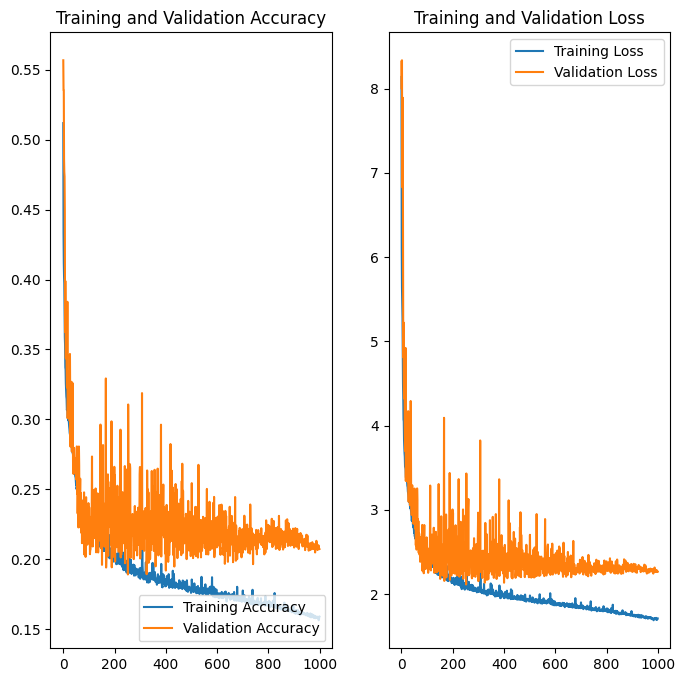

In [61]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

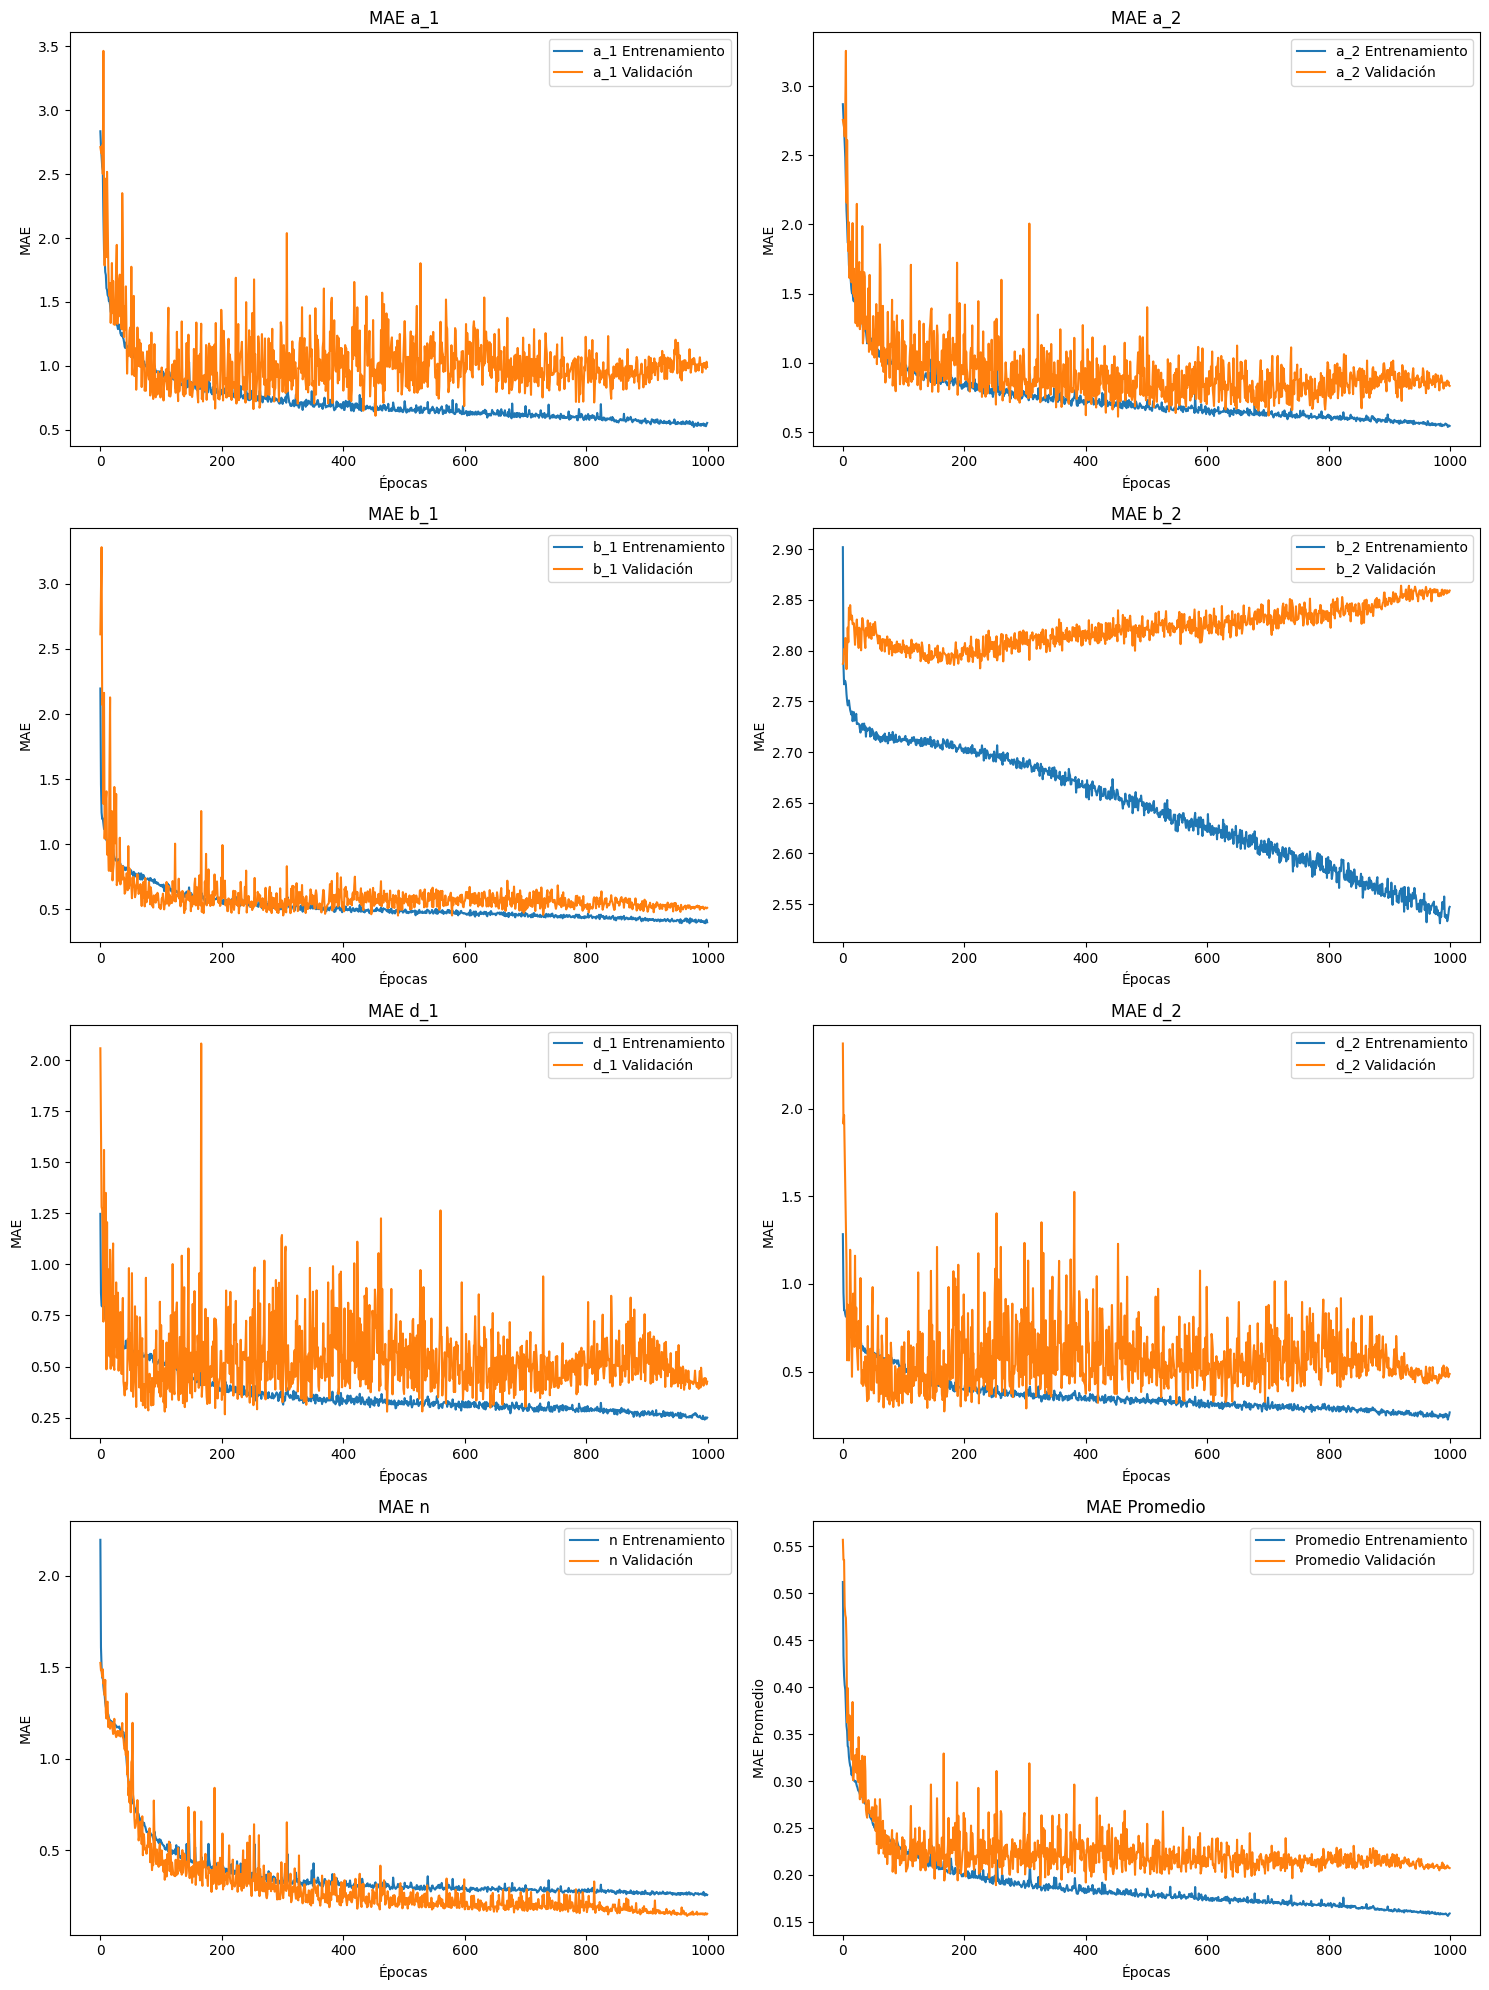

In [62]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [63]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    campvectest, coefcampvectest)

63/63 [==============================] - 0s 4ms/step - loss: 2.2249 - a_1: 0.9900 - a_2: 0.8133 - b_1: 0.5112 - b_2: 2.8059 - d_1: 0.4256 - d_2: 0.5023 - n: 0.1477 - mean_metric: 0.2062


In [64]:
predictions = model.predict(campvectest)

63/63 [==============================] - 0s 3ms/step


In [65]:
print(coefcampvectest[0,:])
print(predictions[0,:])
from sklearn.metrics import mean_absolute_error
print(np.sum(coefcampvectest, axis=-1))

mae1 = mean_absolute_error(coefcampvectest[0,:], predictions[0,:])
mae1

[ 7 10  7  2  3  4  3]
[5.765733  9.026989  6.8105316 5.898223  3.5835233 4.7340193 2.9323838]
[36 33 36 ... 37 24 39]


1.0971611908503942

In [66]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvectest, predictions)

# Calcula la desviación estándar del error
error = coefcampvectest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 0.8860650460899676, Desviación estándar del error: 1.4595263860680168, Error absoluto máximo: 7.286060094833374


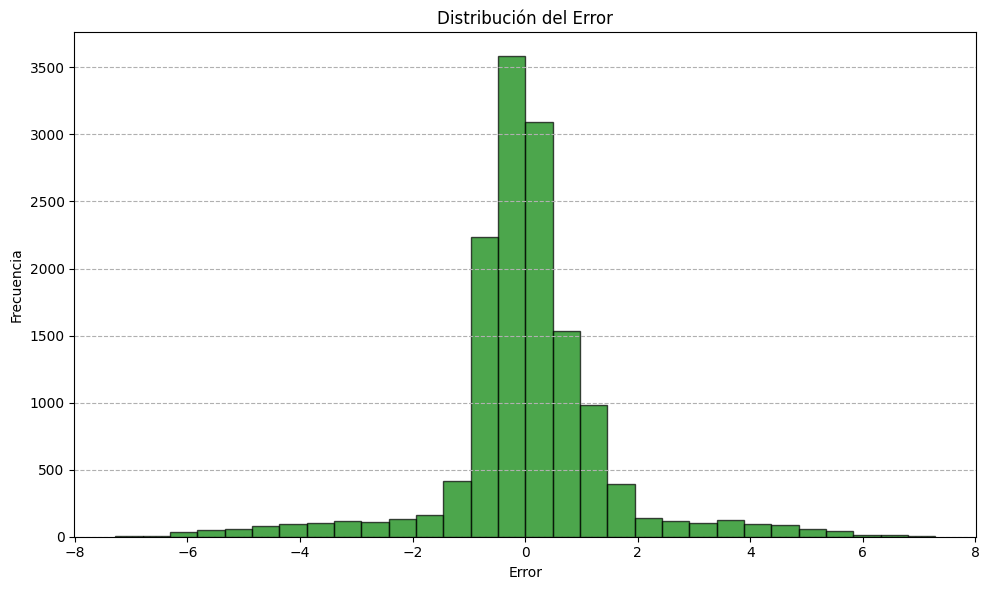

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [68]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefcampvectest - predictions)

# Calcula el error para cada dato
error = coefcampvectest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefcampvectest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.20909472454939965
Desviación estándar del error relativo: 0.1386444022681528
Error absoluto máximo relativo: 1.2915182146761153


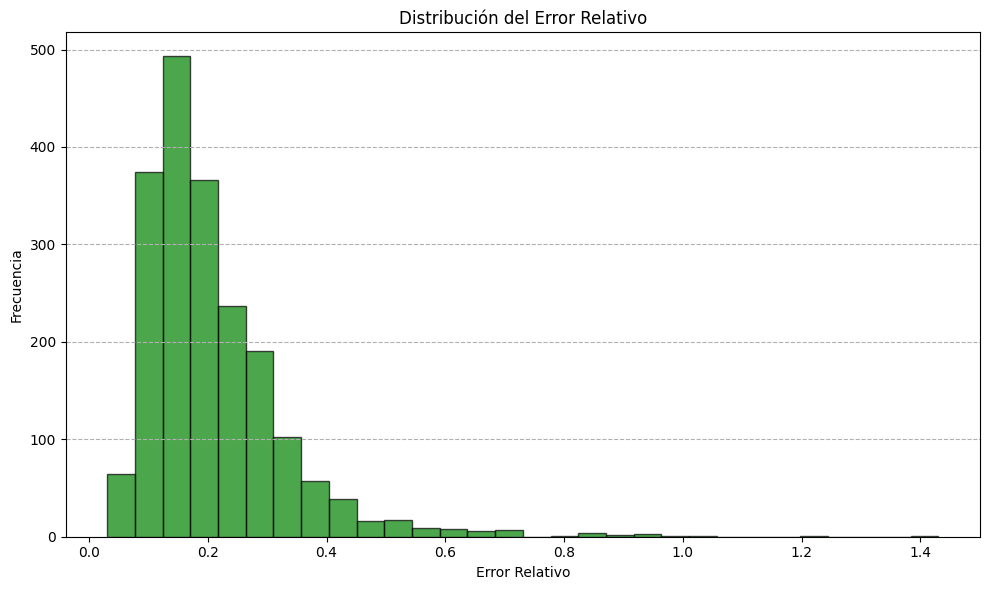

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()


# Guardamos los datos de Accuracy y Loss

In [70]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../Graficas/historyconvcampvec.csv', index=False)

# Guardamos el modelo

In [71]:
path_to_save = '../Modelos'

In [72]:
model.save(path_to_save + '/convolucionalcv.h5')

# Importamos el modelo

In [1]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [2]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [3]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../Modelos/convolucionalcv.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [76]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 20)
    y2 = np.linspace(y_range_neg, y_range_pos, 20)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[8, 1, 8, 3, 6, 8, 4]


In [77]:
campvecnone = campvec[None, :]
campvecnone = np.transpose(campvecnone, (0,2,3,1))

## Predecimos con los datos nuevos

In [78]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 70ms/step
[[10. 10. 10.  0. 10. 10.  0.]]


## Encontramos puntos de equilibro datos reales

In [79]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(1.990048314236581, 1.007492246253691)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

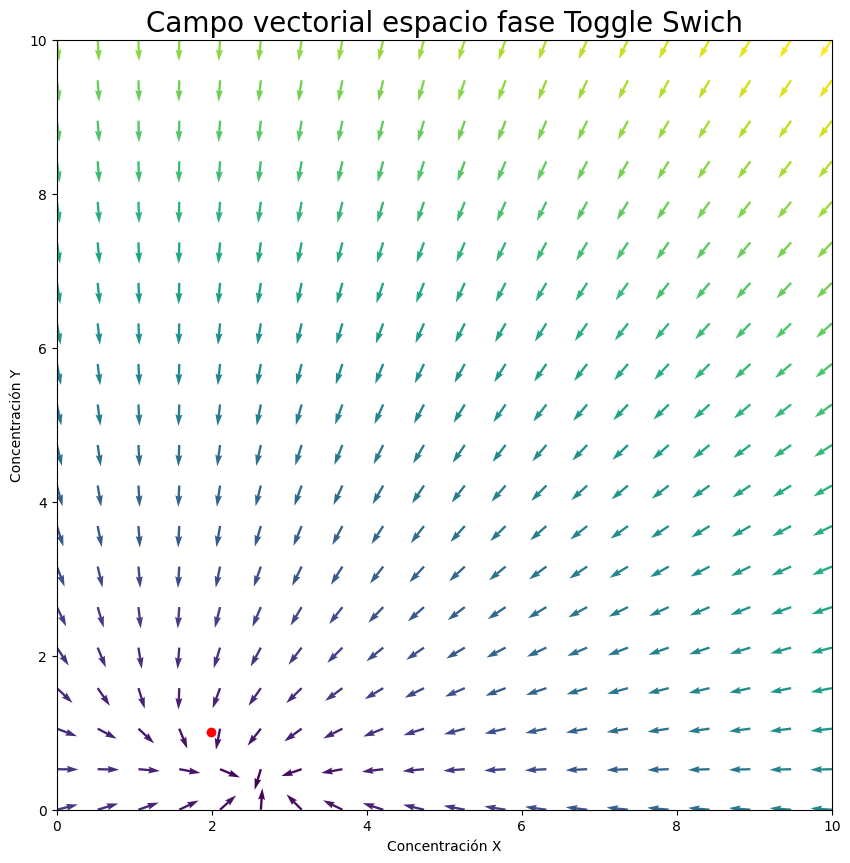

In [80]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 20)
y2 = np.linspace(0, 10, 20)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [81]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(1.5, 1.5)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

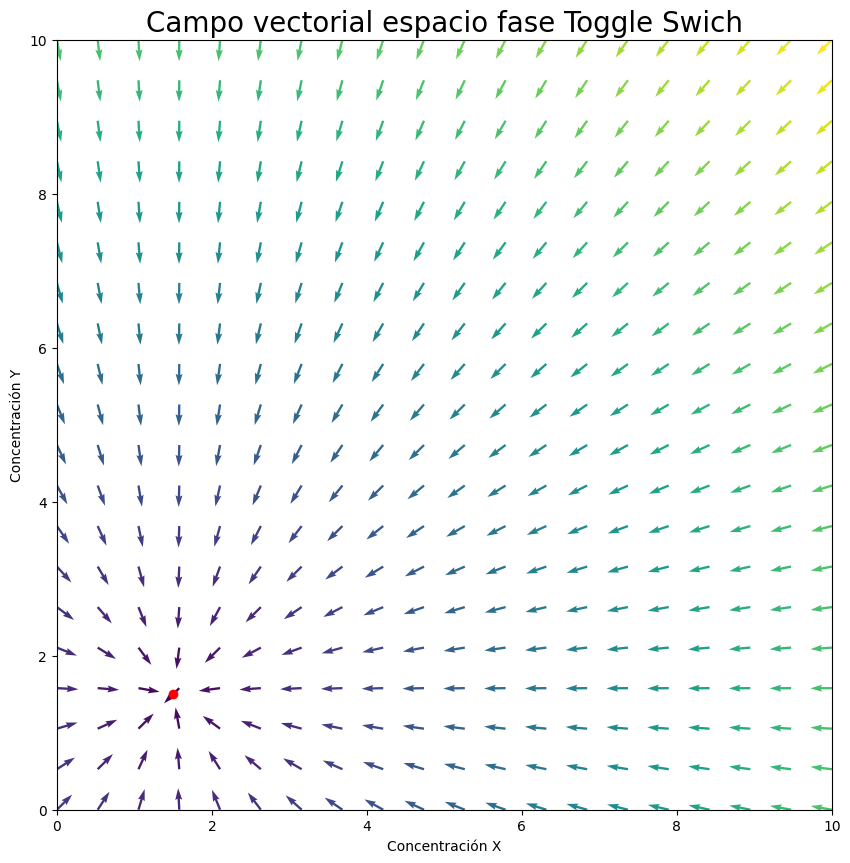

In [82]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 20)
y2pred = np.linspace(y_range_neg, y_range_pos, 20)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

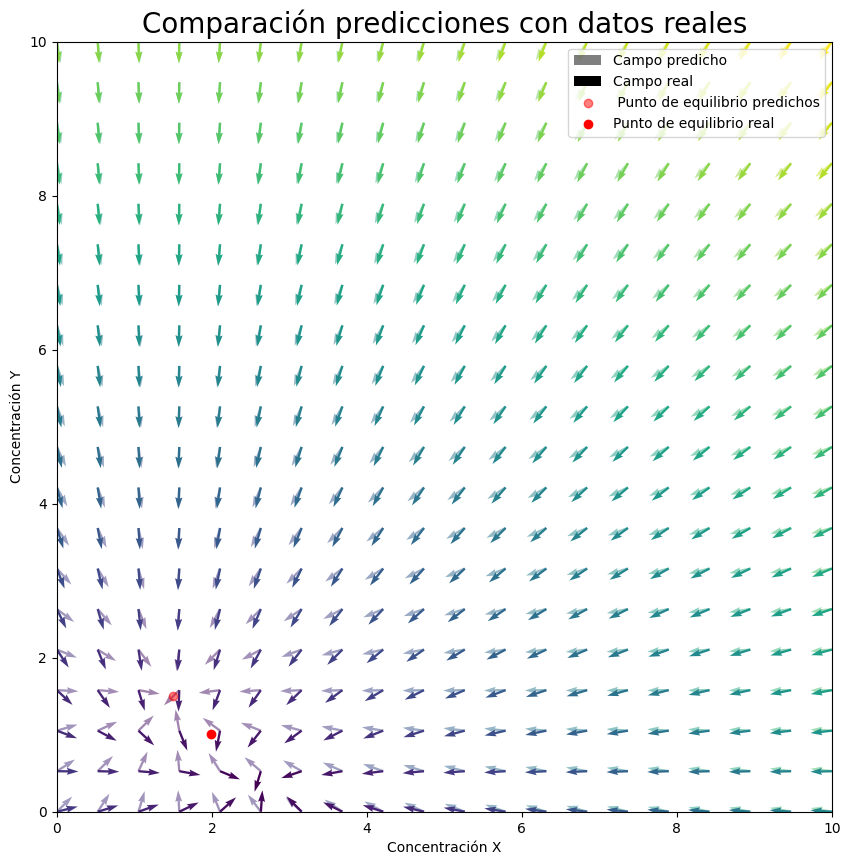

In [83]:
#%matplotlib qt
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5, label = "Campo predicho")

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1, label = "Campo real")

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5, label = " Punto de equilibrio predichos")
ax.scatter(x_values, y_values, color='red', alpha = 1, label = "Punto de equilibrio real")
ax.set_title('Comparación predicciones con datos reales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')
ax.legend(loc='upper right')  # Agregar leyenda a la gráfica
plt.show()

## Graficamos las diferencias

59.579554782332124


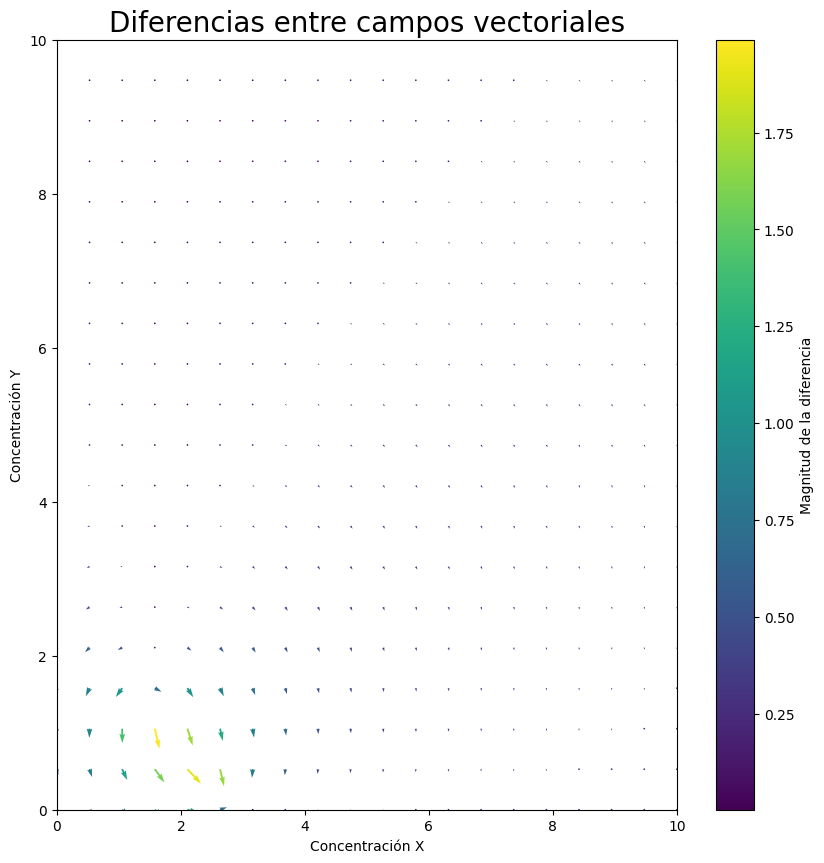

In [84]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7
u_diff2 = u_diff + epsilon
v_diff2 = v_diff + epsilon

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.
scale = 70

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

In [85]:
M_diff.mean()

0.2565636390083112

## Errores relativos

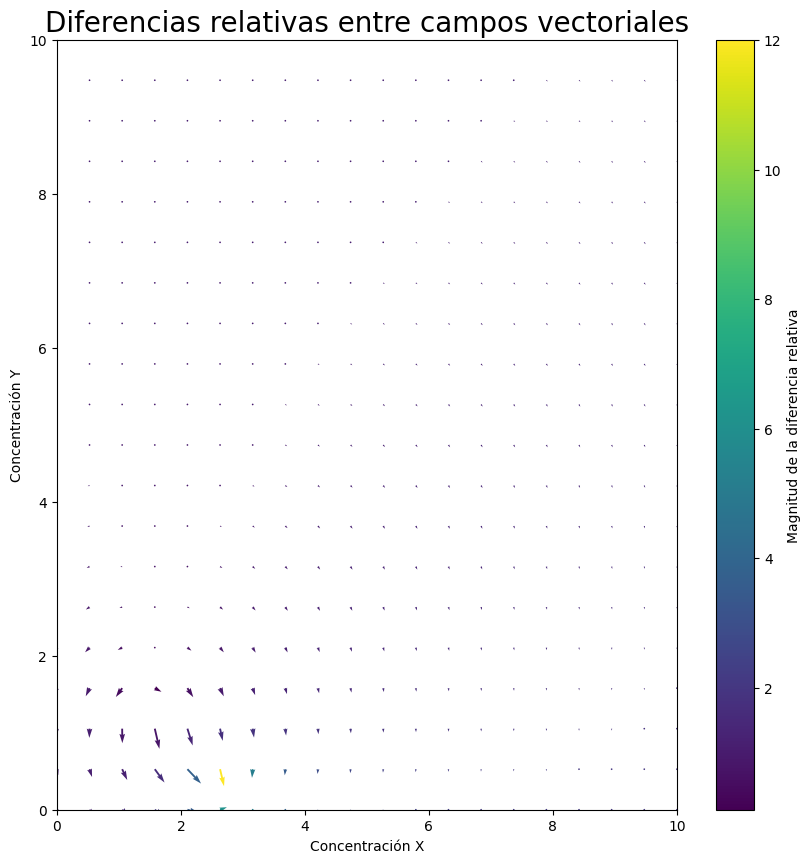

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [87]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 12.007538834115167
El valor de u1 en el error relativo máximo es: -0.35959504879600956
El valor de u1pred en el error relativo máximo es: -11.315789473684209
El valor de v1 en el error relativo máximo es: -1.1901008544372935
El valor de v1pred en el error relativo máximo es: 9.736842105263158


In [88]:
np.sqrt(u1pred[max_coords]**2+v1pred[max_coords]**2)/np.sqrt(u1[max_coords]**2+v1[max_coords]**2)

12.007539799940542

In [4]:
# Listas para almacenar los resultados
import random
porcentajes_por_dim = {}

for dim_size in range(20, 101, 5):
    porcentajes_temp = []  # Lista temporal para almacenar los porcentajes de cada iteración

    # Repetimos el proceso 10 veces
    for repetir in range(1000):
        campvec = []
        coef = []
        # constantes
        a1 = random.randint(0, 10)
        a2 = random.randint(0, 10)
        b1 = random.randint(0, 10)
        b2 = random.randint(0, 10)
        d1 = random.randint(0, 10)
        d2 = random.randint(0, 10)
        n = random.randint(0, 5)

        coef1 = [a1, a2, b1, b2, d1, d2, n]
        coef.append(coef1)

        def f(t, y):

            # asignar a cada ODE a un elemento de vector
            X = y[0]
            Y = y[1]

            # definimos cada ODE
            dX_dt = a1/(1+Y**n)-d1*X+b1
            dY_dt = a2/(1+X**n)-d2*Y+b2

            return [dX_dt, dY_dt]

        x_range_neg = 0
        x_range_pos = 10
        y_range_neg = 0
        y_range_pos = 10

        y1 = np.linspace(x_range_neg, x_range_pos, dim_size)
        y2 = np.linspace(y_range_neg, y_range_pos, dim_size)

        Y1, Y2 = np.meshgrid(y1, y2)
    
        t1 = 0

        u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

        NI, NJ = Y1.shape

        u1, v1 = f(t1, [Y1, Y2])
        u, v = f(t1, [Y1, Y2])
        M = (np.hypot(u, v))
        u /= M
        v /= M

        campvecci = np.append([u1], [v1], axis=0)

        campvec = campvecci
        print('--------------------------------------------')
    #    print(coef1)
    
        campvec = np.array(campvec)

    
        campvecnone = campvec[None, :]
        campvecnone = np.transpose(campvecnone, (0,2,3,1))
    
        new_predictions = new_model.predict(campvecnone)
        new_predictions = np.round(new_predictions)
        new_predictions = np.clip(new_predictions, 0, None)
    #    print(new_predictions)
    
    
        a1pred = new_predictions[0,0]
        a2pred = new_predictions[0,1]
        b1pred = new_predictions[0,2]
        b2pred = new_predictions[0,3]
        d1pred = new_predictions[0,4]
        d2pred = new_predictions[0,5]
        npred = new_predictions[0,6]
    
        def f(t, y):

            # asignar a cada ODE a un elemento de vector
            X = y[0]
            Y = y[1]

            # definimos cada ODE
            dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
            dY_dt = a2pred/(1+X**npred)-d2pred*Y+b2pred

            return [dX_dt, dY_dt]

        x_range_neg = 0
        x_range_pos = 10
        y_range_neg = 0
        y_range_pos = 10

        y1pred = np.linspace(x_range_neg, x_range_pos, dim_size)
        y2pred = np.linspace(y_range_neg, y_range_pos, dim_size)
    
        Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
        t1 = 0

        upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)
    
        NI, NJ = Y1.shape

        u1pred, v1pred = f(t1, [Y1, Y2])
        upred, vpred = f(t1, [Y1, Y2])
        Mpred = (np.hypot(upred, vpred))
        upred /= Mpred
        vpred /= Mpred
    
     # Calculamos las diferencias
        u_diff = u - upred
        v_diff = v - vpred

        # Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
        epsilon = 1e-7

        # Calculamos la magnitud del vector original y de la diferencia
        M_orig = np.hypot(u, v) + epsilon
        M_diff = np.hypot(u_diff, v_diff)

        # Calculamos la diferencia relativa
        M_diff_rel = M_diff / M_orig
    
        # Aplicamos el filtro para la diferencia relativa mayor a 0.05
        mask = M_diff_rel > 0.05

        # Calculamos el porcentaje de puntos que cumplen con la condición
        porcentaje = np.mean(mask) * 100

        # Almacenamos el resultado en la lista
        porcentajes_temp.append(porcentaje)

        print(f"El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración {repetir+1} es {porcentaje:.2f}%")
    
    promedio = np.mean(porcentajes_temp)
    print(f"El porcentaje promedio de puntos cuyo error relativo es mayor a 0.05 con dimensión {dim_size} es {promedio:.2f}%")
    porcentajes_por_dim[dim_size] = promedio


--------------------------------------------
1/1 [==============================] - 0s 87ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 1 es 93.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 2 es 98.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 3 es 93.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 4 es 78.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 5 es 97.00%
--------------------------------------------
1/1 [=========================

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 45 es 73.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 46 es 86.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 47 es 95.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 48 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 49 es 86.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 89 es 92.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 90 es 98.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 91 es 97.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 92 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 93 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 133 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 134 es 98.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 135 es 62.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 136 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 137 es 85.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 177 es 95.00%
--------------------------------------------
1/1 [==============================] - 0s 16ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 178 es 94.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 179 es 76.50%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 180 es 93.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 181 es 84.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 221 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 222 es 99.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 223 es 86.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 224 es 86.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 225 es 71.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 16ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 265 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 266 es 95.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 267 es 93.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 268 es 36.00%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 269 es 97.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 309 es 94.50%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 310 es 86.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 311 es 74.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 312 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 16ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 313 es 93.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 353 es 99.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 354 es 89.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 355 es 96.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 356 es 89.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 357 es 90.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 397 es 81.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 398 es 64.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 399 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 400 es 88.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 401 es 92.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 441 es 82.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 442 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 443 es 90.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 444 es 97.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 445 es 21.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 485 es 56.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 486 es 57.75%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 487 es 96.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 488 es 81.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 489 es 92.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 529 es 93.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 530 es 86.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 531 es 96.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 532 es 88.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 533 es 83.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 573 es 44.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 574 es 87.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 575 es 94.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 576 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 577 es 95.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 617 es 92.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 618 es 96.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 619 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 620 es 94.50%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 621 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 661 es 52.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 662 es 97.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 663 es 93.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 664 es 65.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 665 es 94.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 705 es 95.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 706 es 88.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 707 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 708 es 94.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 709 es 97.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 749 es 76.50%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 750 es 52.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 751 es 72.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 752 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 753 es 84.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 793 es 69.50%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 794 es 98.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 795 es 72.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 796 es 93.25%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 797 es 90.50%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 837 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 838 es 80.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 839 es 80.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 840 es 41.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 841 es 96.50%
--------------------------------------------
1/1 [==============================] - 0s 16ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 881 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 882 es 95.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 883 es 97.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 884 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 885 es 25.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 925 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 926 es 87.50%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 927 es 96.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 928 es 97.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 929 es 87.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 969 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 970 es 94.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 971 es 96.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 972 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 973 es 82.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 13 es 94.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 14 es 49.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 15 es 94.24%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 16 es 87.04%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 17 es 89.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 57 es 91.52%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 58 es 99.20%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 59 es 99.84%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 60 es 99.36%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 61 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de 

C:\Users\rafae\AppData\Local\Temp\ipykernel_33628\2864234719.py:55: RuntimeWarning: invalid value encountered in divide
  u /= M
C:\Users\rafae\AppData\Local\Temp\ipykernel_33628\2864234719.py:56: RuntimeWarning: invalid value encountered in divide
  v /= M


1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 85 es 99.84%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 86 es 97.76%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 87 es 75.84%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 88 es 18.08%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 89 es 99.04%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de p

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 129 es 96.48%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 130 es 94.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 131 es 92.64%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 132 es 60.48%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 133 es 71.20%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 173 es 84.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 174 es 96.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 175 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 176 es 81.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 177 es 91.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 217 es 88.96%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 218 es 68.32%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 219 es 83.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 220 es 91.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 221 es 89.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 261 es 95.04%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 262 es 96.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 263 es 90.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 264 es 91.20%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 265 es 98.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 305 es 92.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 306 es 97.28%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 307 es 78.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 308 es 94.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 309 es 93.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 349 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 350 es 97.92%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 351 es 81.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 352 es 88.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 353 es 96.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 393 es 96.96%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 394 es 92.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 395 es 89.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 396 es 88.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 397 es 92.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

C:\Users\rafae\AppData\Local\Temp\ipykernel_33628\2864234719.py:115: RuntimeWarning: invalid value encountered in divide
  upred /= Mpred
C:\Users\rafae\AppData\Local\Temp\ipykernel_33628\2864234719.py:116: RuntimeWarning: invalid value encountered in divide
  vpred /= Mpred


1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 412 es 98.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 413 es 94.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 414 es 97.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 415 es 40.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 416 es 63.52%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 456 es 92.48%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 457 es 88.32%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 458 es 96.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 459 es 70.24%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 460 es 96.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 500 es 87.52%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 501 es 98.08%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 502 es 95.36%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 503 es 94.72%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 504 es 96.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 544 es 91.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 545 es 97.92%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 546 es 78.24%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 547 es 71.04%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 548 es 99.52%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 588 es 99.84%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 589 es 90.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 590 es 99.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 591 es 94.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 592 es 99.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 632 es 85.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 633 es 96.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 634 es 60.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 635 es 81.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 636 es 93.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 676 es 84.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 677 es 88.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 678 es 99.20%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 679 es 96.32%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 680 es 65.28%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 720 es 97.28%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 721 es 94.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 722 es 84.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 723 es 59.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 724 es 95.36%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 764 es 97.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 765 es 69.12%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 766 es 97.44%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 767 es 99.52%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 768 es 87.84%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 808 es 99.52%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 809 es 93.76%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 810 es 91.68%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 811 es 25.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 812 es 99.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 852 es 91.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 853 es 66.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 854 es 61.92%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 855 es 94.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 856 es 95.68%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 896 es 83.68%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 897 es 96.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 898 es 87.52%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 899 es 94.56%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 900 es 97.60%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 940 es 91.52%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 941 es 53.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 942 es 86.24%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 943 es 98.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 944 es 42.88%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 984 es 93.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 985 es 71.04%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 986 es 72.16%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 987 es 99.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 988 es 89.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 28 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 29 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 30 es 95.67%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 31 es 78.78%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 32 es 85.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de 

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 72 es 95.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 73 es 93.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 74 es 90.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 75 es 92.22%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 76 es 97.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 116 es 89.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 117 es 88.11%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 118 es 95.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 119 es 95.78%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 120 es 87.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 160 es 89.67%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 161 es 69.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 162 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 163 es 80.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 164 es 80.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 204 es 94.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 205 es 99.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 206 es 99.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 207 es 89.22%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 208 es 95.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 248 es 94.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 249 es 99.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 250 es 94.33%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 251 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 252 es 99.78%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 292 es 81.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 293 es 76.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 294 es 91.78%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 295 es 95.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 296 es 93.22%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 336 es 98.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 337 es 99.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 338 es 99.11%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 339 es 99.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 340 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 380 es 98.78%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 381 es 87.89%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 382 es 94.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 383 es 93.22%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 384 es 98.89%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 424 es 99.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 425 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 426 es 99.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 427 es 83.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 428 es 61.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 468 es 95.11%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 469 es 93.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 470 es 29.33%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 471 es 99.22%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 472 es 93.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 512 es 84.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 513 es 53.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 514 es 96.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 515 es 96.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 516 es 41.67%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 556 es 47.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 557 es 88.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 558 es 79.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 559 es 73.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 560 es 94.22%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 600 es 93.56%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 601 es 94.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 602 es 89.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 603 es 96.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 604 es 97.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 644 es 99.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 645 es 71.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 646 es 96.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 647 es 64.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 648 es 73.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 688 es 99.89%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 689 es 94.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 690 es 69.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 691 es 92.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 692 es 96.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 732 es 87.33%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 733 es 99.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 734 es 92.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 735 es 82.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 736 es 77.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 776 es 98.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 777 es 97.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 778 es 95.11%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 779 es 96.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 780 es 92.11%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 820 es 87.89%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 821 es 69.56%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 822 es 94.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 823 es 84.11%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 824 es 96.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 864 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 865 es 97.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 866 es 44.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 867 es 95.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 868 es 98.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 908 es 84.56%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 909 es 97.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 910 es 68.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 911 es 85.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 912 es 91.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 952 es 21.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 953 es 96.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 954 es 40.89%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 955 es 88.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 956 es 97.78%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 996 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 997 es 71.44%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 998 es 85.33%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 999 es 99.89%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 1000 es 87.44%
El porcentaje promedio de puntos cuyo error relativo es mayor a 0.05 con dimensión 30 es 88.67%
------------

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 40 es 90.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 41 es 17.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 42 es 86.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 43 es 99.43%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 44 es 98.61%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 84 es 95.35%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 85 es 88.33%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 86 es 95.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 87 es 99.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 88 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de 

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 128 es 99.59%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 129 es 92.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 130 es 94.61%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 131 es 74.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 132 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 172 es 71.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 173 es 87.84%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 174 es 94.29%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 175 es 87.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 176 es 85.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 216 es 89.55%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 217 es 87.67%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 218 es 99.35%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 219 es 73.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 220 es 88.90%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 260 es 91.59%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 261 es 85.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 262 es 94.86%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 263 es 91.92%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 264 es 93.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 304 es 93.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 305 es 97.96%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 306 es 83.51%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 307 es 99.27%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 308 es 93.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 348 es 67.51%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 349 es 51.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 350 es 94.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 351 es 84.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 352 es 76.65%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 392 es 98.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 393 es 98.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 394 es 95.59%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 395 es 90.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 396 es 98.61%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 436 es 57.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 437 es 86.12%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 438 es 99.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 439 es 94.29%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 440 es 95.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 480 es 94.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 481 es 92.73%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 482 es 86.78%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 483 es 93.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 484 es 98.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 524 es 62.53%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 525 es 99.35%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 526 es 69.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 527 es 96.65%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 528 es 91.35%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 568 es 88.08%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 569 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 570 es 87.18%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 571 es 86.37%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 572 es 92.65%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 612 es 97.63%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 613 es 94.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 614 es 52.41%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 615 es 94.29%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 616 es 52.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 656 es 94.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 657 es 95.18%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 658 es 99.51%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 659 es 84.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 660 es 92.49%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 700 es 81.80%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 701 es 77.55%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 702 es 94.53%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 703 es 95.27%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 704 es 95.51%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 744 es 93.96%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 745 es 94.45%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 746 es 98.29%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 747 es 91.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 748 es 83.92%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 788 es 99.92%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 789 es 90.61%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 790 es 99.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 791 es 98.12%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 792 es 81.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 832 es 94.37%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 833 es 88.41%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 834 es 97.06%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 835 es 98.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 836 es 99.18%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 876 es 99.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 877 es 93.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 878 es 71.76%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 879 es 99.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 880 es 95.43%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 920 es 50.29%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 921 es 97.22%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 922 es 88.41%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 923 es 99.92%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 924 es 96.41%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 964 es 95.92%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 965 es 93.88%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 966 es 55.84%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 967 es 85.80%
--------------------------------------------
1/1 [==============================] - 0s 16ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 968 es 84.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 8 es 99.88%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 9 es 95.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 10 es 89.50%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 11 es 71.56%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 12 es 99.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de pun

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 52 es 92.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 53 es 96.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 54 es 85.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 55 es 98.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 56 es 86.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 96 es 95.94%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 97 es 88.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 98 es 73.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 99 es 94.19%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 100 es 94.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de 

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 140 es 94.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 141 es 99.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 142 es 96.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 143 es 78.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 144 es 90.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 184 es 90.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 185 es 99.44%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 186 es 73.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 187 es 97.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 188 es 97.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 228 es 97.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 229 es 98.06%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 230 es 95.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 231 es 99.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 232 es 70.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 272 es 54.37%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 273 es 97.69%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 274 es 92.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 275 es 92.69%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 276 es 28.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 316 es 83.62%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 317 es 93.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 318 es 38.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 319 es 88.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 320 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 360 es 62.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 361 es 94.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 362 es 97.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 363 es 65.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 364 es 90.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 404 es 91.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 405 es 91.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 406 es 91.12%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 407 es 93.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 408 es 99.88%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 448 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 449 es 91.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 450 es 92.94%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 451 es 78.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 452 es 93.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 492 es 83.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 493 es 96.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 494 es 82.31%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 495 es 97.19%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 496 es 80.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 536 es 99.81%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 537 es 99.81%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 538 es 90.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 539 es 83.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 540 es 17.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 580 es 89.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 581 es 83.31%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 582 es 74.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 583 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 584 es 80.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 624 es 99.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 625 es 94.62%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 626 es 83.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 627 es 93.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 628 es 92.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 668 es 96.44%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 669 es 91.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 670 es 93.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 671 es 70.38%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 672 es 59.88%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 712 es 93.62%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 713 es 97.62%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 714 es 96.00%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 715 es 29.06%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 716 es 83.56%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 756 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 757 es 95.81%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 758 es 75.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 759 es 97.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 760 es 95.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 800 es 82.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 801 es 91.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 802 es 93.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 803 es 84.44%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 804 es 92.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 844 es 79.31%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 845 es 85.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 846 es 96.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 847 es 89.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 848 es 52.88%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 888 es 87.12%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 889 es 70.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 890 es 88.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 891 es 81.62%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 892 es 43.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 932 es 40.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 933 es 77.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 934 es 97.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 935 es 96.19%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 936 es 57.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 976 es 23.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 977 es 6.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 978 es 95.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 979 es 99.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 980 es 94.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje 

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 20 es 99.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 21 es 94.42%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 22 es 82.42%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 23 es 97.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 24 es 72.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 64 es 99.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 65 es 99.70%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 66 es 91.11%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 67 es 80.54%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 68 es 99.26%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 108 es 47.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 109 es 91.51%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 110 es 79.65%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 111 es 89.83%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 112 es 85.78%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 152 es 92.49%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 153 es 99.51%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 154 es 59.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 155 es 84.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 156 es 91.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 196 es 21.09%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 197 es 99.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 198 es 81.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 199 es 86.12%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 200 es 99.36%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 240 es 95.16%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 241 es 96.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 242 es 94.81%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 243 es 90.32%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 244 es 95.46%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 284 es 92.30%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 285 es 99.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 286 es 21.14%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 287 es 94.37%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 288 es 78.17%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 328 es 96.99%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 329 es 94.81%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 330 es 95.85%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 331 es 98.27%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 332 es 90.62%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 372 es 92.59%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 373 es 89.63%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 374 es 89.63%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 375 es 86.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 376 es 86.17%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 416 es 96.10%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 417 es 55.46%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 418 es 79.41%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 419 es 95.70%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 420 es 83.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 460 es 99.85%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 461 es 85.19%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 462 es 95.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 463 es 90.57%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 464 es 74.07%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 504 es 95.46%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 505 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 506 es 94.02%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 507 es 90.77%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 508 es 54.72%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 548 es 56.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 549 es 97.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 550 es 49.33%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 551 es 97.73%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 552 es 93.73%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 592 es 99.21%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 593 es 83.01%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 594 es 14.07%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 595 es 90.57%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 596 es 94.27%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 636 es 92.15%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 637 es 92.99%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 638 es 70.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 639 es 77.28%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 640 es 79.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 680 es 97.28%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 681 es 95.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 682 es 88.54%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 683 es 74.22%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 684 es 98.37%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 724 es 85.98%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 725 es 84.99%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 726 es 96.20%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 727 es 99.85%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 728 es 98.81%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 768 es 72.79%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 769 es 58.07%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 770 es 84.74%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 771 es 47.60%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 772 es 92.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 812 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 813 es 75.85%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 814 es 99.26%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 815 es 75.51%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 816 es 95.21%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaj

1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 856 es 84.49%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 857 es 5.09%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 858 es 96.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 859 es 93.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 860 es 90.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje 

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 900 es 75.65%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 901 es 81.43%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 902 es 97.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 903 es 58.86%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 904 es 98.17%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 944 es 82.37%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 945 es 93.63%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 946 es 93.33%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 947 es 44.74%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 948 es 83.41%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 988 es 96.49%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 989 es 92.10%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 990 es 90.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 991 es 94.37%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 992 es 85.38%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 32 es 74.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 33 es 89.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 34 es 73.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 35 es 25.96%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 36 es 96.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 76 es 96.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 77 es 91.96%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 78 es 91.40%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 79 es 92.72%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 80 es 78.24%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 120 es 94.52%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 121 es 99.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 122 es 94.48%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 123 es 99.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 124 es 97.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 164 es 99.28%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 165 es 99.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 166 es 95.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 167 es 61.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 168 es 65.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 208 es 71.32%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 209 es 79.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 210 es 75.76%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 211 es 66.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 212 es 91.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 252 es 92.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 253 es 97.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 254 es 88.32%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 255 es 88.52%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 256 es 75.60%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 296 es 77.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 297 es 55.32%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 298 es 94.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 299 es 91.68%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 300 es 96.96%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 340 es 95.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 341 es 68.04%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 342 es 95.32%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 343 es 98.40%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 344 es 99.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 384 es 89.48%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 385 es 85.08%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 386 es 98.32%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 387 es 90.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 388 es 48.44%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 428 es 79.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 429 es 94.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 430 es 90.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 431 es 98.24%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 432 es 99.84%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 472 es 89.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 473 es 86.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 474 es 99.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 475 es 93.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 476 es 98.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 516 es 92.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 517 es 33.36%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 518 es 81.72%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 519 es 33.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 520 es 91.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 560 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 561 es 94.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 562 es 77.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 563 es 88.32%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 564 es 96.68%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 604 es 84.68%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 605 es 99.04%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 606 es 95.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 607 es 89.48%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 608 es 96.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 648 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 649 es 96.56%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 650 es 81.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 651 es 96.40%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 652 es 99.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 692 es 68.32%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 693 es 13.20%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 694 es 95.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 695 es 88.48%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 696 es 83.84%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 736 es 87.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 737 es 8.24%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 738 es 88.64%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 739 es 91.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 740 es 78.24%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje 

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 780 es 99.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 781 es 38.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 782 es 90.08%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 783 es 90.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 784 es 78.48%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 824 es 89.36%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 825 es 17.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 826 es 99.76%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 827 es 94.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 828 es 69.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 868 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 869 es 84.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 870 es 83.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 871 es 96.96%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 872 es 59.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 912 es 28.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 913 es 97.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 914 es 42.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 915 es 52.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 916 es 84.64%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 956 es 64.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 957 es 88.64%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 958 es 94.32%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 959 es 97.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 960 es 74.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 1000 es 73.04%
El porcentaje promedio de puntos cuyo error relativo es mayor a 0.05 con dimensión 50 es 83.43%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 1 es 20.66%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 2 es 63.74%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 3 es 97.09%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 4 es 63.67%
---------------------

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 44 es 92.10%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 45 es 95.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 46 es 79.07%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 47 es 89.26%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 48 es 37.79%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 88 es 50.68%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 89 es 93.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 90 es 86.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 91 es 99.90%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 92 es 77.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 132 es 71.87%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 133 es 94.61%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 134 es 58.74%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 135 es 99.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 136 es 71.70%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 176 es 92.99%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 177 es 89.98%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 178 es 99.77%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 179 es 88.53%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 180 es 49.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 220 es 85.65%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 221 es 70.61%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 222 es 94.58%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 223 es 89.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 224 es 90.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 264 es 97.59%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 265 es 99.57%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 266 es 68.73%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 267 es 59.01%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 268 es 86.21%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 308 es 70.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 309 es 62.98%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 310 es 80.40%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 311 es 96.33%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 312 es 93.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 352 es 25.32%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 353 es 85.65%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 354 es 81.42%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 355 es 76.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 356 es 68.10%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 396 es 98.98%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 397 es 93.59%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 398 es 71.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 399 es 89.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 400 es 98.84%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 440 es 70.98%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 441 es 89.85%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 442 es 87.93%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 443 es 84.10%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 444 es 69.09%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 484 es 93.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 485 es 77.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 486 es 87.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 487 es 95.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 488 es 88.17%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 528 es 96.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 529 es 99.70%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 530 es 60.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 531 es 82.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 532 es 37.79%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 572 es 80.53%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 573 es 67.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 574 es 83.21%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 575 es 63.74%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 576 es 98.68%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 616 es 77.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 617 es 96.36%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 618 es 73.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 619 es 92.79%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 620 es 84.93%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 660 es 96.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 661 es 87.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 662 es 85.26%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 663 es 96.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 664 es 57.98%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 704 es 82.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 705 es 82.91%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 706 es 87.60%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 707 es 93.62%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 708 es 41.88%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 748 es 84.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 749 es 88.66%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 750 es 90.98%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 751 es 99.24%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 752 es 81.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 792 es 96.99%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 793 es 88.26%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 794 es 99.54%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 795 es 96.17%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 796 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 836 es 83.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 837 es 93.49%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 838 es 89.49%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 839 es 15.07%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 840 es 42.45%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 880 es 99.93%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 881 es 83.70%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 882 es 91.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 883 es 41.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 884 es 24.30%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 924 es 86.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 925 es 87.34%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 926 es 67.01%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 927 es 76.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 928 es 61.69%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 968 es 81.19%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 969 es 91.14%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 970 es 85.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 971 es 96.23%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 972 es 53.26%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 12 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 13 es 37.81%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 14 es 85.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 15 es 92.39%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 16 es 68.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 56 es 80.14%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 57 es 87.28%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 58 es 97.89%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 59 es 93.22%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 60 es 84.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 100 es 95.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 101 es 92.81%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 102 es 6.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 103 es 91.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 104 es 80.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje 

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 144 es 90.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 145 es 93.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 146 es 84.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 147 es 93.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 148 es 89.81%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 188 es 94.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 189 es 88.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 190 es 88.19%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 191 es 99.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 192 es 69.83%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 232 es 52.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 233 es 97.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 234 es 85.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 235 es 61.83%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 236 es 76.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 276 es 82.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 277 es 47.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 278 es 11.83%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 279 es 67.17%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 280 es 93.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 320 es 99.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 321 es 97.67%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 322 es 99.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 323 es 60.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 324 es 48.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 364 es 87.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 365 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 366 es 92.06%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 367 es 99.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 368 es 84.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 408 es 84.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 409 es 93.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 410 es 98.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 411 es 85.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 412 es 88.36%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 452 es 76.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 453 es 94.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 454 es 89.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 455 es 99.31%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 456 es 72.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 496 es 96.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 497 es 98.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 498 es 66.92%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 499 es 98.19%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 500 es 91.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 540 es 83.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 541 es 91.03%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 542 es 48.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 543 es 52.97%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 544 es 98.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 584 es 78.81%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 585 es 52.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 586 es 79.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 587 es 88.78%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 588 es 99.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 628 es 98.33%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 629 es 36.81%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 630 es 79.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 631 es 86.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 632 es 96.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 672 es 87.81%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 673 es 64.44%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 674 es 84.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 675 es 98.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 676 es 80.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 716 es 45.11%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 717 es 79.97%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 718 es 99.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 719 es 81.03%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 720 es 95.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 760 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 761 es 62.08%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 762 es 82.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 763 es 79.97%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 764 es 91.42%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 804 es 87.83%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 805 es 95.64%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 806 es 99.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 807 es 59.19%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 808 es 79.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 848 es 99.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 849 es 94.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 850 es 78.25%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 851 es 92.61%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 852 es 93.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 892 es 94.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 893 es 78.83%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 894 es 76.86%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 895 es 89.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 896 es 83.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 936 es 6.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 937 es 92.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 938 es 98.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 939 es 76.36%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 940 es 89.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 980 es 89.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 981 es 92.36%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 982 es 79.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 983 es 85.14%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 984 es 97.25%
--------------------------------------------
1/1 [==============================] - 0s 16ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 24 es 95.10%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 25 es 92.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 26 es 81.54%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 27 es 87.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 28 es 81.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 68 es 85.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 69 es 84.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 70 es 52.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 71 es 73.35%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 72 es 43.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 112 es 74.22%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 113 es 87.74%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 114 es 83.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 115 es 70.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 116 es 18.30%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 156 es 77.63%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 157 es 92.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 158 es 87.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 159 es 92.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 160 es 99.01%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 200 es 99.72%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 201 es 41.30%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 202 es 76.57%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 203 es 76.14%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 204 es 80.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 244 es 85.42%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 245 es 99.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 246 es 63.62%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 247 es 55.74%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 248 es 58.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 288 es 31.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 289 es 89.87%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 290 es 93.54%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 291 es 74.08%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 292 es 51.53%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 332 es 87.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 333 es 84.26%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 334 es 21.61%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 335 es 98.70%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 336 es 83.24%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 376 es 69.87%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 377 es 93.59%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 378 es 73.09%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 379 es 90.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 380 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 420 es 82.41%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 421 es 75.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 422 es 83.69%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 423 es 99.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 424 es 90.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 464 es 69.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 465 es 96.40%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 466 es 63.60%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 467 es 69.68%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 468 es 76.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 508 es 77.51%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 509 es 73.68%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 510 es 86.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 511 es 93.35%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 512 es 71.10%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 552 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 553 es 92.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 554 es 72.99%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 555 es 11.41%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 556 es 64.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 596 es 33.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 597 es 41.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 598 es 50.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 599 es 73.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 600 es 31.69%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 640 es 99.43%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 641 es 75.57%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 642 es 84.59%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 643 es 74.01%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 644 es 22.77%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 684 es 93.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 685 es 99.72%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 686 es 73.82%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 687 es 71.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 688 es 34.34%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 728 es 55.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 729 es 89.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 730 es 56.21%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 731 es 85.68%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 732 es 92.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 772 es 99.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 773 es 89.07%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 774 es 96.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 775 es 80.73%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 776 es 87.55%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 816 es 80.31%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 817 es 65.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 818 es 92.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 819 es 69.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 820 es 75.01%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 860 es 87.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 861 es 77.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 862 es 92.02%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 863 es 11.17%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 864 es 99.01%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 904 es 26.44%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 905 es 76.17%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 906 es 96.43%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 907 es 98.70%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 908 es 67.53%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 948 es 81.18%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 949 es 81.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 950 es 79.03%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 951 es 74.65%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 952 es 75.20%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 992 es 38.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 993 es 99.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 994 es 69.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 995 es 45.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 996 es 74.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 36 es 32.82%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 37 es 88.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 38 es 99.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 39 es 30.39%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 40 es 85.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 80 es 14.67%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 81 es 25.02%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 82 es 82.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 83 es 5.82%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 84 es 79.65%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de pu

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 124 es 92.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 125 es 87.47%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 126 es 83.49%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 127 es 76.33%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 128 es 44.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 168 es 86.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 169 es 68.90%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 170 es 19.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 171 es 80.82%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 172 es 80.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 212 es 89.04%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 213 es 99.24%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 214 es 88.37%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 215 es 89.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 216 es 83.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 256 es 98.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 257 es 99.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 258 es 81.22%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 259 es 93.55%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 260 es 36.55%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 300 es 83.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 301 es 86.67%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 302 es 42.37%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 303 es 81.45%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 304 es 88.14%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 344 es 70.59%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 345 es 89.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 346 es 38.47%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 347 es 86.27%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 348 es 97.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 388 es 70.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 389 es 82.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 390 es 98.08%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 391 es 20.24%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 392 es 76.82%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 432 es 38.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 433 es 98.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 434 es 98.35%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 435 es 71.71%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 436 es 90.73%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 476 es 46.45%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 477 es 94.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 478 es 99.35%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 479 es 82.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 480 es 10.55%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 520 es 90.63%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 521 es 99.98%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 522 es 6.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 523 es 72.90%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 524 es 75.57%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 564 es 82.16%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 565 es 91.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 566 es 89.57%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 567 es 92.94%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 568 es 77.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 608 es 92.59%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 609 es 99.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 610 es 91.71%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 611 es 46.98%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 612 es 96.37%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 652 es 30.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 653 es 71.55%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 654 es 60.18%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 655 es 98.41%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 656 es 21.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 696 es 84.92%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 697 es 83.24%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 698 es 28.14%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 699 es 84.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 700 es 44.98%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 740 es 83.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 741 es 39.12%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 742 es 86.76%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 743 es 91.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 744 es 59.08%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 784 es 48.49%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 785 es 93.35%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 786 es 95.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 787 es 78.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 788 es 92.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 828 es 97.84%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 829 es 85.14%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 830 es 68.96%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 831 es 85.18%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 832 es 84.49%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 872 es 97.45%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 873 es 81.33%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 874 es 29.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 875 es 39.73%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 876 es 87.04%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 916 es 94.53%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 917 es 67.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 918 es 92.43%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 919 es 73.55%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 920 es 84.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 960 es 76.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 961 es 60.90%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 962 es 84.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 963 es 87.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 964 es 96.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 4 es 76.34%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 5 es 95.09%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 6 es 6.95%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 7 es 96.85%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 8 es 84.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos 

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 48 es 99.29%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 49 es 63.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 50 es 93.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 51 es 45.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 52 es 67.41%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 92 es 83.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 93 es 88.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 94 es 70.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 95 es 79.31%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 96 es 34.06%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 136 es 99.41%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 137 es 87.59%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 138 es 89.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 139 es 59.93%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 140 es 65.26%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 180 es 83.70%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 181 es 83.63%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 182 es 74.35%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 183 es 80.52%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 184 es 70.81%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 224 es 34.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 225 es 69.85%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 226 es 73.03%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 227 es 12.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 228 es 92.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 268 es 20.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 269 es 47.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 270 es 98.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 271 es 67.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 272 es 94.24%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 312 es 99.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 313 es 83.34%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 314 es 23.57%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 315 es 87.48%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 316 es 67.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 356 es 63.41%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 357 es 99.06%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 358 es 98.99%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 359 es 98.76%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 360 es 17.65%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 400 es 54.61%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 401 es 65.40%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 402 es 52.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 403 es 36.14%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 404 es 55.52%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 444 es 64.21%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 445 es 67.41%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 446 es 78.93%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 447 es 14.58%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 448 es 84.60%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 488 es 92.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 489 es 72.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 490 es 81.99%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 491 es 50.99%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 492 es 66.61%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 532 es 76.84%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 533 es 69.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 534 es 74.35%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 535 es 54.63%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 536 es 96.89%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 576 es 88.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 577 es 66.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 578 es 98.29%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 579 es 94.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 580 es 14.24%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 620 es 55.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 621 es 93.30%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 622 es 85.26%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 623 es 81.87%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 624 es 48.52%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 664 es 75.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 665 es 87.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 666 es 36.84%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 667 es 79.88%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 668 es 89.24%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 708 es 36.34%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 709 es 87.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 710 es 98.79%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 711 es 77.69%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 712 es 42.65%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 752 es 84.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 753 es 97.97%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 754 es 74.29%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 755 es 97.19%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 756 es 98.01%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 796 es 10.95%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 797 es 87.29%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 798 es 98.99%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 799 es 5.65%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 800 es 96.09%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje 

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 840 es 78.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 841 es 80.91%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 842 es 87.29%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 843 es 99.57%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 844 es 76.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 884 es 66.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 885 es 78.70%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 886 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 887 es 97.87%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 888 es 86.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 928 es 38.72%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 929 es 99.66%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 930 es 87.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 931 es 66.84%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 932 es 79.66%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 972 es 61.46%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 973 es 95.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 974 es 84.23%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 975 es 33.64%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 976 es 58.49%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 16 es 77.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 17 es 95.14%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 18 es 40.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 19 es 11.30%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 20 es 72.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de p

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 60 es 77.45%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 61 es 84.14%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 62 es 98.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 63 es 91.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 64 es 97.50%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 104 es 97.98%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 105 es 78.28%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 106 es 96.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 107 es 89.09%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 108 es 84.09%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 148 es 64.73%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 149 es 11.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 150 es 44.17%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 151 es 39.45%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 152 es 74.86%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 192 es 83.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 193 es 82.73%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 194 es 63.53%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 195 es 70.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 196 es 88.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 236 es 68.61%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 237 es 99.69%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 238 es 19.59%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 239 es 74.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 240 es 18.70%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 280 es 64.67%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 281 es 38.05%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 282 es 63.73%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 283 es 54.03%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 284 es 64.59%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 324 es 89.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 325 es 85.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 326 es 65.17%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 327 es 60.30%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 328 es 96.88%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 368 es 99.34%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 369 es 98.52%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 370 es 71.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 371 es 72.38%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 372 es 54.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 412 es 85.55%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 413 es 38.27%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 414 es 28.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 415 es 38.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 416 es 35.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 456 es 54.19%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 457 es 75.20%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 458 es 96.36%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 459 es 99.48%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 460 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 500 es 98.20%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 501 es 86.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 502 es 51.95%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 503 es 96.41%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 504 es 74.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 544 es 83.02%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 545 es 38.66%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 546 es 51.95%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 547 es 74.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 548 es 83.22%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 588 es 67.42%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 589 es 32.08%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 590 es 98.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 591 es 74.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 592 es 90.95%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 632 es 62.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 633 es 85.12%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 634 es 99.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 635 es 86.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 636 es 96.58%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 676 es 28.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 677 es 82.83%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 678 es 85.03%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 679 es 96.38%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 680 es 26.55%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 720 es 71.39%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 721 es 97.59%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 722 es 93.05%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 723 es 78.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 724 es 90.73%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 764 es 44.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 765 es 50.92%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 766 es 55.27%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 767 es 63.73%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 768 es 92.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 808 es 82.19%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 809 es 23.23%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 810 es 77.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 811 es 44.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 812 es 99.52%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 852 es 57.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 853 es 74.78%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 854 es 13.11%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 855 es 99.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 856 es 64.78%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 896 es 39.39%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 897 es 57.14%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 898 es 90.64%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 899 es 99.41%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 900 es 46.14%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 940 es 58.59%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 941 es 96.56%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 942 es 64.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 943 es 63.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 944 es 94.31%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 984 es 89.08%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 985 es 94.62%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 986 es 24.42%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 987 es 82.11%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 988 es 65.48%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 28 es 95.10%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 29 es 61.91%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 30 es 83.21%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 31 es 55.52%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 32 es 93.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 72 es 87.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 73 es 77.63%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 74 es 66.30%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 75 es 86.66%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 76 es 80.22%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 116 es 96.43%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 117 es 90.13%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 118 es 93.73%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 119 es 95.03%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 120 es 72.79%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 160 es 78.21%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 161 es 89.63%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 162 es 87.74%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 163 es 88.51%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 164 es 20.46%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 204 es 97.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 205 es 85.90%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 206 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 207 es 89.77%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 208 es 92.47%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaj

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 248 es 85.11%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 249 es 92.87%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 250 es 73.70%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 251 es 97.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 252 es 25.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 292 es 99.10%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 293 es 20.55%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 294 es 59.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 295 es 68.68%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 296 es 47.83%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 336 es 70.35%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 337 es 35.54%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 338 es 76.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 339 es 82.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 340 es 63.32%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 380 es 38.96%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 381 es 71.07%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 382 es 67.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 383 es 87.53%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 384 es 99.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 424 es 14.19%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 425 es 99.52%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 426 es 73.27%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 427 es 83.93%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 428 es 41.63%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 468 es 65.62%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 469 es 70.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 470 es 74.66%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 471 es 76.61%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 472 es 59.21%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 512 es 71.32%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 513 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 514 es 35.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 515 es 98.31%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 516 es 75.93%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaj

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 556 es 69.22%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 557 es 44.24%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 558 es 47.46%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 559 es 98.87%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 560 es 54.42%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 600 es 83.86%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 601 es 11.57%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 602 es 99.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 603 es 75.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 604 es 76.12%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 644 es 54.46%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 645 es 86.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 646 es 92.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 647 es 1.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 648 es 64.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 688 es 63.79%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 689 es 28.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 690 es 54.05%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 691 es 79.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 692 es 40.35%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 732 es 66.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 733 es 87.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 734 es 82.77%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 735 es 99.28%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 736 es 68.40%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 776 es 62.30%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 777 es 63.46%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 778 es 90.16%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 779 es 90.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 780 es 13.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 820 es 36.03%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 821 es 63.72%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 822 es 61.09%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 823 es 94.46%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 824 es 76.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 864 es 67.53%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 865 es 70.96%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 866 es 99.46%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 867 es 39.27%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 868 es 84.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 908 es 73.02%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 909 es 21.11%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 910 es 99.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 911 es 25.02%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 912 es 95.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 952 es 96.57%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 953 es 27.29%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 954 es 65.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 955 es 82.55%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 956 es 36.83%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 996 es 99.17%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 997 es 85.38%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 998 es 74.78%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 999 es 98.69%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 1000 es 76.58%
El porcentaje promedio de puntos cuyo error relativo es mayor a 0.05 con dimensión 85 es 72.52%
-------------

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 40 es 41.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 41 es 59.58%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 42 es 26.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 43 es 90.05%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 44 es 99.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 84 es 39.15%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 85 es 98.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 86 es 32.58%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 87 es 84.06%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 88 es 71.85%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de p

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 128 es 98.89%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 129 es 87.48%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 130 es 33.07%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 131 es 43.40%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 132 es 78.00%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 172 es 21.64%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 173 es 39.62%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 174 es 65.30%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 175 es 99.06%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 176 es 92.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 216 es 88.93%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 217 es 59.04%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 218 es 90.58%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 219 es 87.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 220 es 55.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 260 es 67.85%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 261 es 90.17%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 262 es 70.56%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 263 es 72.48%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 264 es 62.52%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 304 es 67.78%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 305 es 98.68%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 306 es 77.14%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 307 es 90.60%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 308 es 65.10%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 348 es 43.59%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 349 es 90.63%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 350 es 99.73%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 351 es 56.40%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 352 es 63.81%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 392 es 96.58%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 393 es 59.78%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 394 es 93.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 395 es 67.74%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 396 es 10.53%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 436 es 65.56%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 437 es 97.46%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 438 es 59.35%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 439 es 98.37%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 440 es 81.07%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 480 es 92.30%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 481 es 90.93%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 482 es 99.51%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 483 es 26.68%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 484 es 68.83%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 524 es 98.85%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 525 es 85.56%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 526 es 82.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 527 es 67.32%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 528 es 81.46%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 568 es 92.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 569 es 99.58%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 570 es 96.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 571 es 88.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 572 es 95.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 612 es 84.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 613 es 30.74%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 614 es 84.73%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 615 es 44.62%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 616 es 84.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 656 es 36.42%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 657 es 98.79%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 658 es 62.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 659 es 75.47%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 660 es 60.35%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 700 es 99.78%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 701 es 22.38%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 702 es 57.04%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 703 es 37.44%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 704 es 98.53%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 744 es 94.54%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 745 es 91.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 746 es 68.53%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 747 es 98.58%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 748 es 82.32%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 788 es 56.89%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 789 es 83.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 790 es 75.62%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 791 es 21.01%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 792 es 81.37%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 832 es 99.11%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 833 es 90.74%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 834 es 29.27%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 835 es 93.37%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 836 es 57.81%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 876 es 93.35%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 877 es 90.74%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 878 es 97.33%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 879 es 22.48%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 880 es 81.83%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 920 es 87.74%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 921 es 38.47%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 922 es 94.84%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 923 es 61.14%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 924 es 76.57%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 964 es 72.75%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 965 es 99.79%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 966 es 78.35%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 967 es 74.98%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 968 es 23.77%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 8 es 96.06%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 9 es 77.07%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 10 es 94.30%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 11 es 73.55%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 12 es 85.95%
--------------------------------------------
1/1 [======================

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 52 es 76.10%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 53 es 97.94%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 54 es 70.40%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 55 es 97.50%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 56 es 8.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de pu

1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 96 es 76.71%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 97 es 95.28%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 98 es 81.66%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 99 es 92.10%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 100 es 51.88%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de 

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 140 es 98.61%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 141 es 68.43%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 142 es 86.65%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 143 es 86.46%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 144 es 19.93%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 184 es 97.19%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 185 es 57.91%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 186 es 49.54%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 187 es 92.90%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 188 es 86.80%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 228 es 90.73%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 229 es 84.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 230 es 6.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 231 es 57.07%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 232 es 16.88%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje 

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 272 es 16.63%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 273 es 82.59%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 274 es 95.43%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 275 es 96.13%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 276 es 34.16%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 316 es 99.27%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 317 es 96.58%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 318 es 43.46%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 319 es 21.51%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 320 es 83.77%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 360 es 99.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 361 es 86.93%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 362 es 52.49%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 363 es 96.76%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 364 es 34.69%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 404 es 76.84%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 405 es 99.07%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 406 es 19.83%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 407 es 35.45%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 408 es 97.14%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 448 es 23.91%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 449 es 99.46%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 450 es 98.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 451 es 90.63%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 452 es 92.55%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 492 es 97.52%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 493 es 60.73%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 494 es 74.46%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 495 es 97.23%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 496 es 72.21%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 536 es 30.69%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 537 es 62.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 538 es 93.24%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 539 es 60.21%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 540 es 34.06%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 580 es 14.45%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 581 es 61.02%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 582 es 37.22%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 583 es 48.81%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 584 es 78.79%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 624 es 99.24%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 625 es 72.90%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 626 es 44.48%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 627 es 87.73%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 628 es 72.81%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 668 es 93.62%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 669 es 99.36%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 670 es 16.62%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 671 es 91.77%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 672 es 99.47%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 712 es 62.06%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 713 es 30.91%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 714 es 70.98%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 715 es 70.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 716 es 30.27%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 756 es 86.59%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 757 es 94.34%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 758 es 79.90%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 759 es 99.91%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 760 es 95.36%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 800 es 72.25%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 801 es 56.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 802 es 88.91%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 803 es 79.45%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 804 es 79.92%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 844 es 23.69%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 845 es 99.16%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 846 es 98.71%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 847 es 74.67%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 848 es 63.87%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 888 es 90.85%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 889 es 80.58%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 890 es 9.57%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 891 es 99.60%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 892 es 74.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje 

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 932 es 78.55%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 933 es 27.29%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 934 es 59.15%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 935 es 89.67%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 936 es 83.78%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 976 es 45.22%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 977 es 73.33%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 978 es 47.62%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 979 es 62.89%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 980 es 99.26%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 20 es 53.76%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 21 es 92.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 22 es 29.54%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 23 es 99.45%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 24 es 14.63%
--------------------------------------------
1/1 [====================

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 64 es 58.51%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 65 es 86.62%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 66 es 77.35%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 67 es 42.19%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 68 es 77.80%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de p

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 108 es 23.59%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 109 es 39.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 110 es 92.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 111 es 10.88%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 112 es 98.06%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 152 es 3.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 153 es 69.90%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 154 es 71.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 155 es 10.67%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 156 es 48.31%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje 

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 196 es 99.38%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 197 es 44.75%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 198 es 99.29%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 199 es 11.02%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 200 es 71.32%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 240 es 51.77%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 241 es 48.43%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 242 es 97.74%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 243 es 56.32%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 244 es 72.30%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 284 es 94.85%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 285 es 70.18%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 286 es 76.01%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 287 es 94.24%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 288 es 51.73%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 328 es 95.65%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 329 es 91.61%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 330 es 60.45%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 331 es 79.37%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 332 es 75.44%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 372 es 96.22%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 373 es 97.68%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 374 es 90.18%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 375 es 85.39%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 376 es 71.34%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 416 es 77.39%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 417 es 42.70%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 418 es 99.26%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 419 es 53.59%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 420 es 5.58%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje 

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 460 es 48.44%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 461 es 94.70%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 462 es 99.78%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 463 es 98.97%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 464 es 98.19%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 504 es 26.13%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 505 es 92.66%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 506 es 89.39%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 507 es 79.79%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 508 es 19.83%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 548 es 57.62%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 549 es 88.26%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 550 es 94.99%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 551 es 8.79%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 552 es 20.42%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje 

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 592 es 96.01%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 593 es 79.64%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 594 es 31.03%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 595 es 11.68%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 596 es 4.99%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje 

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 636 es 25.15%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 637 es 43.64%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 638 es 59.65%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 639 es 3.12%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 640 es 74.40%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje 

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 680 es 64.67%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 681 es 47.40%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 682 es 97.27%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 683 es 19.35%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 684 es 93.12%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 724 es 62.79%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 725 es 95.59%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 726 es 33.73%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 727 es 26.93%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 728 es 71.80%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 768 es 23.33%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 769 es 39.04%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 770 es 21.10%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 771 es 91.20%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 772 es 99.90%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 812 es 98.65%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 813 es 85.94%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 814 es 84.14%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 815 es 81.11%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 816 es 53.13%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 856 es 81.10%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 857 es 99.27%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 858 es 43.24%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 859 es 29.90%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 860 es 89.22%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje

1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 900 es 22.32%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 901 es 26.26%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 902 es 92.00%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 903 es 70.71%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 904 es 46.97%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje

1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 944 es 99.18%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 945 es 73.68%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 946 es 15.39%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 947 es 4.72%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 948 es 62.90%
--------------------------------------------
1/1 [==============================] - 0s 14ms/step
El porcentaje 

1/1 [==============================] - 0s 15ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 988 es 53.28%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 989 es 54.15%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 990 es 5.15%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 991 es 15.51%
--------------------------------------------
1/1 [==============================] - 0s 13ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 992 es 64.46%
--------------------------------------------
1/1 [==============================] - 0s 15ms/step
El porcentaje 

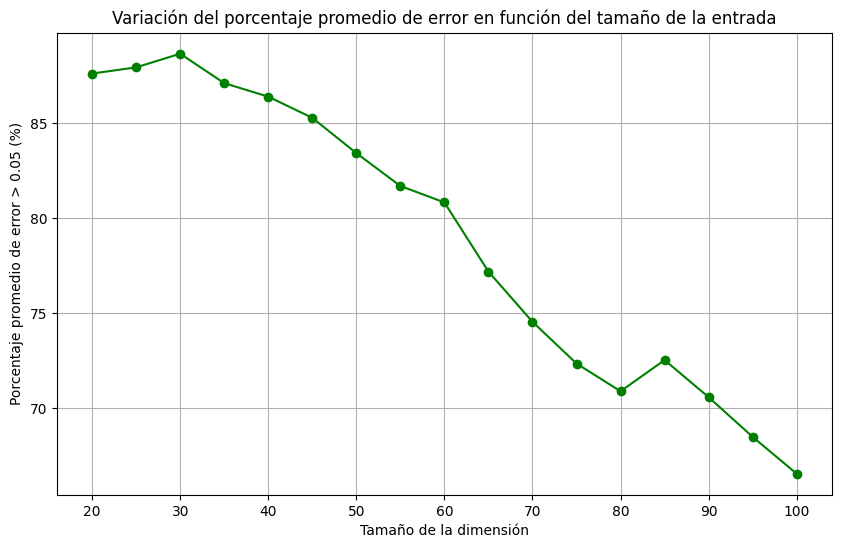

In [5]:
import matplotlib.pyplot as plt
# Graficar cómo varía la métrica promedio en función del tamaño de la entrada
plt.figure(figsize=(10, 6))
plt.plot(list(porcentajes_por_dim.keys()), list(porcentajes_por_dim.values()), marker='o', color = 'green')
plt.xlabel('Tamaño de la dimensión')
plt.ylabel('Porcentaje promedio de error > 0.05 (%)')
plt.title('Variación del porcentaje promedio de error en función del tamaño de la entrada')
plt.grid(True)
plt.show()